# Case Study : Rossmann stores

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

With thousands of individual managers predicticting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

Store - an Id that represents the store

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - describes thedistance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

Store - a unique Id for each store

DayOfWeek - Describes the day of the week (1 - Monday till 7 - Sunday)

Date - Describes the date on the day

Sales - the turnover for any given day (this is what you are forecasting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

###Things to do:
#### 1:Find outliers at the 99th percentile and remove them.

#### 2:Standardize the sales and number of customers variables before modelling.

#### 3:Determine if the data is stationary

#### 4:If stationary then apply Vector Autoregression Model.

#### 5:If non-stationary then specify the model in differences

#### 6:Make sales, promo2 and any other variables you think of as dependent variables.

#### 7:look for cointegration using the Johansen test. 

#### 8:Predict sales for the next 6 weeks.

## Step 1 : Import necessary libraries and warnings.

In [2]:
# Import all necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [3]:

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline 

In [4]:
# Filter out the warnings.

import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 80000)

## Step 2 : Reading and understanding the dataset.

In [6]:
# Reading the dataset.

store = pd.read_csv(r"C:\Users\91797\Desktop\store.csv")
train = pd.read_csv(r"C:\Users\91797\Desktop\train.csv", parse_dates = True, index_col = "Date")

In [7]:
# examine initial and tail records of store dataset.

store.head().append(store.tail())

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [8]:
# examine shape of dataset.

print(store.shape)
print(train.shape)

(1115, 10)
(1017209, 8)


Train sample have very large amount of data

### examine overall dataset

In [9]:
# Describe the dataset.

store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [10]:
# Describe the dataset.

train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [11]:
# examine info of dataset.

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [12]:
# examine info of dataset.

store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## Step 3 : Data Preprocessing and Cleaning.

### 3.1. looking for missing values and Imput missing values.

In [13]:
# Define a function for getting missing values.

def getMissingValues_for_train(missingCutoff):
    missing = (train.isnull().sum()/train.shape[0])
    print("There are {} features having more than {}% missing values in train".format(len(missing.loc[missing > missingCutoff]),missingCutoff))
    return missing.loc[missing > missingCutoff]


def getMissingValues_for_store(missingCutoff):
    missing = (store.isnull().sum()/store.shape[0])
    print("There are {} features having more than {}% missing values store".format(len(missing.loc[missing > missingCutoff]),missingCutoff))
    return missing.loc[missing > missingCutoff]

### look for train.

In [14]:
# examine missing values in train dataset.

getMissingValues_for_train(0)

There are 0 features having more than 0% missing values in train


Series([], dtype: float64)

no missing values which is good.



let see when sales is 0

In [15]:
# look if there are days when sales is 0.

train[(train["Sales"] == 0)]["Sales"].count()

172871

sales 0 when the store was closed or any other reason.

In [16]:
# Here also have days when sales is 0 because store is closed look for it.

train[(train["Sales"] == 0) & (train["Open"] == 0)]["Sales"].count()

172817

In [17]:
# Get the percentage of data when sales is 0 because store is closed.

float(train[(train["Sales"] == 0) & (train["Open"] == 0)]["Sales"].count()) / len(train)

0.16989330609540418

- most of the days where store sale is 0 as store is closed.
- However, there are also days with 0 sales when the store is open this data we can use.
- About 17% of the data shows that the store were closed and thus the 0 sales lets drop this data

In [18]:
# Droping the data where store sales are 0 beacuse store is closed.

train = train[(train["Open"] != 0)]

In [19]:
# look train after dropping data.

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844392 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844392 non-null  int64 
 1   DayOfWeek      844392 non-null  int64 
 2   Sales          844392 non-null  int64 
 3   Customers      844392 non-null  int64 
 4   Open           844392 non-null  int64 
 5   Promo          844392 non-null  int64 
 6   StateHoliday   844392 non-null  object
 7   SchoolHoliday  844392 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 58.0+ MB


### Now look for store.

In [20]:
# examine missing values in store dataset.

getMissingValues_for_store(0)

There are 6 features having more than 0% missing values store


CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [21]:
# Imput missing values for "CompetitionDistance" column with the mean of the column.

store["CompetitionDistance"].fillna(store["CompetitionDistance"].median(), inplace = True)

In [22]:
# Imput missing values for other columns.

store.fillna(0, inplace = True) 

In [23]:
# Again chcek for missing values in store data after imputation.

getMissingValues_for_store(0)

There are 0 features having more than 0% missing values store


Series([], dtype: float64)

### 3.2. Feature Creation.

#### Sales/Customer ratio

In [24]:
# Create new feature "Sales/Customer" since they are related.

train["Sales/Customer"] = train["Sales"] / train["Customers"]

In [25]:
# look for the stats of new feature.

train.describe()

Store      DayOfWeek          Sales      Customers      Open  \
count  844392.000000  844392.000000  844392.000000  844392.000000  844392.0   
mean      558.422920       3.520361    6955.514291     762.728395       1.0   
std       321.731914       1.723689    3104.214680     401.227674       0.0   
min         1.000000       1.000000       0.000000       0.000000       1.0   
25%       280.000000       2.000000    4859.000000     519.000000       1.0   
50%       558.000000       3.000000    6369.000000     676.000000       1.0   
75%       837.000000       5.000000    8360.000000     893.000000       1.0   
max      1115.000000       7.000000   41551.000000    7388.000000       1.0   

               Promo  SchoolHoliday  Sales/Customer  
count  844392.000000  844392.000000   844340.000000  
mean        0.446352       0.193580        9.493619  
std         0.497114       0.395103        2.197494  
min         0.000000       0.000000        0.000000  
25%         0.000000       0.000000        7.895563  
50%         0.000000       0.000000        9.250000  
75%         1.000000       0.000000       10.899729  
max         1.000000       1.000000       64.957854

- average Sales/Customer: 9.5. The maximum Sales, Customers, and Sales/Customer made by a particular store is about 41551,7388 and $65.

In [26]:
# examine store which have avg sales/customer is 9.5

train[(train["Customers"] >= 7388) | (train["Sales/Customer"] >= 64.957854) | (train["Sales"] >= 41551)]

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-06-22    909          1  41551       1721     1      0            0   
2013-09-02    897          1  16954        261     1      0            0   
2013-01-22    817          2  27190       7388     1      1            0   

            SchoolHoliday  Sales/Customer  
Date                                       
2015-06-22              0       24.143521  
2013-09-02              0       64.957854  
2013-01-22              0        3.680292

- Only some store shows result for more customers then more sales.
- Here looks like more customers does not mean more sales.
- Probably some stores offers different range of products.

In [27]:
# let's extract the year, month,day and week info from the datetime index for future analysis

# Extracting the year,month,day and week from the index.

train["Year"] = train.index.year
train["Month"] = train.index.month
train["Day"] = train.index.day
train["Week"] = train.index.weekofyear

### 3.3. Merge the train and store dataset. 

In [28]:
# Merge the train and store. 

Merge = pd.merge(train, store, on = "Store")
print(Merge.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Sales/Customer', 'Year', 'Month',
       'Day', 'Week', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [29]:
# examine merged dataset.

Merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Sales                      844392 non-null  int64  
 3   Customers                  844392 non-null  int64  
 4   Open                       844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   Sales/Customer             844340 non-null  float64
 9   Year                       844392 non-null  int64  
 10  Month                      844392 non-null  int64  
 11  Day                        844392 non-null  int64  
 12  Week                       844392 non-null  int64  
 13  StoreType                  84

- Sales/Customer colums has about some rows with null values. 
- Those with 0 customers.

In [30]:
# Impute the missing value in "Sales/Customer" feature.

Merge["Sales/Customer"].fillna(0, inplace = True)

In [31]:
# look for missing values after imputation.

Merge.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Sales/Customer               0
Year                         0
Month                        0
Day                          0
Week                         0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [32]:
# examine info of merged dataset.

Merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Sales                      844392 non-null  int64  
 3   Customers                  844392 non-null  int64  
 4   Open                       844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   Sales/Customer             844392 non-null  float64
 9   Year                       844392 non-null  int64  
 10  Month                      844392 non-null  int64  
 11  Day                        844392 non-null  int64  
 12  Week                       844392 non-null  int64  
 13  StoreType                  84

In [33]:
#  intital 5 records of merged dataset.

Merge.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Sales/Customer  Year  Month  Day  Week StoreType Assortment  \
0              1        9.482883  2015      7   31    31         c          a   
1              1        9.194139  2015      7   30    31         c          a   
2              1        9.143403  2015      7   29    31         c          a   
3              1        8.948214  2015      7   28    31         c          a   
4              1        9.970588  2015      7   27    31         c          a   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1               1270.0                        9.0                    2008.0   
2               1270.0                        9.0                    2008.0   
3               1270.0                        9.0                    2008.0   
4               1270.0                        9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval  
0       0              0.0              0.0             0  
1       0              0.0              0.0             0  
2       0              0.0              0.0             0  
3       0              0.0              0.0             0  
4       0              0.0              0.0             0

- We lost the index from train dataframe when merging with store. 
- We need to keep the index for further processing later on. 
- Thus, let's add a column to store this info.

In [34]:
# Create index column to retain the datetime index. 

Merge["index"] = Merge.apply(lambda x : datetime.strptime("{0} {1} {2} 00:00:00".format(x["Year"], 
                                                              x["Month"], x["Day"]), "%Y %m %d %H:%M:%S"), axis = 1)

In [35]:
# examine dataset.

Merge.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      1          4   5020        546     1      1            0   
2      1          3   4782        523     1      1            0   
3      1          2   5011        560     1      1            0   
4      1          1   6102        612     1      1            0   

   SchoolHoliday  Sales/Customer  Year  Month  Day  Week StoreType Assortment  \
0              1        9.482883  2015      7   31    31         c          a   
1              1        9.194139  2015      7   30    31         c          a   
2              1        9.143403  2015      7   29    31         c          a   
3              1        8.948214  2015      7   28    31         c          a   
4              1        9.970588  2015      7   27    31         c          a   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1               1270.0                        9.0                    2008.0   
2               1270.0                        9.0                    2008.0   
3               1270.0                        9.0                    2008.0   
4               1270.0                        9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval      index  
0       0              0.0              0.0             0 2015-07-31  
1       0              0.0              0.0             0 2015-07-30  
2       0              0.0              0.0             0 2015-07-29  
3       0              0.0              0.0             0 2015-07-28  
4       0              0.0              0.0             0 2015-07-27

### 3.4. outliers.

In [36]:
# look for outliers.

Merge.describe()

Store      DayOfWeek          Sales      Customers      Open  \
count  844392.000000  844392.000000  844392.000000  844392.000000  844392.0   
mean      558.422920       3.520361    6955.514291     762.728395       1.0   
std       321.731914       1.723689    3104.214680     401.227674       0.0   
min         1.000000       1.000000       0.000000       0.000000       1.0   
25%       280.000000       2.000000    4859.000000     519.000000       1.0   
50%       558.000000       3.000000    6369.000000     676.000000       1.0   
75%       837.000000       5.000000    8360.000000     893.000000       1.0   
max      1115.000000       7.000000   41551.000000    7388.000000       1.0   

               Promo  SchoolHoliday  Sales/Customer           Year  \
count  844392.000000  844392.000000   844392.000000  844392.000000   
mean        0.446352       0.193580        9.493034    2013.831937   
std         0.497114       0.395103        2.198689       0.777260   
min         0.000000       0.000000        0.000000    2013.000000   
25%         0.000000       0.000000        7.895316    2013.000000   
50%         0.000000       0.000000        9.249698    2014.000000   
75%         1.000000       0.000000       10.899631    2014.000000   
max         1.000000       1.000000       64.957854    2015.000000   

               Month            Day           Week  CompetitionDistance  \
count  844392.000000  844392.000000  844392.000000        844392.000000   
mean        5.845738      15.835683      23.646801          5449.868829   
std         3.323931       8.683456      14.389785          7800.946702   
min         1.000000       1.000000       1.000000            20.000000   
25%         3.000000       8.000000      11.000000           710.000000   
50%         6.000000      16.000000      23.000000          2325.000000   
75%         8.000000      23.000000      35.000000          6880.000000   
max        12.000000      31.000000      52.000000         75860.000000   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear         Promo2  \
count              844392.000000             844392.000000  844392.000000   
mean                    4.926491               1369.688401       0.498684   
std                     4.283663                935.558173       0.499999   
min                     0.000000                  0.000000       0.000000   
25%                     0.000000                  0.000000       0.000000   
50%                     4.000000               2006.000000       0.000000   
75%                     9.000000               2011.000000       1.000000   
max                    12.000000               2015.000000       1.000000   

       Promo2SinceWeek  Promo2SinceYear  
count    844392.000000    844392.000000  
mean         11.596118      1003.230065  
std          15.307873      1005.874806  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%           0.000000         0.000000  
75%          22.000000      2012.000000  
max          50.000000      2015.000000

In [37]:
# Keep the data in between 0.0 to 0.99 and remove the outliers.

cols = ["Store", "DayOfWeek", "Sales", "Customers", "Open", "Promo", "SchoolHoliday", "Sales/Customer", "Year", 
        "Month", "Day", "Week", "CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", 
        "Promo2", "Promo2SinceWeek", "Promo2SinceYear"]

Q1 = Merge[cols].quantile(0.00)
Q3 = Merge[cols].quantile(0.99)
IQR = Q3 - Q1

Merge = Merge[~((Merge[cols] < (Q1 - 1.5 * IQR)) |(Merge[cols] > (Q3 + 1.5 * IQR))).any(axis = 1)]

In [38]:
# examine dataset.

Merge.describe()

Store      DayOfWeek          Sales      Customers      Open  \
count  844372.000000  844372.000000  844372.000000  844372.000000  844372.0   
mean      558.422300       3.520365    6955.210867     762.728470       1.0   
std       321.730528       1.723693    3103.484062     401.163781       0.0   
min         1.000000       1.000000       0.000000       0.000000       1.0   
25%       280.000000       2.000000    4859.000000     519.000000       1.0   
50%       558.000000       3.000000    6369.000000     676.000000       1.0   
75%       837.000000       5.000000    8360.000000     893.000000       1.0   
max      1115.000000       7.000000   41551.000000    5494.000000       1.0   

               Promo  SchoolHoliday  Sales/Customer           Year  \
count  844372.000000  844372.000000   844372.000000  844372.000000   
mean        0.446352       0.193577        9.492186    2013.831957   
std         0.497114       0.395101        2.191065       0.777259   
min         0.000000       0.000000        0.000000    2013.000000   
25%         0.000000       0.000000        7.895296    2013.000000   
50%         0.000000       0.000000        9.249658    2014.000000   
75%         1.000000       0.000000       10.899493    2014.000000   
max         1.000000       1.000000       36.834520    2015.000000   

               Month            Day           Week  CompetitionDistance  \
count  844372.000000  844372.000000  844372.000000        844372.000000   
mean        5.845675      15.835670      23.646521          5449.922960   
std         3.323924       8.683462      14.389747          7801.030426   
min         1.000000       1.000000       1.000000            20.000000   
25%         3.000000       8.000000      11.000000           710.000000   
50%         6.000000      16.000000      23.000000          2325.000000   
75%         8.000000      23.000000      35.000000          6880.000000   
max        12.000000      31.000000      52.000000         75860.000000   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear         Promo2  \
count              844372.000000             844372.000000  844372.000000   
mean                    4.926497               1369.673240       0.498674   
std                     4.283662                935.564066       0.499999   
min                     0.000000                  0.000000       0.000000   
25%                     0.000000                  0.000000       0.000000   
50%                     4.000000               2006.000000       0.000000   
75%                     9.000000               2011.000000       1.000000   
max                    12.000000               2015.000000       1.000000   

       Promo2SinceWeek  Promo2SinceYear  
count    844372.000000     844372.00000  
mean         11.596157       1003.20855  
std          15.308018       1005.87474  
min           0.000000          0.00000  
25%           0.000000          0.00000  
50%           0.000000          0.00000  
75%          22.000000       2012.00000  
max          50.000000       2015.00000

### 3.5. Skewness in the data.

In [39]:
# examine columns which ara highly skewed by observing the unique value counts in rach column.

for column in Merge:
    print(Merge[column].astype('category').value_counts(normalize = True) * 100)
    print("============================================================================================================")

769     0.111562
1097    0.111562
85      0.111562
562     0.111562
262     0.111562
733     0.111562
494     0.111562
682     0.111562
335     0.111562
423     0.111562
259     0.110378
274     0.110378
353     0.110259
948     0.109904
676     0.108720
530     0.107299
578     0.106707
310     0.106233
1099    0.105759
863     0.105048
453     0.105048
122     0.104812
1045    0.104575
732     0.104575
299     0.104456
209     0.104456
524     0.104338
867     0.104219
931     0.103627
433     0.102088
877     0.095456
7       0.093087
54      0.092969
599     0.092850
600     0.092850
222     0.092850
730     0.092850
230     0.092850
606     0.092850
173     0.092850
596     0.092850
163     0.092850
595     0.092850
609     0.092850
594     0.092850
741     0.092850
593     0.092850
588     0.092850
761     0.092850
236     0.092850
237     0.092850
585     0.092850
240     0.092850
763     0.092850
580     0.092850
221     0.092850
211     0.092850
217     0.092850
622     0.0928

In [40]:
# Dropping the columns contains highyl skewed and contains single value.

Col_m = Merge[["Open"]]
Merge.drop(Col_m, axis = 1, inplace = True)

In [41]:
# examine data after dealing with skewness.

Merge.describe()

Store      DayOfWeek          Sales      Customers  \
count  844372.000000  844372.000000  844372.000000  844372.000000   
mean      558.422300       3.520365    6955.210867     762.728470   
std       321.730528       1.723693    3103.484062     401.163781   
min         1.000000       1.000000       0.000000       0.000000   
25%       280.000000       2.000000    4859.000000     519.000000   
50%       558.000000       3.000000    6369.000000     676.000000   
75%       837.000000       5.000000    8360.000000     893.000000   
max      1115.000000       7.000000   41551.000000    5494.000000   

               Promo  SchoolHoliday  Sales/Customer           Year  \
count  844372.000000  844372.000000   844372.000000  844372.000000   
mean        0.446352       0.193577        9.492186    2013.831957   
std         0.497114       0.395101        2.191065       0.777259   
min         0.000000       0.000000        0.000000    2013.000000   
25%         0.000000       0.000000        7.895296    2013.000000   
50%         0.000000       0.000000        9.249658    2014.000000   
75%         1.000000       0.000000       10.899493    2014.000000   
max         1.000000       1.000000       36.834520    2015.000000   

               Month            Day           Week  CompetitionDistance  \
count  844372.000000  844372.000000  844372.000000        844372.000000   
mean        5.845675      15.835670      23.646521          5449.922960   
std         3.323924       8.683462      14.389747          7801.030426   
min         1.000000       1.000000       1.000000            20.000000   
25%         3.000000       8.000000      11.000000           710.000000   
50%         6.000000      16.000000      23.000000          2325.000000   
75%         8.000000      23.000000      35.000000          6880.000000   
max        12.000000      31.000000      52.000000         75860.000000   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear         Promo2  \
count              844372.000000             844372.000000  844372.000000   
mean                    4.926497               1369.673240       0.498674   
std                     4.283662                935.564066       0.499999   
min                     0.000000                  0.000000       0.000000   
25%                     0.000000                  0.000000       0.000000   
50%                     4.000000               2006.000000       0.000000   
75%                     9.000000               2011.000000       1.000000   
max                    12.000000               2015.000000       1.000000   

       Promo2SinceWeek  Promo2SinceYear  
count    844372.000000     844372.00000  
mean         11.596157       1003.20855  
std          15.308018       1005.87474  
min           0.000000          0.00000  
25%           0.000000          0.00000  
50%           0.000000          0.00000  
75%          22.000000       2012.00000  
max          50.000000       2015.00000

### 3.6. Categorical features.

In [42]:
# examine datatype of columns.

Merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844372 entries, 0 to 844391
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844372 non-null  int64         
 1   DayOfWeek                  844372 non-null  int64         
 2   Sales                      844372 non-null  int64         
 3   Customers                  844372 non-null  int64         
 4   Promo                      844372 non-null  int64         
 5   StateHoliday               844372 non-null  object        
 6   SchoolHoliday              844372 non-null  int64         
 7   Sales/Customer             844372 non-null  float64       
 8   Year                       844372 non-null  int64         
 9   Month                      844372 non-null  int64         
 10  Day                        844372 non-null  int64         
 11  Week                       844372 non-null  int64   

In [43]:
# Convert the categorical columns into numerical columns.

mappings = {"0" : 0, "a" : 1, "b" : 2, "c" : 3, "d" : 4}

Merge.StoreType.replace(mappings, inplace = True)
Merge.Assortment.replace(mappings, inplace = True)
Merge.StateHoliday.replace(mappings, inplace = True)

In [44]:
# examine features data after conversion.

Merge[["StoreType", "Assortment", "StateHoliday"]].head()

StoreType  Assortment  StateHoliday
0          3           1             0
1          3           1             0
2          3           1             0
3          3           1             0
4          3           1             0

### 3.7. Standardize the Sales and number of Customers variables.

In [45]:
# examine records in data.

Merge.head()

Store  DayOfWeek  Sales  Customers  Promo  StateHoliday  SchoolHoliday  \
0      1          5   5263        555      1             0              1   
1      1          4   5020        546      1             0              1   
2      1          3   4782        523      1             0              1   
3      1          2   5011        560      1             0              1   
4      1          1   6102        612      1             0              1   

   Sales/Customer  Year  Month  Day  Week  StoreType  Assortment  \
0        9.482883  2015      7   31    31          3           1   
1        9.194139  2015      7   30    31          3           1   
2        9.143403  2015      7   29    31          3           1   
3        8.948214  2015      7   28    31          3           1   
4        9.970588  2015      7   27    31          3           1   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1               1270.0                        9.0                    2008.0   
2               1270.0                        9.0                    2008.0   
3               1270.0                        9.0                    2008.0   
4               1270.0                        9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval      index  
0       0              0.0              0.0             0 2015-07-31  
1       0              0.0              0.0             0 2015-07-30  
2       0              0.0              0.0             0 2015-07-29  
3       0              0.0              0.0             0 2015-07-28  
4       0              0.0              0.0             0 2015-07-27

In [46]:
# Standardize the sales and customer variables.

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
Merge[["Sales", "Customers"]] = scale.fit_transform(Merge[["Sales", "Customers"]])

In [47]:
# examine data after scaling.

Merge.head()

Store  DayOfWeek     Sales  Customers  Promo  StateHoliday  SchoolHoliday  \
0      1          5 -0.545262  -0.517815      1             0              1   
1      1          4 -0.623561  -0.540250      1             0              1   
2      1          3 -0.700249  -0.597583      1             0              1   
3      1          2 -0.626461  -0.505351      1             0              1   
4      1          1 -0.274920  -0.375728      1             0              1   

   Sales/Customer  Year  Month  Day  Week  StoreType  Assortment  \
0        9.482883  2015      7   31    31          3           1   
1        9.194139  2015      7   30    31          3           1   
2        9.143403  2015      7   29    31          3           1   
3        8.948214  2015      7   28    31          3           1   
4        9.970588  2015      7   27    31          3           1   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1               1270.0                        9.0                    2008.0   
2               1270.0                        9.0                    2008.0   
3               1270.0                        9.0                    2008.0   
4               1270.0                        9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval      index  
0       0              0.0              0.0             0 2015-07-31  
1       0              0.0              0.0             0 2015-07-30  
2       0              0.0              0.0             0 2015-07-29  
3       0              0.0              0.0             0 2015-07-28  
4       0              0.0              0.0             0 2015-07-27

## Step 4 : Perform EDA.

### Analysis on dataset features.

[]

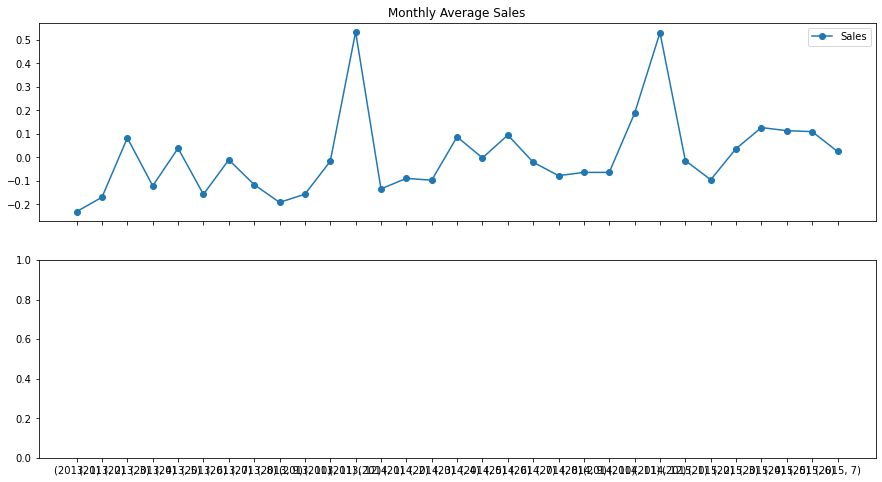

In [48]:
# Group by date and get average sales, and precent change

avg_sales = Merge.groupby(["Year", "Month"])["Sales"].mean()
pct_change_sales = Merge.groupby(["Year", "Month"])["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2, 1, sharex = True, figsize=(15,8))

# Plot average sales over time(year-month)

axis1 = avg_sales.plot(legend = True, ax = axis1,marker = "o", title = "Monthly Average Sales")
axis1.set_xticks(range(len(avg_sales)))
axis1.set_xticklabels(avg_sales.index.tolist(), rotation=90)


In [49]:
# Plot percent change for sales over time(year-month)

axis2 = pct_change_sales.plot(legend ="True", ax = axis2, marker = "o", rot = 90, 
                            colormap = "summer", title = "MoM Percent Change in Sales")


1. There is evidence of peaks followed by troughs in monthly average sales. 
2. Almost for every steep rise in sales there is an immediate fall. 
3. A sharp rise in sales can be seen during end of the year and smaller spikes during the summer months (June-September).

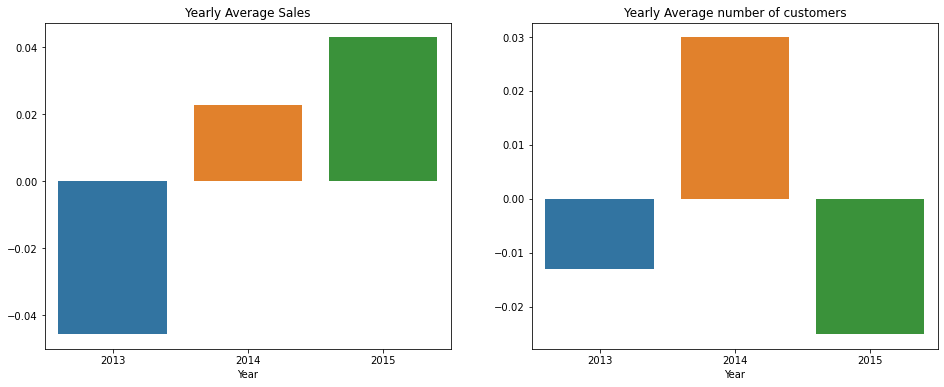

In [50]:
# Plot average sales & customers for every year

fig, (axis1,axis2) = plt.subplots(1, 2, figsize = (16, 6))

Var = Merge.groupby("Year")["Sales"].mean()
sns.barplot(x = Var.index, y = Var.values, ax = axis1)
axis1.set_xlabel("Year")
axis1.set_title("Yearly Average Sales")

Var2 = Merge.groupby("Year")["Customers"].mean()
sns.barplot(x = Var2.index, y = Var2.values, ax = axis2)
axis2.set_xlabel("Year")
axis2.set_title("Yearly Average number of customers")
plt.show()


1. Average sales has increased as  progress over the years while average number of customers visiting has increased from 2013 to 2014. 
2. Since have only around 7 months of data for 2015 its difficult to comment about 2015.

### Let's look for DayOfWeek.

Text(0, 0.5, 'Customers')

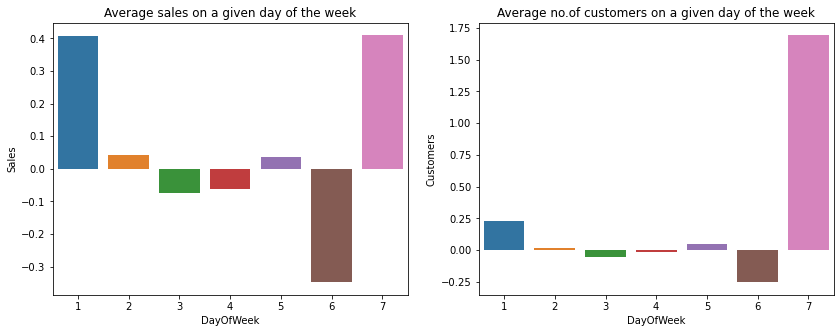

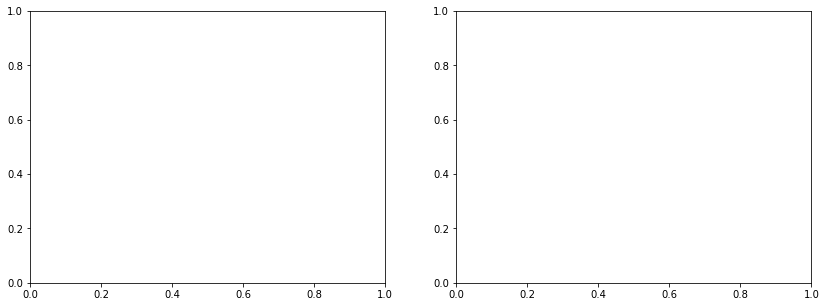

In [51]:
# In both cases where the store is closed and opened

fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (14, 5))
fig, (ax3, ax4) = plt.subplots(1, 2, figsize = (14, 5))
mask = Merge["Sales"] > 0

DayOfWeek_Sale = Merge.groupby("DayOfWeek")["Sales"].mean()
DayOfWeek_Cust = Merge.groupby("DayOfWeek")["Customers"].mean()
sns.barplot(x = DayOfWeek_Sale.index, y = DayOfWeek_Sale.values, ax = axis1)
axis1.set_title("Average sales on a given day of the week")
axis1.set_ylabel("Sales")
sns.barplot(x = DayOfWeek_Cust.index, y = DayOfWeek_Cust.values, ax = axis2)
axis2.set_title("Average no.of customers on a given day of the week")
axis2.set_ylabel("Customers")



In [52]:
DayOfWeek_Sale = Merge[mask].groupby("DayOfWeek")["Sales"].mean()
DayOfWeek_Cust = Merge[mask].groupby("DayOfWeek")["Customers"].mean()
sns.barplot(x = DayOfWeek_Sale.index, y = DayOfWeek_Sale.values, ax = ax3)
ax3.set_title("Average sales on a given day of the week(Open stores only)")
ax3.set_ylabel("Sales")
sns.barplot(x = DayOfWeek_Cust.index, y = DayOfWeek_Cust.values, ax = ax4)
ax4.set_title("Average no.of customers on a given day of the week(Open stores only)")
ax4.set_ylabel("Customers")
plt.show()


1. Most of the stores remain closed on sundays(day 7). 
2. So if we consider both opened and closed stores average Sunday sales are lowest.
3. But on the contrary if we consider Open stores only, Sunday and Monday (day 1) sales are among the highest. 
4. The number of customers visiting on Sundays are much more any other day on an average.

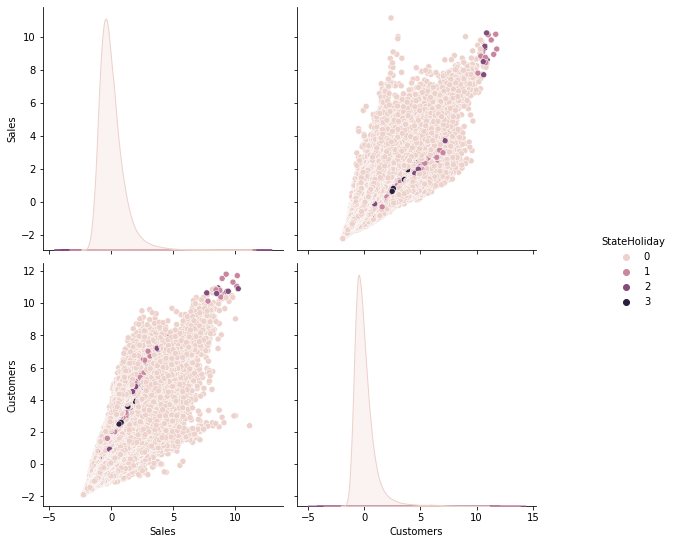

In [53]:
# Plot to observe Sales, Customers on StateHoliday. 

g = sns.pairplot(Merge, vars = ["Sales", "Customers"], hue = "StateHoliday")
g.fig.set_size_inches(10, 8)
plt.show()


1. The above plots observtion proposes a hypothesis that having  state holiday leads to higher sales as more customers show up.

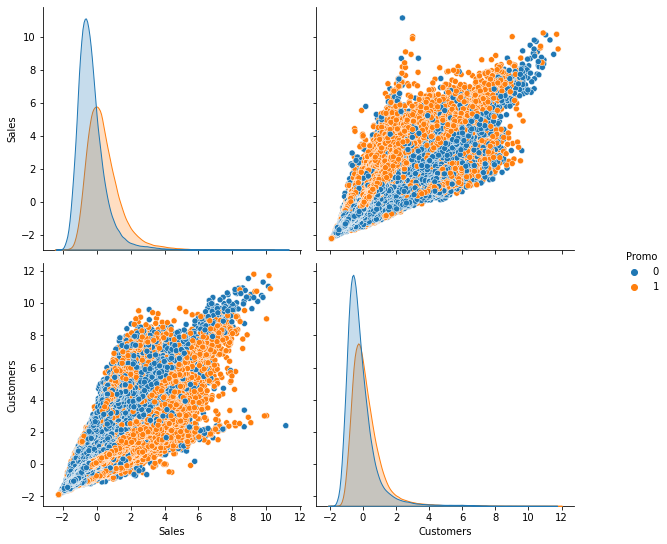

In [54]:
# Plot to observe the effect of promo features on nu of Sales and Customers.

g = sns.pairplot(Merge, vars = ["Sales", "Customers"], hue = "Promo")
g.fig.set_size_inches(10, 8)
plt.show()


1. The sales and number of Customers are found to be similar based on whether there is promo or not.

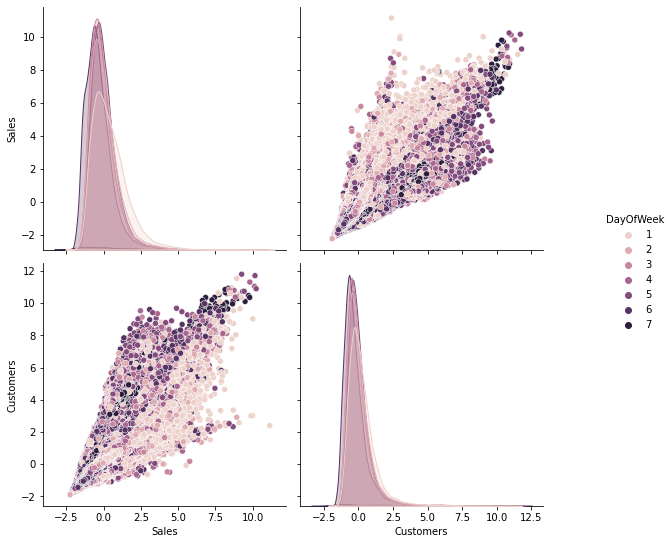

In [55]:
# Plot to observe the effect of week days on sales and customers.

g = sns.pairplot(Merge, vars = ["Sales", "Customers"], hue = "DayOfWeek")
g.fig.set_size_inches(10, 8)
plt.show()


1. We can notice slightly higher Sales and Customers during the end of the week

### Lets look for StoreType and Sales, Customers.

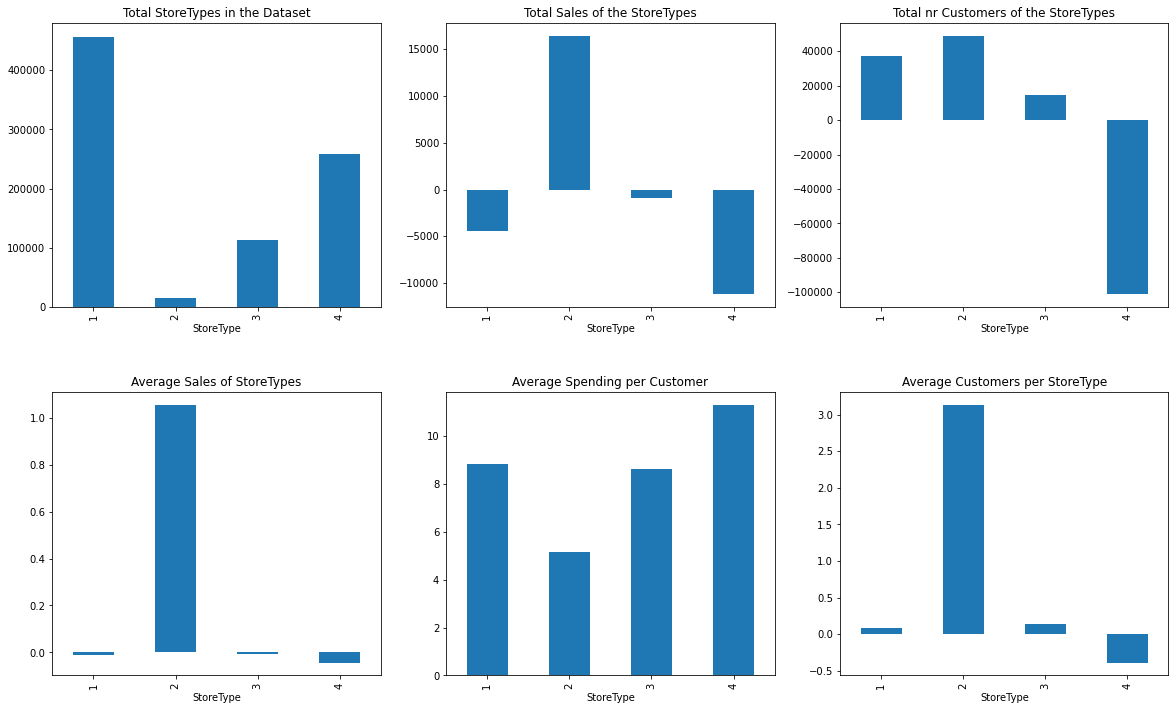

In [56]:
# Plot to observe the effect of StoreType on other fatures.

f, ax = plt.subplots(2, 3, figsize = (20, 12))

Merge.groupby("StoreType")["Store"].count().plot(kind = "bar", ax = ax[0, 0], title = "Total StoreTypes in the Dataset")
Merge.groupby("StoreType")["Sales"].sum().plot(kind = "bar", ax = ax[0, 1], title = "Total Sales of the StoreTypes")
Merge.groupby("StoreType")["Customers"].sum().plot(kind = "bar", ax = ax[0, 2], 
                                                            title = "Total nr Customers of the StoreTypes")
Merge.groupby("StoreType")["Sales"].mean().plot(kind = "bar", ax = ax[1, 0], title = "Average Sales of StoreTypes")
Merge.groupby("StoreType")["Sales/Customer"].mean().plot(kind = "bar", ax = ax[1, 1], 
                                                                      title = "Average Spending per Customer")
Merge.groupby("StoreType")["Customers"].mean().plot(kind = "bar", ax = ax[1, 2], 
                                                             title = "Average Customers per StoreType")

plt.subplots_adjust(hspace = 0.3)
plt.show()


1. <b>StoreType a</b> has the most stores, sales and customers. 
2.<b>StoreType d</b> has the best averages spendings per customers. 
3. <b>StoreType b</b>, with only 17 stores has the most average customers. 

### Lets look for Assortments

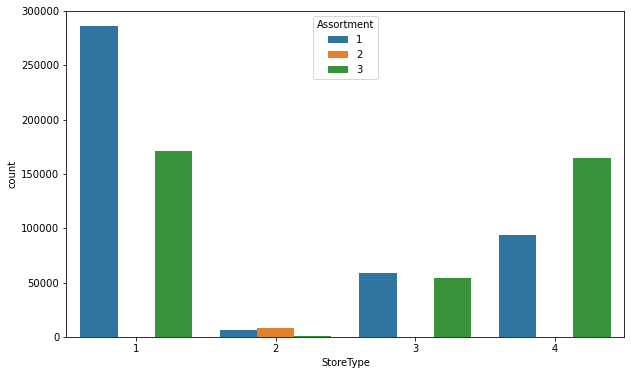

In [57]:
# PLot to observe the StoreType and Assortment.

plt.figure(figsize = (10, 6))
sns.countplot(data = Merge, x = "StoreType", hue = "Assortment") 
plt.show()

 
1. <b>StoreType b</b> has all assortments. That's why they are performing so good. Maybe this StoreType has more sales area.
2. <b>Assortment c</b> is a good one, because the <b>StoreType d</b> has the best average customer spending.

### Lets look for Promotions.

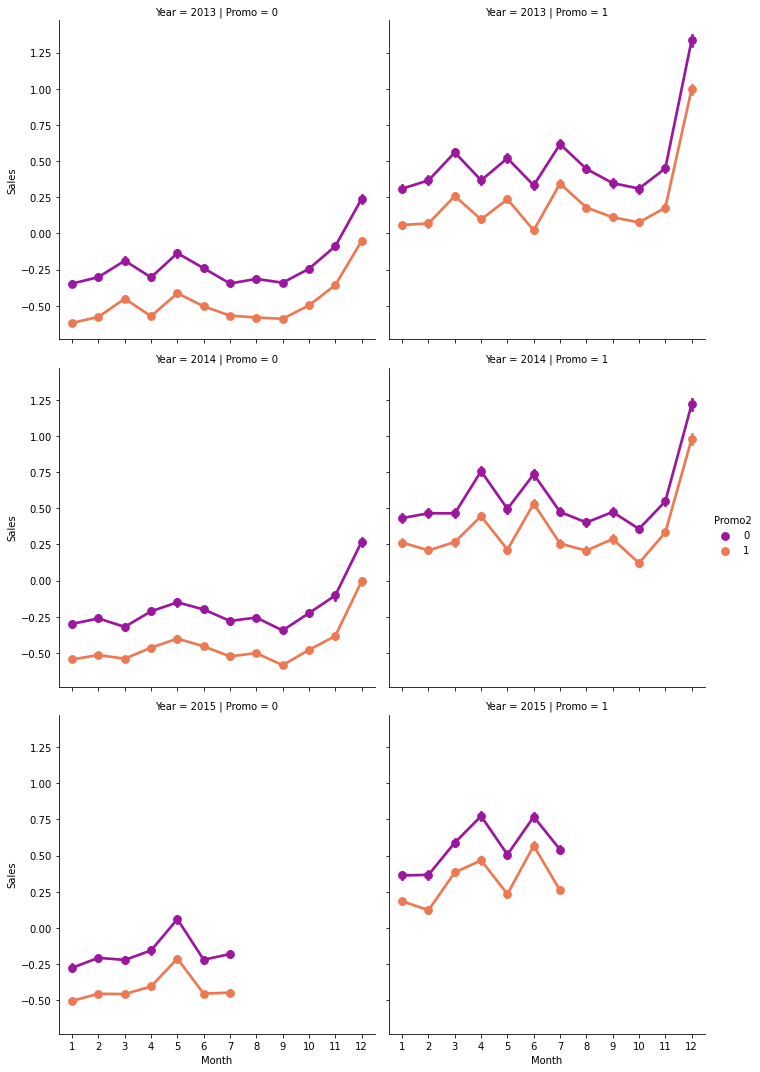

In [58]:
# Plot to examine effect of promotion1 and promotion2 on sales month wise. 

sns.factorplot(data = Merge, x = "Month", y = "Sales", col = "Promo", 
               palette = "plasma", hue = "Promo2", row = "Year") 
plt.show()


1. if the stores are having promotion the sells are higher.
2. Overall the store promotions sellings are also higher than the seasionality promotions (Promo2). However we can't see no yearly trend. 

### Lets see the trends on yearly basis.

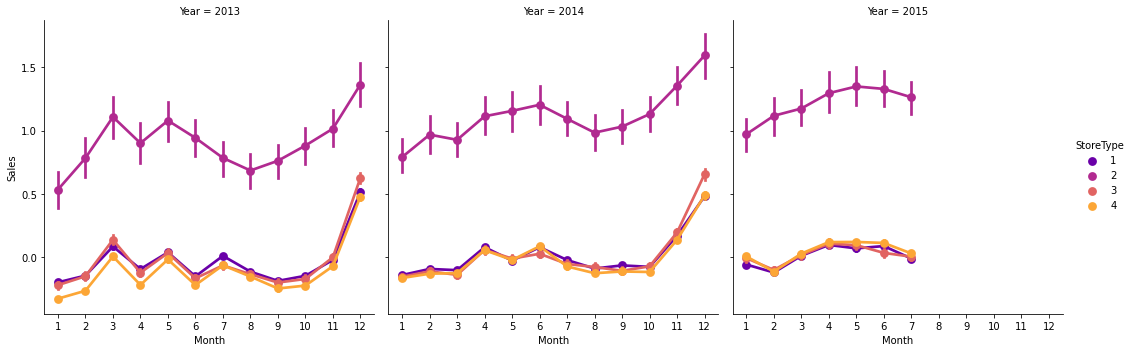

In [59]:
# Plot to examine seasonality and trend in sales yearly.

sns.factorplot(data = Merge, x = "Month", y = "Sales", col = "Year", 
               palette = "plasma", hue = "StoreType") 
plt.show()



1. We can see a seasonalities, but not trends. The sales stays constant yearly. 

### Lets see trend in monthly basis.

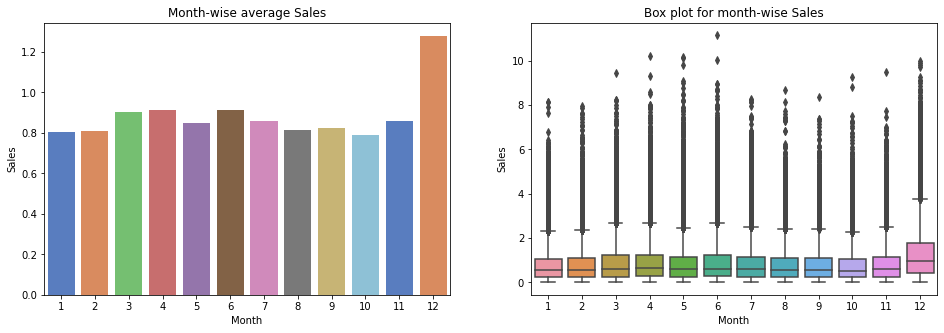

In [60]:
# look for monthly based average sales.

fig, (axis1,axis2) = plt.subplots(1, 2, figsize = (16, 5))
Mon_Avg_Sale = Merge[mask].groupby("Month")["Sales"].mean()

sns.barplot(x = Mon_Avg_Sale.index, y = Mon_Avg_Sale.values, ax = axis1, palette = "muted")
axis1.set_title("Month-wise average Sales")
axis1.set_ylabel("Sales")

Mon_Sale = Merge[(Merge.Sales > 0) & (Merge.Year != 2015)]
sns.boxplot(data = Merge[mask], x = "Month", y = "Sales", ax = axis2)
axis2.set_title("Box plot for month-wise Sales")
axis2.set_ylabel("Sales")
plt.show()


1. Maximum Sales occur during Nov and Dec. 
2. For other months the sales distribution is similar both in terms of median and variation. 
3. A slight increase in sales can be observed during the month of May.

### Correlation Analysis.

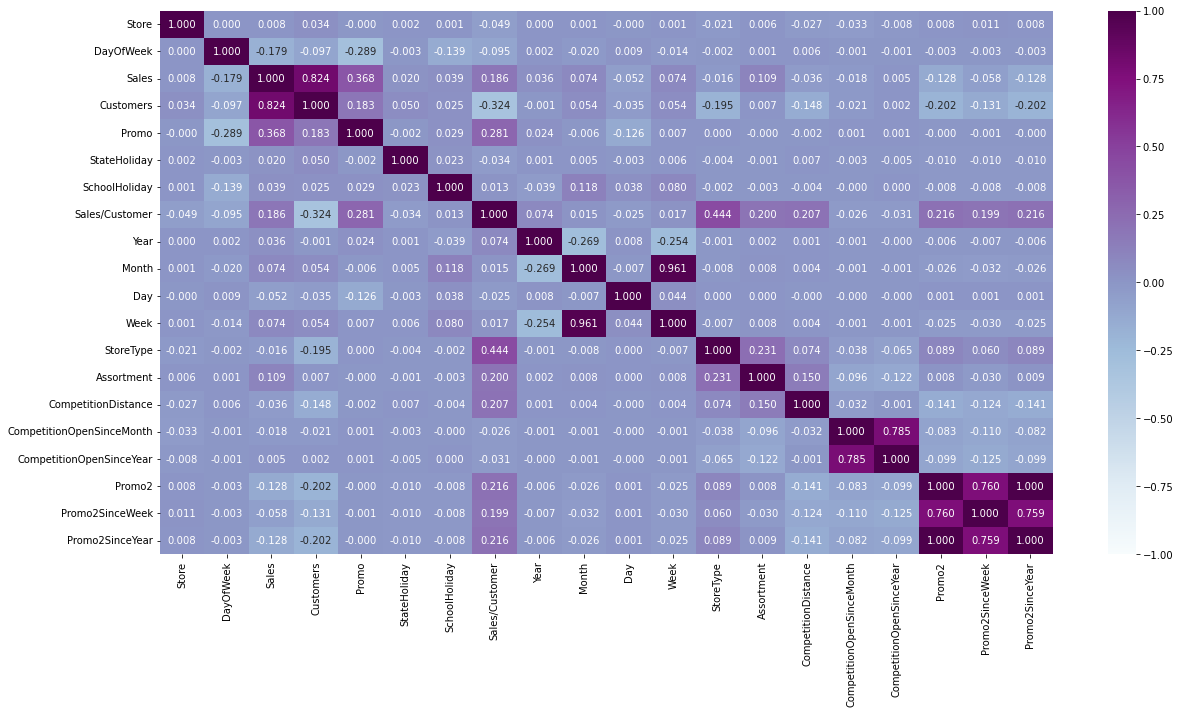

In [61]:
# examine correaltion between features.

plt.figure(figsize = (20, 10))
sns.heatmap(Merge.corr(), annot = True, vmin = -1, vmax = 1, fmt = ".3f", cmap ="BuPu")
plt.show()


1. From the above heatmap we can observe that "Sales" feature has high correlation with No. of customers and moderate correlation with promotion.

### Further analysis by looking at performance of different store type.

In these section we will closely anaylse the different levels of <b>StoreType</b> and how the main feature <b>Sales</b> is related with them.

In [62]:
# Group the data storetype wise to analyse the sales.

Merge.groupby("StoreType")["Sales"].describe()

count      mean       std       min       25%       50%  \
StoreType                                                               
1          457076.0 -0.009695  1.056121 -2.241099 -0.728282 -0.215954   
2           15563.0  1.055652  1.661743 -2.241099 -0.196944  0.700758   
3          112967.0 -0.007583  0.933247 -2.241099 -0.657394 -0.176644   
4          258766.0 -0.043055  0.823123 -2.241099 -0.613895 -0.180833   

                75%        max  
StoreType                       
1          0.467471  11.147410  
2          2.006871  10.235853  
3          0.449105   7.892035  
4          0.376283  10.015134


1. <b>StoreType b</b> has the highest average of Sales among all other stores. 

However we have much less data for it, So lets print an averall sum of Sales and Customers to see which StoreType is most selling and crowded one. 

In [63]:
# Print an averall sum of Sales and Customers to see which StoreType is most selling

Merge.groupby("StoreType")["Customers", "Sales"].sum()

Customers         Sales
StoreType                             
1           37164.812018  -4431.245983
2           48846.108157  16429.109171
3           14864.082213   -856.584570
4         -100875.002387 -11141.278618


1.<b>StoreType a</b> is the most selling and crowded one.
2. <b>StoreType d</b> goes on the second place in both sales and customers

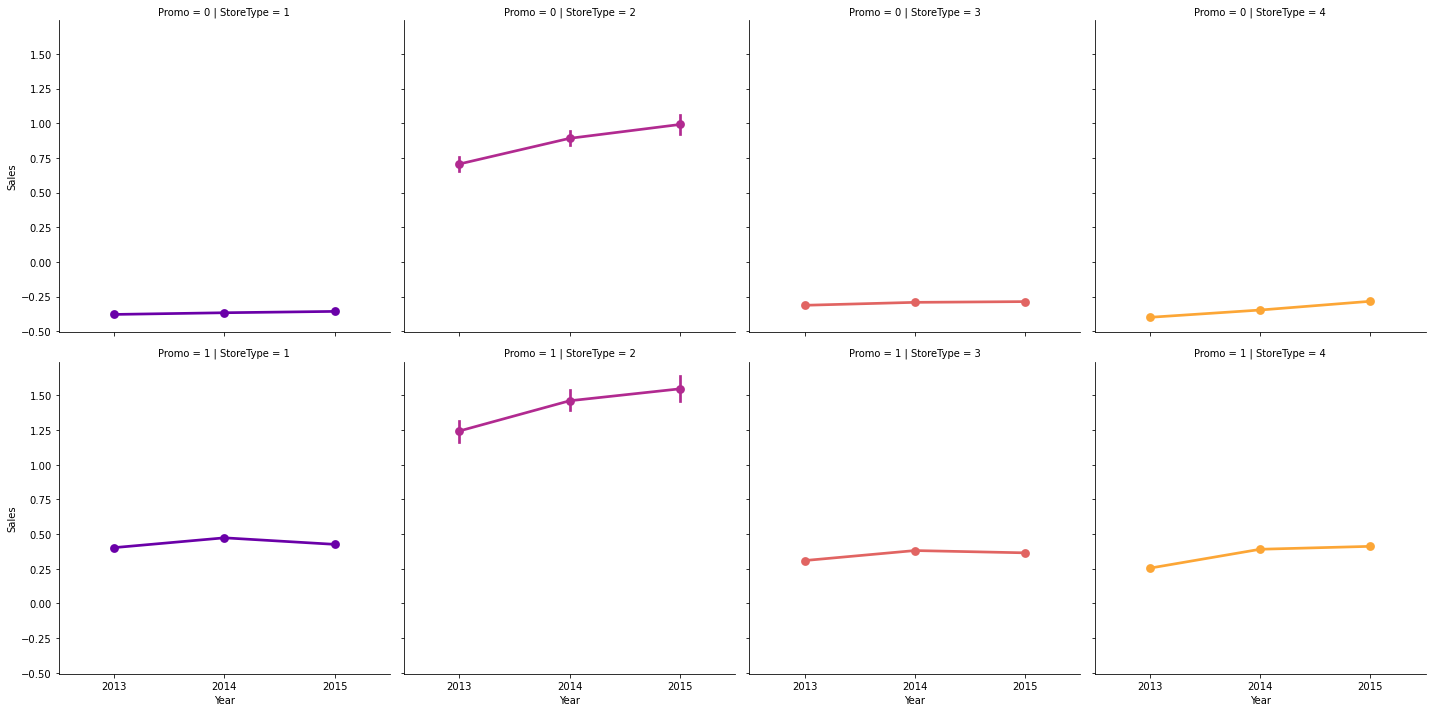

In [64]:
# Plot to see how's the daily sales yearly performances with and without the promotion for each store type.

sns.factorplot(data = Merge, x = "Year", y = "Sales", col = "StoreType", 
               palette = "plasma", hue = "StoreType", row = "Promo") 
plt.show()


1. In general, there were increases in sales when promotional activities were carried out. 
2. Nevertheless, the rate of increase seems to be stagnant from every year for store a,c and d. 
3. Store b shows highest yearly increase.

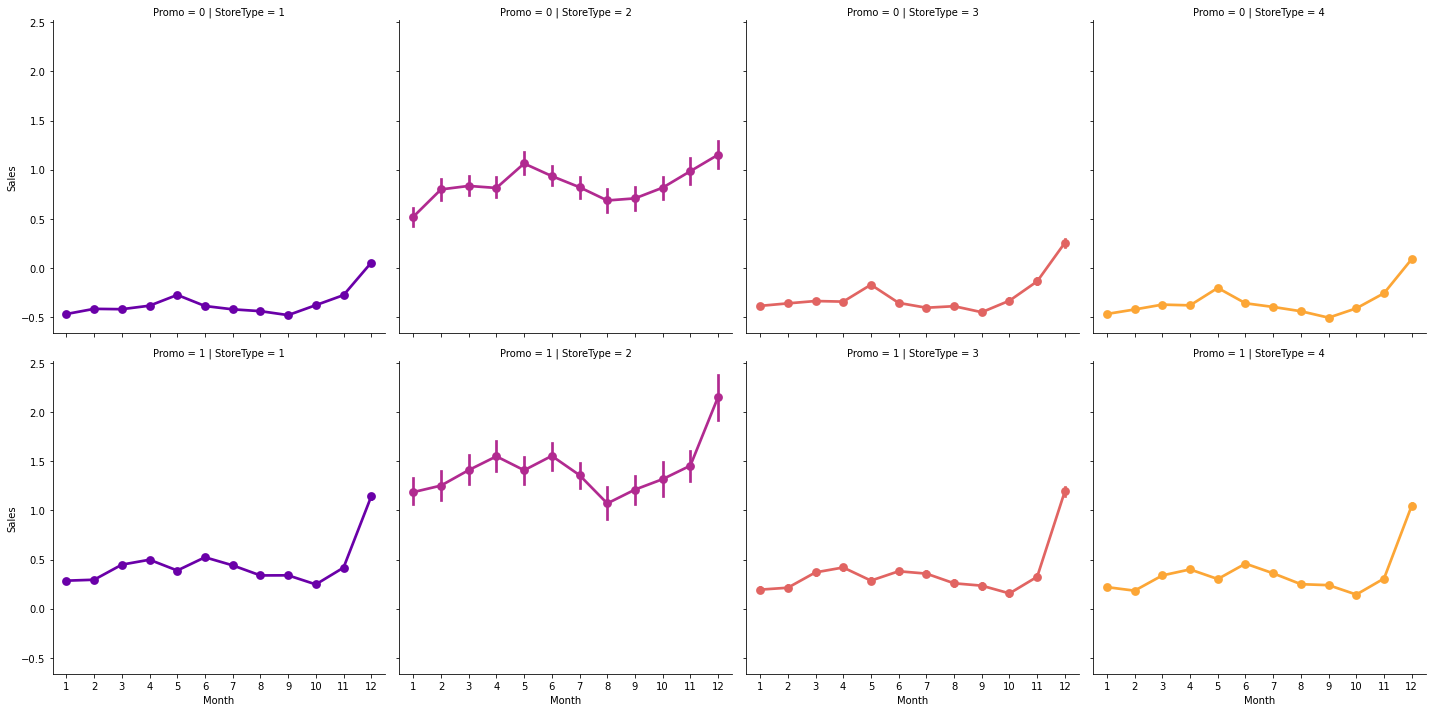

In [65]:
# Plot to observe sales and customers for store for month and week. 

sns.factorplot(data = Merge, x = "Month", y = "Sales", col = "StoreType", 
               palette = "plasma", hue = "StoreType", row = "Promo") 
plt.show()


1. As expected, December month shows the highest sales for the store with and without promotion.

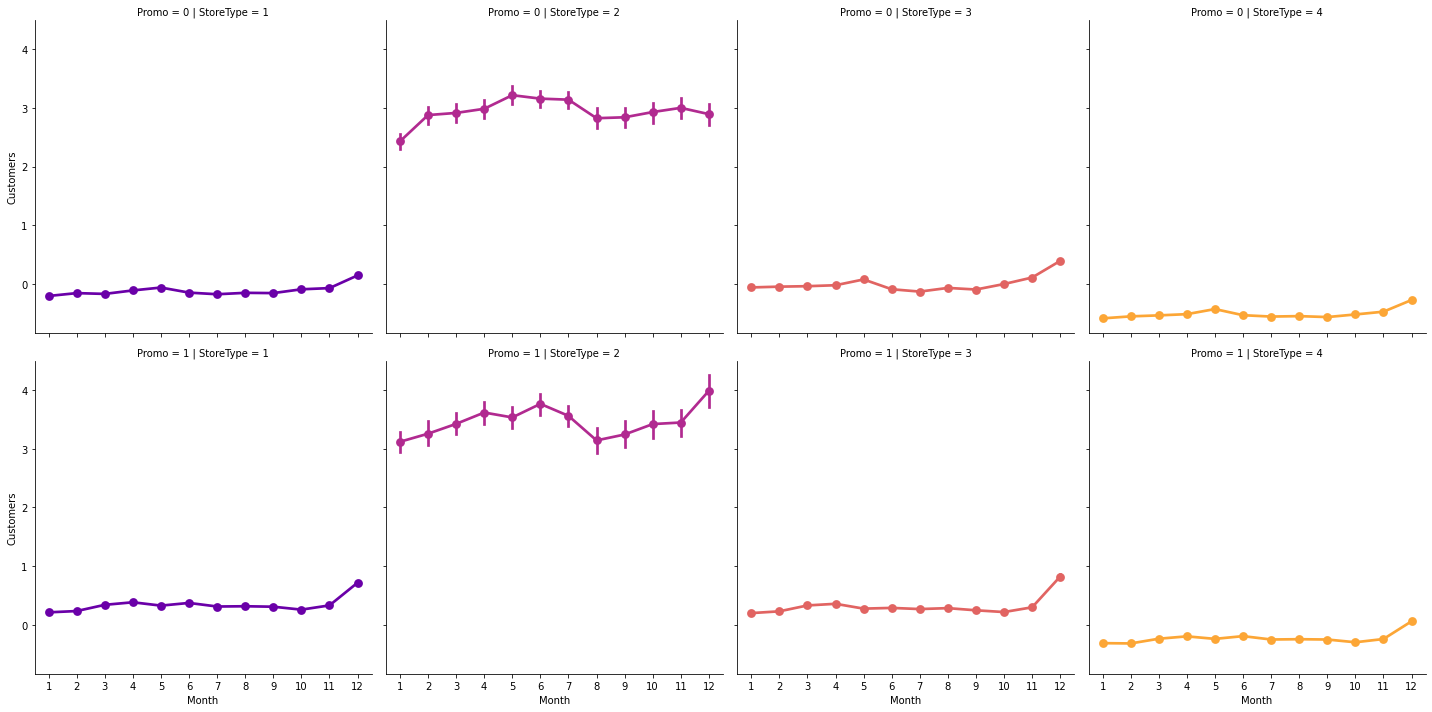

In [66]:
# Plot to observe the effect of promo and storetype on monthly customers.

sns.factorplot(data = Merge, x = "Month", y = "Customers", col = "StoreType", 
               palette = "plasma", hue = "StoreType", row = "Promo") 
plt.show()


All store types follow the same trend but at different scales depending on the presence of the (first) promotion <b>Promo</b> and <b>StoreType</b> itself - case for store type b.

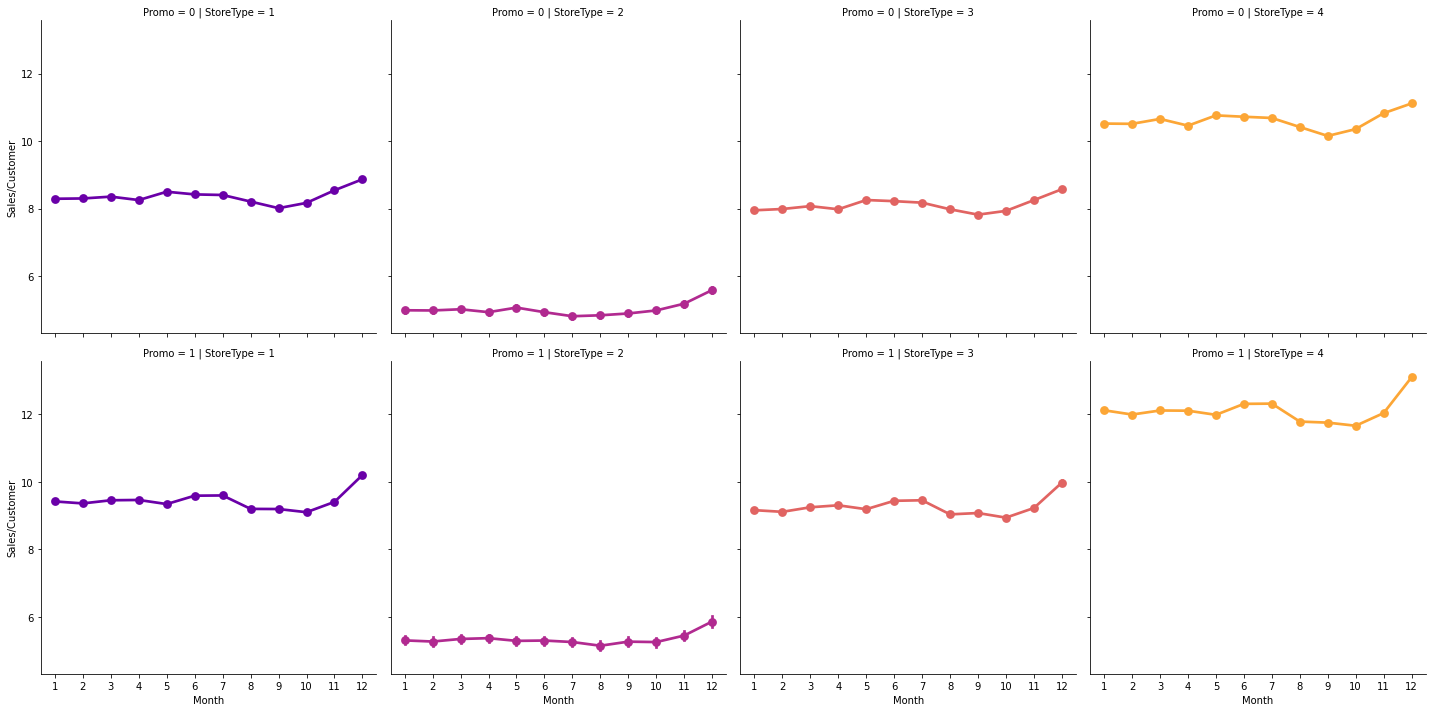

In [67]:
# Plot to observe the effect og storetype and promo on Sales/Customer.

sns.factorplot(data = Merge, x = "Month", y = "Sales/Customer", col = "StoreType", 
               palette = "plasma", hue = "StoreType", row = "Promo") 
plt.show()


Now eventhough the plots above showed <b>StoreType b</b> as the most selling and performant one, but it is not true.
The highest <b>Sales/Customer</b> amount is observed at the <b>StoreType d</b>, about 12 with <b>promo</b> and 10 without <b>promo</b>.
As for <b>StoreType a</b> and <b>StoreType c</b> it is about 9.
Low <b>SalePerCustomer</b> amount for <b>StoreType b</b> describes its Buyer Cart: there are a lot of people who shop essentially for small things (or in a little quantity). Plus we saw that overall this <b>StoreType</b> generated the least amount of sales and customers over the period.

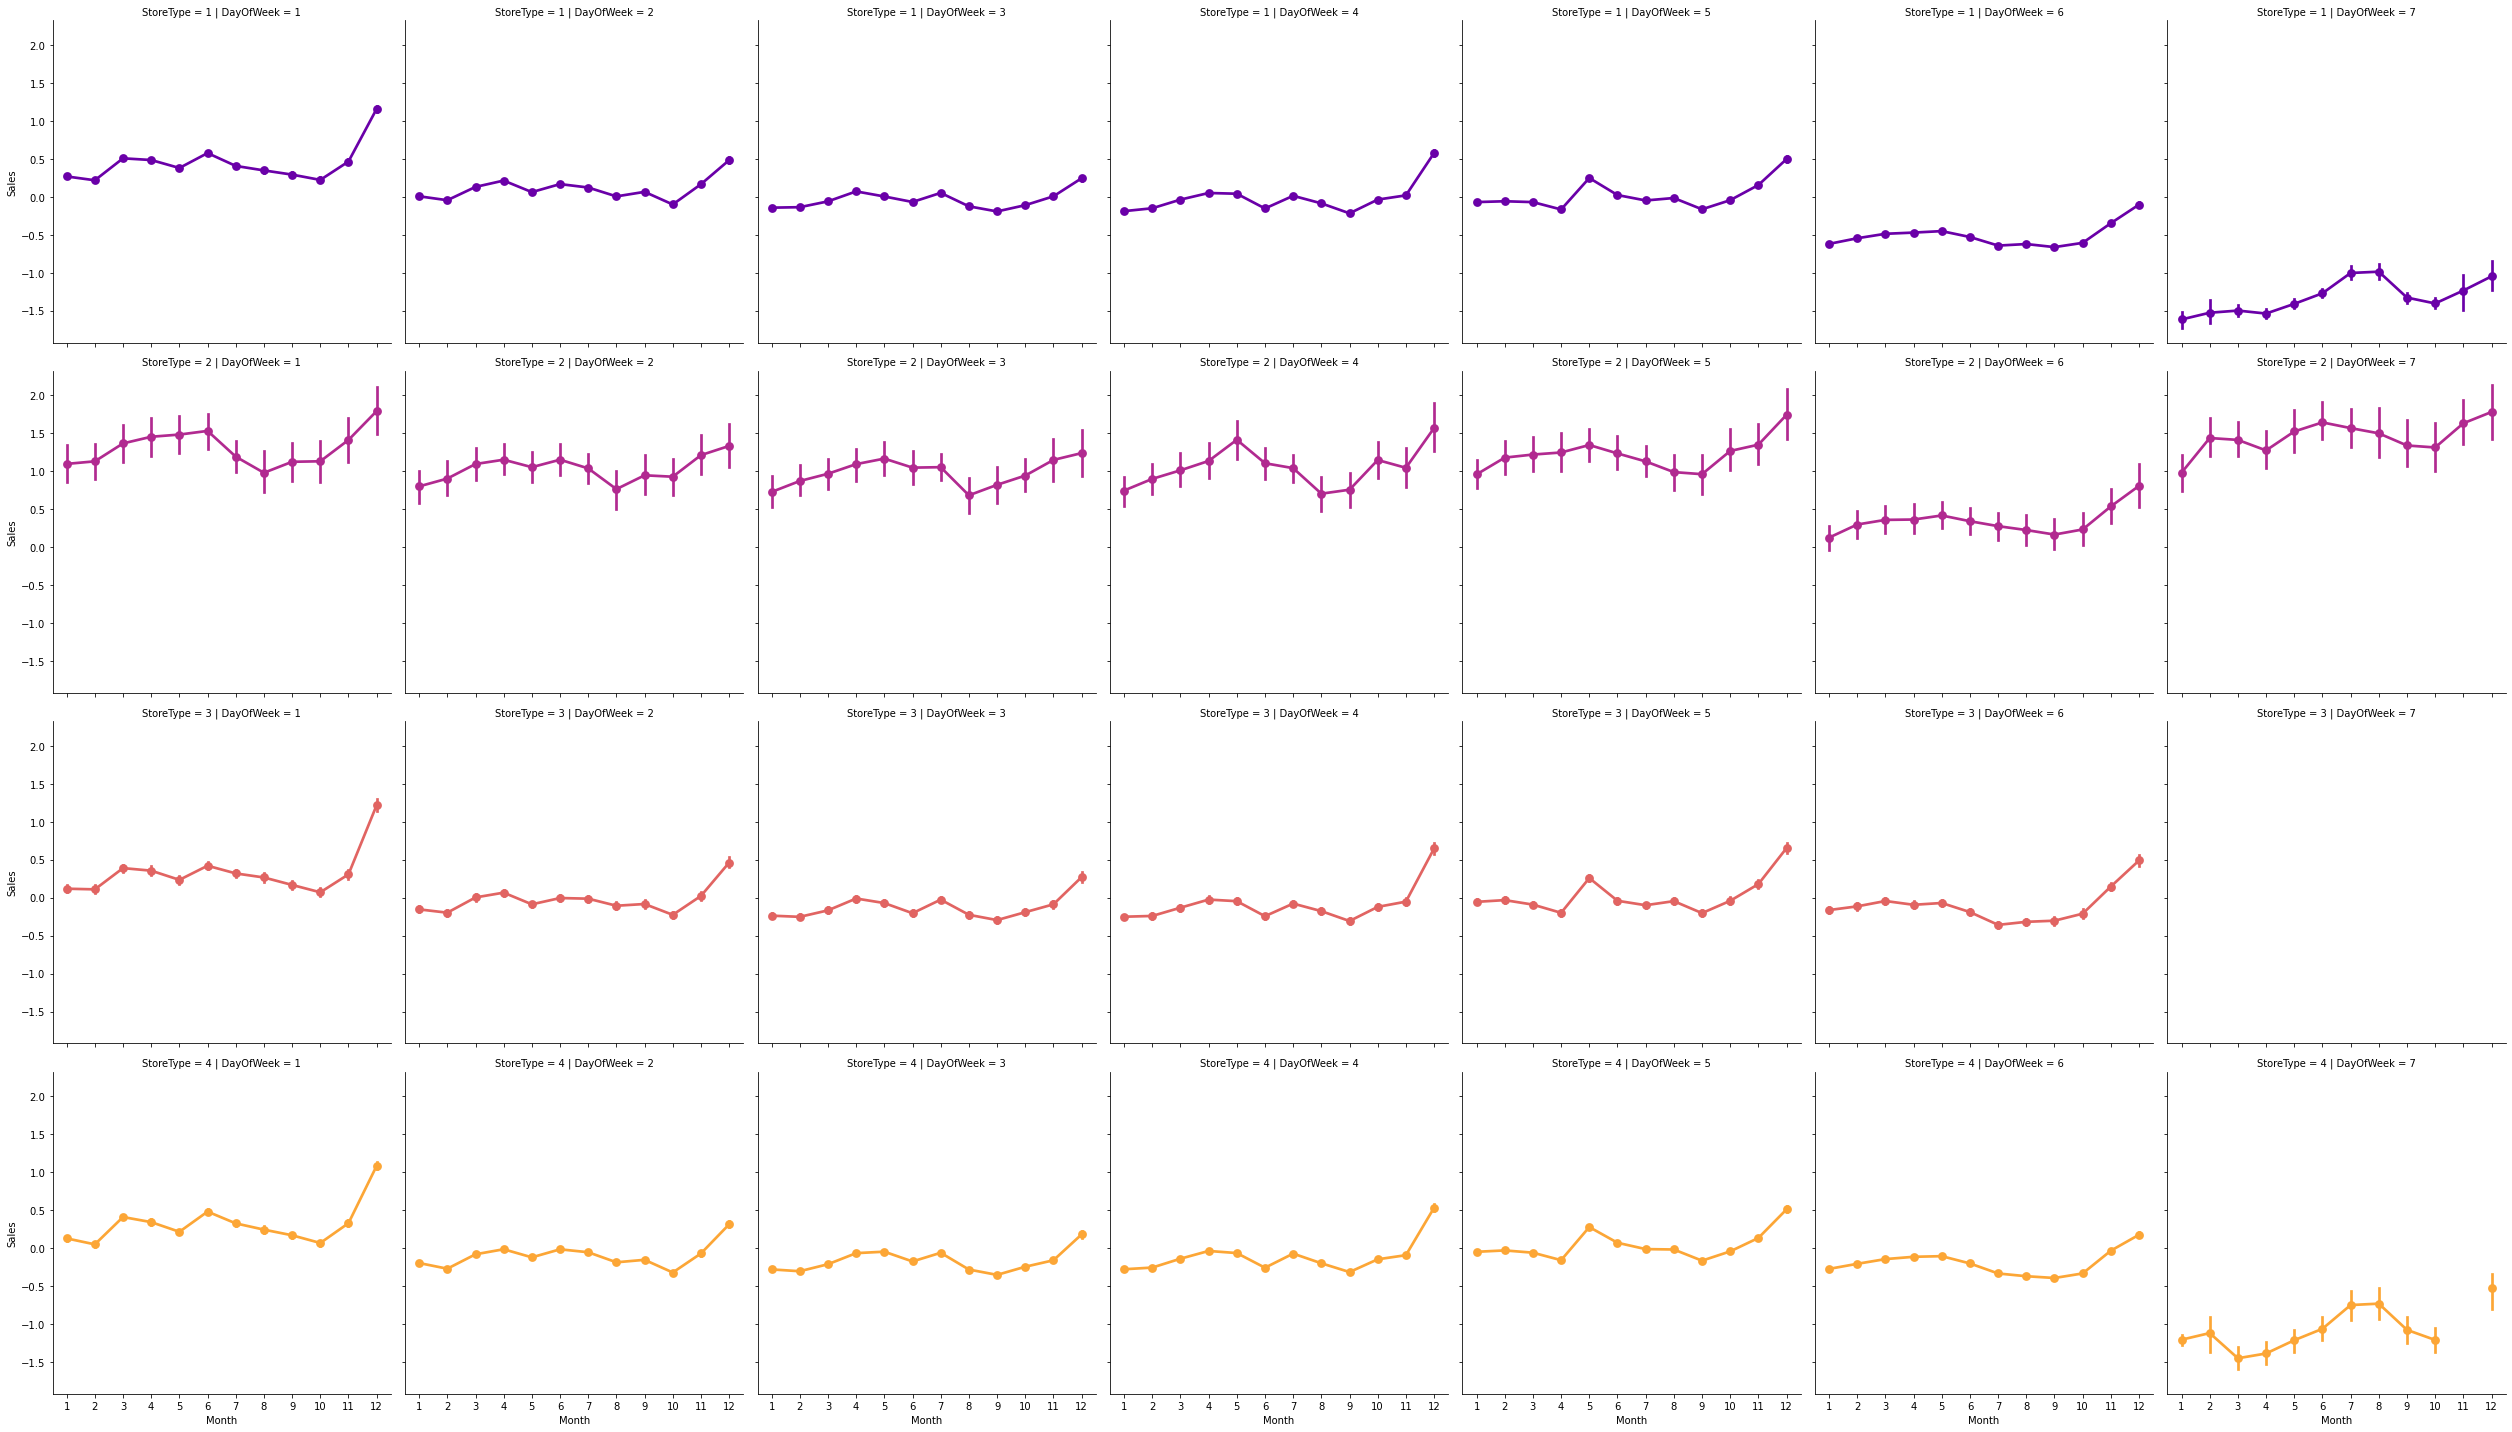

In [68]:
# Plot to observe the sales by day of week.

sns.factorplot(data = Merge, x = "Month", y = "Sales", col = "DayOfWeek", 
               palette = "plasma", hue = "StoreType", row = "StoreType") 
plt.show()


<b>StoreType c</b> are all closed on Sundays, whereas others are most of the time opened.
Interestingly enough, stores of <b>StoreType d</b> are closed on Sundays only from October to December.

In [69]:
# look for the Stores which are opened on Sundays.

Merge[(Merge.DayOfWeek == 7)]["Store"].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

Now, for further analysis we will add the variables describing the period of time during which competition and promotion are opened.

In [70]:
# look and add variable competition open time (in months).

Merge["Competition_Open"] = 12 * (Merge.Year - Merge.CompetitionOpenSinceYear) + \
                                          (Merge.Month - Merge.CompetitionOpenSinceMonth)


In [71]:
    
# For Promo open time.

Merge["PromoOpen"] = 12 * (Merge.Year - Merge.Promo2SinceYear) + \
                                   (Merge.Week - Merge.Promo2SinceWeek) / 4.0


In [72]:

# For Average PromoOpen time and CompetitionOpen time per store type.

Merge.loc[:, ["StoreType", "Sales", "Customers", "PromoOpen", "Competition_Open"]].groupby("StoreType").mean()

Sales  Customers     PromoOpen  Competition_Open
StoreType                                                     
1         -0.009695   0.081310  12917.743611       7115.675023
2          1.055652   3.138605  17199.117249      11366.961576
3         -0.007583   0.131579  12159.813600       6745.691166
4         -0.043055  -0.389831  10422.276992       9028.784083

In [73]:
# look for columns in dataset.

Merge.head()

Store  DayOfWeek     Sales  Customers  Promo  StateHoliday  SchoolHoliday  \
0      1          5 -0.545262  -0.517815      1             0              1   
1      1          4 -0.623561  -0.540250      1             0              1   
2      1          3 -0.700249  -0.597583      1             0              1   
3      1          2 -0.626461  -0.505351      1             0              1   
4      1          1 -0.274920  -0.375728      1             0              1   

   Sales/Customer  Year  Month  Day  Week  StoreType  Assortment  \
0        9.482883  2015      7   31    31          3           1   
1        9.194139  2015      7   30    31          3           1   
2        9.143403  2015      7   29    31          3           1   
3        8.948214  2015      7   28    31          3           1   
4        9.970588  2015      7   27    31          3           1   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        9.0                    2008.0   
1               1270.0                        9.0                    2008.0   
2               1270.0                        9.0                    2008.0   
3               1270.0                        9.0                    2008.0   
4               1270.0                        9.0                    2008.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval      index  \
0       0              0.0              0.0             0 2015-07-31   
1       0              0.0              0.0             0 2015-07-30   
2       0              0.0              0.0             0 2015-07-29   
3       0              0.0              0.0             0 2015-07-28   
4       0              0.0              0.0             0 2015-07-27   

   Competition_Open  PromoOpen  
0              82.0   24187.75  
1              82.0   24187.75  
2              82.0   24187.75  
3              82.0   24187.75  
4              82.0   24187.75


The most selling and crowded <b>StoreType a</b>  doesn't appear to be the one the most exposed to competitors. Instead it's a <b>StoreType b</b>, which also has the longest running period of promotion.

### Correlation Analysis.

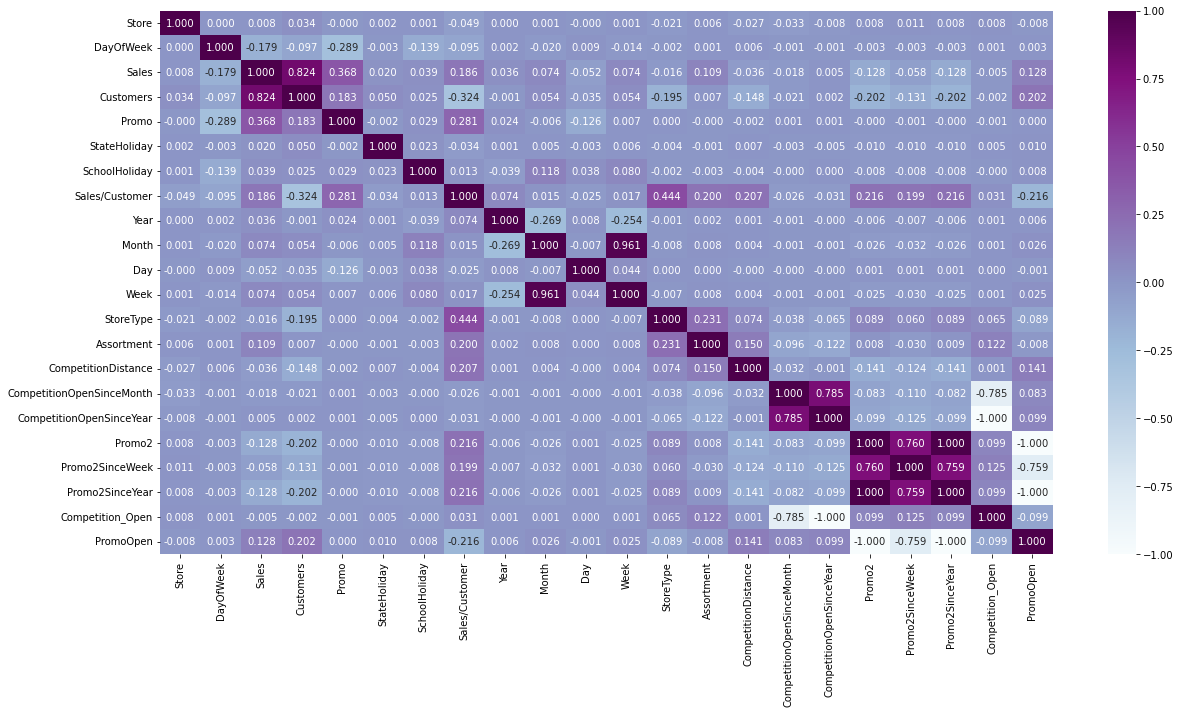

In [74]:
# Plot to examine correlation between dataset features.

plt.figure(figsize = (20, 10))
sns.heatmap(Merge.corr(), annot = True, vmin = -1, vmax = 1, fmt = ".3f", cmap ="BuPu")
plt.show()


We can also observe the correlation between the fact that the store had a running promotion (<b>Promo</b> = 1) and amount of Customers.
However, as soon as the store continues a consecutive promotion (<b>Promo2</b> = 1) the number of <b>Customers</b> and <b>Sales</b> seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. 
The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

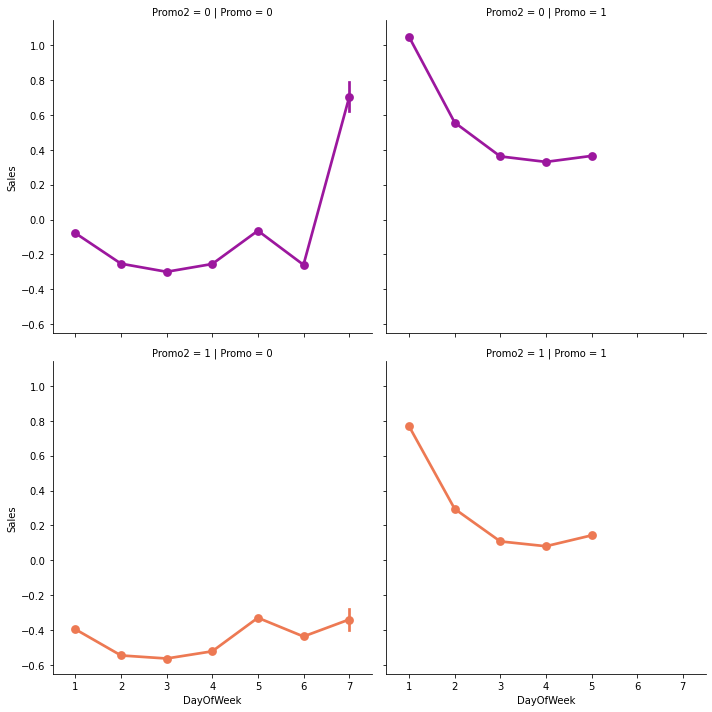

In [75]:
# Plot to observe the sales and effect of promo and promo2 on sales by DayOfWeek.

sns.factorplot(data = Merge, x = "DayOfWeek", y = "Sales", col = "Promo", 
               palette = "plasma", hue = "Promo2", row = "Promo2") 
plt.show()


 In case of no promotion, both <b>Promo</b> and <b>Promo2</b> are equal to 0, <b>Sales</b> tend to peak on Sunday. Though we should note that <b>StoreType c</b> doesn't work on Sundays. So it is mainly data from <b>StoreType a, b</b> and <b>c</b>.
On the contrary, stores that run the promotion tend to make most of the <b>Sales</b> on <b>Monday</b>. This fact could be a good indicator for Rossmann marketing campaigns. 
The same trend follow the stores which have both promotion at the same time (<b>Promo</b> and <b>Promo2</b> are equal to 1).
<b>Promo2</b> alone doesn't seem to be correlated to any significant change in the <b>Sales</b> amount.

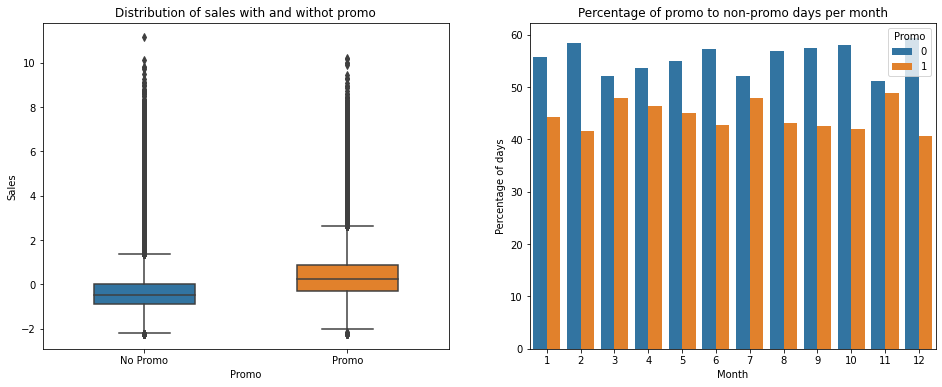

In [76]:
# look for average sales & customers with/without promo.

fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (16, 6))
sns.boxplot(x = "Promo", y = "Sales", data = Merge, ax = axis1, width = 0.5)
axis1.set_xticks([0, 1])
axis1.set_xticklabels(["No Promo", "Promo"])
axis1.set_title("Distribution of sales with and withot promo")

Mon_Promo = (Merge.groupby(["Month"])["Promo"].value_counts(normalize = True).rename("Percentage of days").mul(100).reset_index().sort_values("Month"))

sns.barplot(x = "Month", y = "Percentage of days", hue = "Promo", data = Mon_Promo, ax = axis2)
axis2.set_title("Percentage of promo to non-promo days per month")
plt.show()


1. Clearly sales is higher when there is promotions are given in a store. 
2. If we take a look a at the how the promotions are distributed over the months, we find that in any month (on an average) around 30-40% of the days (i.e. 10-12 days per month) the stores run promtional offers. 
3. However, it is higher for March, July and November and significantly lower in December.
4. This could be a strategy to even out sales over the months. 
5. The stores might increase promotion duration when the sales go down or to clear inventory before new sales cycle begins.

### Lets look for StateHoliday.

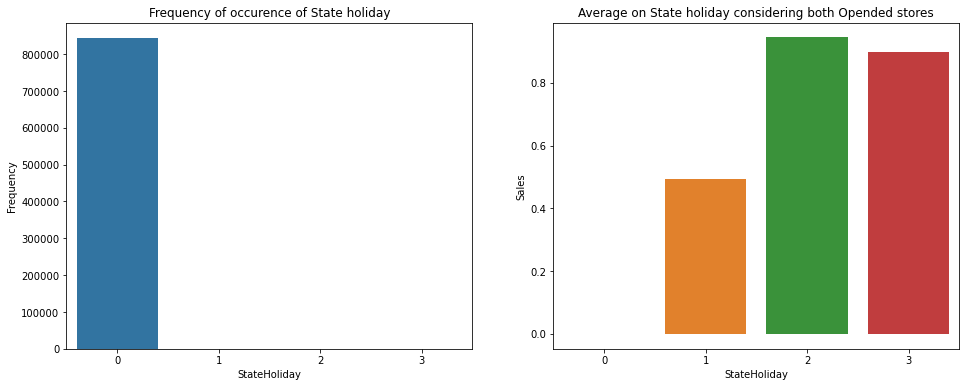

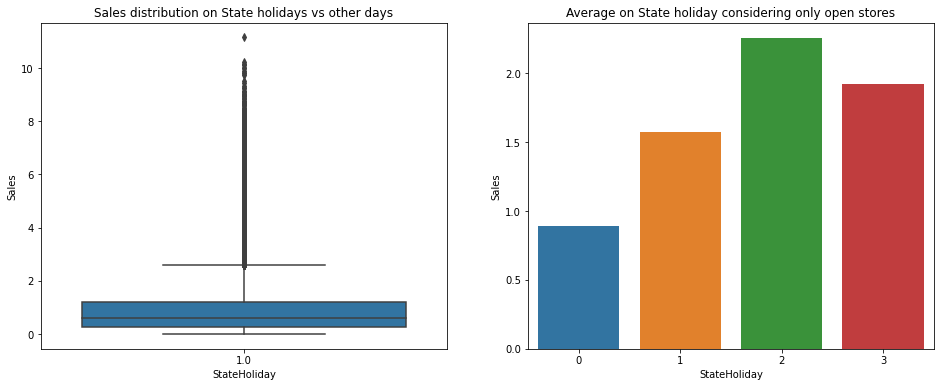

In [77]:
# examine stats for StateHoliday feature.

fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (16, 6))
fig, (axis3, axis4) = plt.subplots(1, 2, figsize = (16, 6))
#Merge["StateHoliday"].loc[Merge["StateHoliday"] == 0] = "0"
SH_Df = Merge.groupby("StateHoliday")["index"].count()
sns.barplot(SH_Df.index, SH_Df.values, ax = axis1)
axis1.set_ylabel("Frequency")
axis1.set_title("Frequency of occurence of State holiday")


SH_Df_Sale = Merge.groupby("StateHoliday")["Sales"].mean()
sns.barplot(x = SH_Df_Sale.index, y = SH_Df_Sale.values, ax = axis2)
axis2.set_title("Average on State holiday considering both Opended stores")
axis2.set_ylabel("Sales")

mask = Merge["Sales"] > 0
train_full_copy = Merge.copy()
train_full_copy["StateHoliday"] = Merge[mask]["StateHoliday"].apply(lambda x : 0 if x == "0" else 1)
sns.boxplot(x = "StateHoliday", y = "Sales", data = train_full_copy, ax = axis3)
axis3.set_title("Sales distribution on State holidays vs other days")

SH_Df_Sale = Merge[mask].groupby("StateHoliday")["Sales"].mean()
sns.barplot(x = SH_Df_Sale.index, y = SH_Df_Sale.values, ax = axis4)
axis4.set_ylabel("Sales")
axis4.set_title("Average on State holiday considering only open stores")
plt.show()


1. The number of state holidays of type 'a' are most frequent while type 'c' are least frequent.
2. Average sales on a state holidays are significantly less than other days. Further, it is lowest on a 'c' type state holiday as per the second graph.
3. But this data is potentially misleading. Beacuse when we consider only the stores open during a state holidays, the median sales is higher than a normal day.
4. Actually we can see that on all types of state holidays the average sales is higher than other days but as some of the stores remain closed on state holidays the second graph tells a deifferent story.

### Lets look for SchoolHoliday feature. 

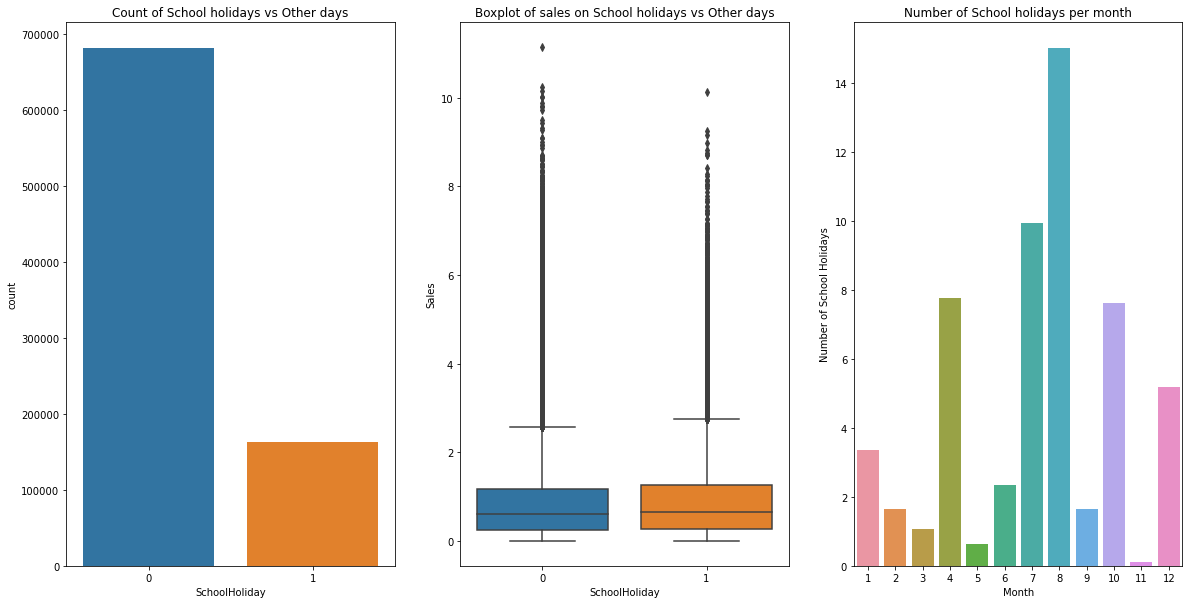

In [78]:
# look for the SchoolHoliday feature.

fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (20, 10))
sns.countplot(x = "SchoolHoliday", data = Merge, ax = axis1)
axis1.set_title("Count of School holidays vs Other days")
mask = Merge["Sales"] > 0
SchHol = Merge[mask]

sns.boxplot(data = SchHol, x = "SchoolHoliday", y = "Sales", ax = axis2)
axis2.set_title("Boxplot of sales on School holidays vs Other days")

SchHol_Data = (Merge[(Merge["SchoolHoliday"] == 1) & (Merge["Year"] == 2014)].groupby("Month")["SchoolHoliday"].value_counts().div(1115).rename("Number of School Holidays").reset_index().sort_values('Month'))
sns.barplot(x = "Month", y = "Number of School Holidays", data = SchHol_Data, ax = axis3)
axis3.set_title("Number of School holidays per month")
plt.show()


1. Sales on school holidays are very similar to other days. The median value on school holidays is slightly higher.
2. The last plot shows how the school holidays are distributed over the months for a particular year. 
3. The Months of July and August are summer holidays for school. 
4. There are also a winter break which is reflected by number of holidays in December. 
5. Apart from that there are some holidays in March and October. This is important because our test data lies in August and September.

In [79]:
# Drop unecessary columns.

Merge.drop(["PromoInterval"], axis = 1, inplace = True)

## Step 5 : Lets split the data for each store.

In [80]:
# examine dataset and assign the date column as index of dataset.

Merge.set_index("index", inplace = True)
Merge.head()

Store  DayOfWeek     Sales  Customers  Promo  StateHoliday  \
index                                                                    
2015-07-31      1          5 -0.545262  -0.517815      1             0   
2015-07-30      1          4 -0.623561  -0.540250      1             0   
2015-07-29      1          3 -0.700249  -0.597583      1             0   
2015-07-28      1          2 -0.626461  -0.505351      1             0   
2015-07-27      1          1 -0.274920  -0.375728      1             0   

            SchoolHoliday  Sales/Customer  Year  Month  Day  Week  StoreType  \
index                                                                          
2015-07-31              1        9.482883  2015      7   31    31          3   
2015-07-30              1        9.194139  2015      7   30    31          3   
2015-07-29              1        9.143403  2015      7   29    31          3   
2015-07-28              1        8.948214  2015      7   28    31          3   
2015-07-27              1        9.970588  2015      7   27    31          3   

            Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
index                                                                    
2015-07-31           1               1270.0                        9.0   
2015-07-30           1               1270.0                        9.0   
2015-07-29           1               1270.0                        9.0   
2015-07-28           1               1270.0                        9.0   
2015-07-27           1               1270.0                        9.0   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
index                                                           
2015-07-31                    2008.0       0              0.0   
2015-07-30                    2008.0       0              0.0   
2015-07-29                    2008.0       0              0.0   
2015-07-28                    2008.0       0              0.0   
2015-07-27                    2008.0       0              0.0   

            Promo2SinceYear  Competition_Open  PromoOpen  
index                                                     
2015-07-31              0.0              82.0   24187.75  
2015-07-30              0.0              82.0   24187.75  
2015-07-29              0.0              82.0   24187.75  
2015-07-28              0.0              82.0   24187.75  
2015-07-27              0.0              82.0   24187.75

In [81]:
# Sort the data according to Date.

Merge.sort_values(by = ["Store", "index"], inplace = True, ascending = True)
Merge.head(100)

Store  DayOfWeek     Sales  Customers  Promo  StateHoliday  \
index                                                                    
2013-01-02      1          3 -0.459230  -0.236134      0             0   
2013-01-03      1          4 -0.846859  -0.460482      0             0   
2013-01-04      1          5 -0.795626  -0.358279      0             0   
2013-01-05      1          6 -0.630972  -0.318395      0             0   
2013-01-07      1          1  0.071142   0.055517      1             0   
2013-01-08      1          2 -0.443119  -0.271033      1             0   
2013-01-09      1          3 -0.478240  -0.340830      1             0   
2013-01-10      1          4 -0.664805  -0.368250      1             0   
2013-01-11      1          5 -0.668350  -0.425583      1             0   
2013-01-12      1          6 -0.645472  -0.290975      0             0   
2013-01-14      1          1 -0.721193  -0.365757      0             0   
2013-01-15      1          2 -0.984446  -0.625003      0             0   
2013-01-16      1          3 -0.949646  -0.580134      0             0   
2013-01-17      1          4 -0.938047  -0.647438      0             0   
2013-01-18      1          5 -0.911302  -0.485409      0             0   
2013-01-19      1          6 -0.571362  -0.186279      0             0   
2013-01-21      1          1 -0.503051  -0.388192      1             0   
2013-01-22      1          2 -0.398008  -0.238627      1             0   
2013-01-23      1          3 -0.443763  -0.338337      1             0   
2013-01-24      1          4 -0.567173  -0.293468      1             0   
2013-01-25      1          5 -0.441185  -0.216192      1             0   
2013-01-26      1          6 -0.437319  -0.305931      0             0   
2013-01-28      1          1 -0.934502  -0.532771      0             0   
2013-01-29      1          2 -1.040834  -0.600076      0             0   
2013-01-30      1          3 -0.758571  -0.505351      0             0   
2013-01-31      1          4 -0.723771  -0.477931      0             0   
2013-02-01      1          5 -0.426041  -0.261062      0             0   
2013-02-02      1          6 -0.317453  -0.153874      0             0   
2013-02-04      1          1  0.024743  -0.001816      1             0   
2013-02-05      1          2 -0.291998  -0.211207      1             0   
2013-02-06      1          3 -0.262676  -0.173816      1             0   
2013-02-07      1          4 -0.469218  -0.218685      1             0   
2013-02-08      1          5 -0.410575  -0.330859      1             0   
2013-02-09      1          6 -0.510785  -0.266047      0             0   
2013-02-11      1          1 -0.820437  -0.408134      0             0   
2013-02-12      1          2 -0.947391  -0.475438      0             0   
2013-02-13      1          3 -0.871025  -0.395670      0             0   
2013-02-14      1          4 -0.874569  -0.472945      0             0   
2013-02-15      1          5 -0.691549  -0.388192      0             0   
2013-02-16      1          6 -0.258165  -0.201236      0             0   
2013-02-18      1          1 -0.176644  -0.131439      1             0   
2013-02-19      1          2 -0.505629  -0.385699      1             0   
2013-02-20      1          3 -0.417341  -0.196250      1             0   
2013-02-21      1          4 -0.545906  -0.333352      1             0   
2013-02-22      1          5 -0.630005  -0.408134      1             0   
2013-02-23      1          6 -0.553640  -0.281004      0             0   
2013-02-25      1          1 -0.939980  -0.570163      0             0   
2013-02-26      1          2 -1.018601  -0.592597      0             0   
2013-02-27      1          3 -0.772426  -0.457989      0             0   
2013-02-28      1          4 -0.734404  -0.453003      0             0   
2013-03-01      1          5 -0.755349  -0.445525      0             0   
2013-03-02      1          6 -0.517229  -0.211207      0             0   
2013-03-04      

In [82]:
# examine data after sorting and indexing.

Merge.head(5).append(Merge.tail(5))

Store  DayOfWeek     Sales  Customers  Promo  StateHoliday  \
index                                                                    
2013-01-02      1          3 -0.459230  -0.236134      0             0   
2013-01-03      1          4 -0.846859  -0.460482      0             0   
2013-01-04      1          5 -0.795626  -0.358279      0             0   
2013-01-05      1          6 -0.630972  -0.318395      0             0   
2013-01-07      1          1  0.071142   0.055517      1             0   
2015-07-27   1115          1  1.210508  -0.385699      1             0   
2015-07-28   1115          2  0.366617  -0.654916      1             0   
2015-07-29   1115          3  0.227418  -0.722220      1             0   
2015-07-30   1115          4  0.467149  -0.649931      1             0   
2015-07-31   1115          5  0.555759  -0.560192      1             0   

            SchoolHoliday  Sales/Customer  Year  Month  Day  Week  StoreType  \
index                                                                          
2013-01-02              1        8.278443  2013      1    2     1          3   
2013-01-03              1        7.486159  2013      1    3     1          3   
2013-01-04              1        7.247173  2013      1    4     1          3   
2013-01-05              1        7.869291  2013      1    5     1          3   
2013-01-07              1        9.141401  2013      1    7     2          3   
2015-07-27              1       17.618421  2015      7   27    31          4   
2015-07-28              1       16.186000  2015      7   28    31          4   
2015-07-29              1       16.196617  2015      7   29    31          4   
2015-07-30              1       16.743028  2015      7   30    31          4   
2015-07-31              1       16.133829  2015      7   31    31          4   

            Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
index                                                                    
2013-01-02           1               1270.0                        9.0   
2013-01-03           1               1270.0                        9.0   
2013-01-04           1               1270.0                        9.0   
2013-01-05           1               1270.0                        9.0   
2013-01-07           1               1270.0                        9.0   
2015-07-27           3               5350.0                        0.0   
2015-07-28           3               5350.0                        0.0   
2015-07-29           3               5350.0                        0.0   
2015-07-30           3               5350.0                        0.0   
2015-07-31           3               5350.0                        0.0   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
index                                                           
2013-01-02                    2008.0       0              0.0   
2013-01-03                    2008.0       0              0.0   
2013-01-04                    2008.0       0              0.0   
2013-01-05                    2008.0       0              0.0   
2013-01-07                    2008.0       0              0.0   
2015-07-27                       0.0       1             22.0   
2015-07-28                       0.0       1             22.0   
2015-07-29                       0.0       1             22.0   
2015-07-30                       0.0       1             22.0   
2015-07-31                       0.0       1             22.0   

            Promo2SinceYear  Competition_Open  PromoOpen  
index                                                     
2013-01-02              0.0              52.0   24156.25  
2013-01-03              0.0              52.0   24156.25  
2013-01-04              0.0              52.0   24156.25  
2013-01-05              0.0              52.0   24156.25  
2013-01-07              0.0              52.0   24156.50  
2015-07-27           2012.0           24187.0      38.25  
2015-07-28          

In [83]:
# Split the data for store no. 1,3,8,9,13,25,29,31,46.

Store1 = Merge[Merge.Store == 1]
Store3 = Merge[Merge.Store == 3]
Store8 = Merge[Merge.Store == 8]
Store9 = Merge[Merge.Store == 9]
Store13 = Merge[Merge.Store == 13]
Store25 = Merge[Merge.Store == 25]
Store29 = Merge[Merge.Store == 29]
Store31 = Merge[Merge.Store == 31]
Store46 = Merge[Merge.Store == 46]

## Step 6 : Model Building.

### 6.1. Model for Store No. 1.

### Model 1.

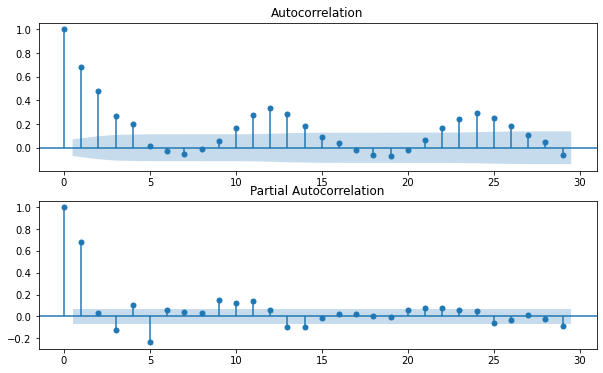

In [84]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(Store1.Sales, ax = ax[0])
ax[1] = plot_pacf(Store1.Sales, ax = ax[1])

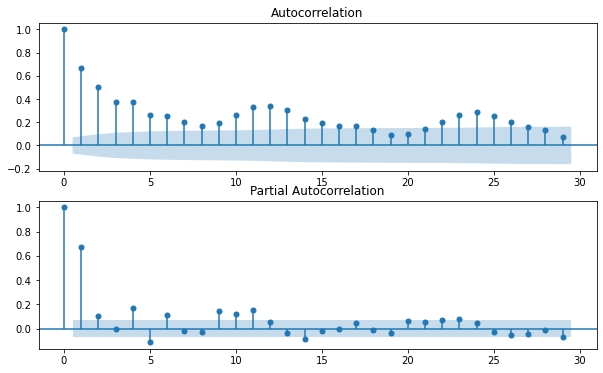

In [85]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store1.Customers, ax = ax[0])
ax[1] = plot_pacf(Store1.Customers, ax = ax[1])

In [86]:
# Performing the Augmented Dickey-Fuller test to look wheather the data is stationary or not.

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """ Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistics':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    # Print Summary
    print(f'   Augmented Dickey-Fuller Test on "{name}"', "\n  ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance level   = {signif}')
    print(f' Test Statistics      = {output["test_statistics"]}')
    print(f' No. Lags Chosen      = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f' Critical value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
          print(f" => Series is Stationary.")
          
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series in Non-Stationary.")

In [87]:
# Use the adfuller_test function on data.

for name, column in Store1.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.683
 No. Lags Chosen      = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance lev


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [88]:
# look for the columns which have same value in all its rows.

Store1.nunique()

Store                          1
DayOfWeek                      6
Sales                        710
Customers                    304
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               778
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [89]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store1 = Store1[["Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Competition_Open", "PromoOpen"]]

In [90]:
# examine data.

Store1.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  \
index                                                                   
2013-01-02 -0.459230  -0.236134      0              1        8.278443   
2013-01-03 -0.846859  -0.460482      0              1        7.486159   
2013-01-04 -0.795626  -0.358279      0              1        7.247173   
2013-01-05 -0.630972  -0.318395      0              1        7.869291   
2013-01-07  0.071142   0.055517      1              1        9.141401   

            Competition_Open  PromoOpen  
index                                    
2013-01-02              52.0   24156.25  
2013-01-03              52.0   24156.25  
2013-01-04              52.0   24156.25  
2013-01-05              52.0   24156.25  
2013-01-07              52.0   24156.50

In [91]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store1[0:-nobs], Store1[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(739, 7)
(42, 7)


In [92]:
# Drop nul values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  \
index                                                                   
2013-01-03 -0.387629  -0.224347    0.0            0.0       -0.792284   
2013-01-04  0.051233   0.102203    0.0            0.0       -0.238986   
2013-01-05  0.164654   0.039884    0.0            0.0        0.622118   
2013-01-07  0.702115   0.373912    1.0            0.0        1.272110   
2013-01-08 -0.514261  -0.326550    0.0            0.0       -0.609291   

            Competition_Open  PromoOpen  
index                                    
2013-01-03               0.0       0.00  
2013-01-04               0.0       0.00  
2013-01-05               0.0       0.00  
2013-01-07               0.0       0.25  
2013-01-08               0.0       0.00

In [93]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.0846
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -14.4811
 No. Lags Chosen      = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Te


1. Now all features are stationary. lets build the model.

In [94]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:12
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.0552
Nobs:                     727.000    HQIC:                  -22.1717
Log likelihood:           1867.87    FPE:                6.25001e-11
AIC:                     -23.5017    Det(Omega_mle):     3.06232e-11
--------------------------------------------------------------------
Results for equation Sales
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.016342         0.010539            1.551           0.121
L1.Sales                     0.808780         0.438325            1.845           0.065
L1.Customers                -1.3

In [95]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store1.index[-42:], columns = Store1.columns)
predict_data

Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13  0.242807   0.217255  0.192567       0.052062       -0.035357   
2015-06-15  0.119813   0.074611  0.150717      -0.002217        0.211542   
2015-06-16  0.005050  -0.034296  0.162373      -0.042449        0.167743   
2015-06-17 -0.075919  -0.064690  0.120899       0.036270       -0.008300   
2015-06-18 -0.023773  -0.002428  0.053927      -0.043988       -0.081801   
2015-06-19  0.052797   0.025343  0.031029      -0.021610        0.117337   
2015-06-20  0.004089   0.056788 -0.343928       0.004430       -0.267584   
2015-06-22 -0.054111  -0.034414 -0.118079      -0.021790       -0.154284   
2015-06-23 -0.089237  -0.075951 -0.051621       0.029449       -0.040292   
2015-06-24 -0.110860  -0.065886 -0.078834      -0.005565       -0.210348   
2015-06-25  0.031849   0.028592 -0.041382      -0.023667        0.007175   
2015-06-26  0.043987   0.030860  0.019808      -0.032310        0.091170   
2015-06-27  0.077784   0.037803  0.051075      -0.038804        0.194035   
2015-06-29  0.073060   0.032353  0.142694       0.031609        0.200066   
2015-06-30 -0.011576  -0.018489  0.149990       0.049009        0.038310   
2015-07-01  0.009062   0.001042  0.081719       0.017572        0.042756   
2015-07-02 -0.009520   0.002901  0.042691      -0.022066       -0.052367   
2015-07-03  0.027107   0.022653 -0.026837      -0.022722        0.008639   
2015-07-04 -0.035191  -0.010001 -0.170846       0.011490       -0.121012   
2015-07-06 -0.056263  -0.039165 -0.051900       0.036851       -0.101860   
2015-07-07 -0.060134  -0.041192 -0.050684       0.014427       -0.093540   
2015-07-08 -0.027196  -0.005979 -0.093613      -0.008137       -0.105515   
2015-07-09  0.006927   0.007807 -0.047956      -0.021849       -0.007295   
2015-07-10  0.033982   0.020045  0.016495      -0.012452        0.076737   
2015-07-11  0.039759   0.014881  0.052134      -0.003411        0.127866   
2015-07-13  0.032539   0.009474  0.111936       0.009339        0.117398   
2015-07-14  0.004042  -0.002209  0.096207       0.012761        0.037125   
2015-07-15  0.024511   0.016467  0.048320      -0.005971        0.042374   
2015-07-16  0.017663   0.012579  0.033551      -0.013402        0.028208   
2015-07-17  0.001438   0.001608 -0.015355      -0.007298       -0.002158   
2015-07-18 -0.034389  -0.016126 -0.084835       0.004865       -0.093241   
2015-07-20 -0.044141  -0.026427 -0.036367       0.015578       -0.096990   
2015-07-21 -0.038514  -0.022950 -0.054753       0.003201       -0.078183   
2015-07-22 -0.016183  -0.002830 -0.085788      -0.009771       -0.067788   
2015-07-23  0.002341   0.003722 -0.039960      -0.009356       -0.009096   
2015-07-24  0.016738   0.007393  0.015485      -0.003424        0.048636   
2015-07-25  0.022088   0.007895  0.042057       0.001682        0.072563   
2015-07-27  0.020456   0.006097  0.079867       0.005507        0.073825   
2015-07-28  0.013227   0.005524  0.061236       0.002568        0.044160   
2015-07-29  0.022145   0.013923  0.035789      -0.002531        0.044314   
2015-07-30  0.016026   0.009530  0.027709      -0.003181        0.033390   
2015-07-31 -0.002905  -0.001740 -0.005128       0.002057       -0.006213   

            Competition_Open  PromoOpen  
index                                    
2015-06-13          0.017528  -0.154560  
2015-06-15          0.076043  -0.343823  
2015-06-16          0.111449   0.288064  
2015-06-17          0.049314   0.255238  
2015-06-18          0.095960   0.878696  
2015-06-19         -0.000211   0.041424  
2015-06-20          0.011331  -0.528084  
2015-06-22          0.049483  -0.133752  
2015-06-23          0.042858   0.167373  
2015-06-24          0.053789   0.440015  
2015-06-25          0.019842  -0.034761  
2015-06-26          0.011512  -0.453903  
2015-06-27          0.025494  -0.150711  
2015-06-29          0.064955   0.109766 

In [96]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

               Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13 -0.626929  -0.432675  0.192567       0.052062        8.442731   
2015-06-15 -0.100477  -0.148674  1.343284       0.049845        9.592567   
2015-06-16 -0.310024  -0.389868  1.505657       0.007396        9.990051   
2015-06-17 -0.660473  -0.521863  1.626557       0.043666        8.738989   
2015-06-18 -0.476416  -0.469450  1.680484      -0.000323        9.581136   
2015-06-19 -0.566361  -0.471528  1.711514      -0.021932        8.999500   
2015-06-20 -0.596105  -0.397290  0.367586      -0.017502        8.397101   
2015-06-22 -0.731093  -0.444168  0.249507      -0.039292        7.814325   
2015-06-23 -0.847397  -0.624814  0.197886      -0.009844        8.325110   
2015-06-24 -1.092299  -0.772961  0.119052      -0.015408        7.780779   
2015-06-25 -1.000195  -0.697007  0.077670      -0.039075        7.865182   
2015-06-26 -

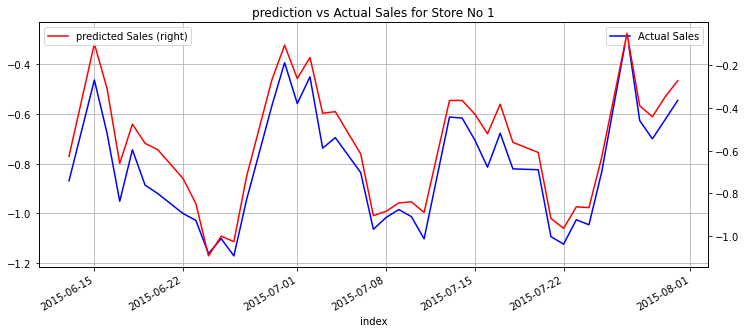

In [97]:
# Plot shows the actual sales and predicticted sales for Store No 1.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("prediction vs Actual Sales for Store No 1")
plt.show()

In [98]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i] - f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0 / len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.237070
Mean Squared Error(MSE) : 0.060747
Root Mean Square Error(RMSE) : 0.246468
Mean Absolute Percentage Error(MAPE) : -33.770000
Mean Absolute Error(MAE): 0.237070


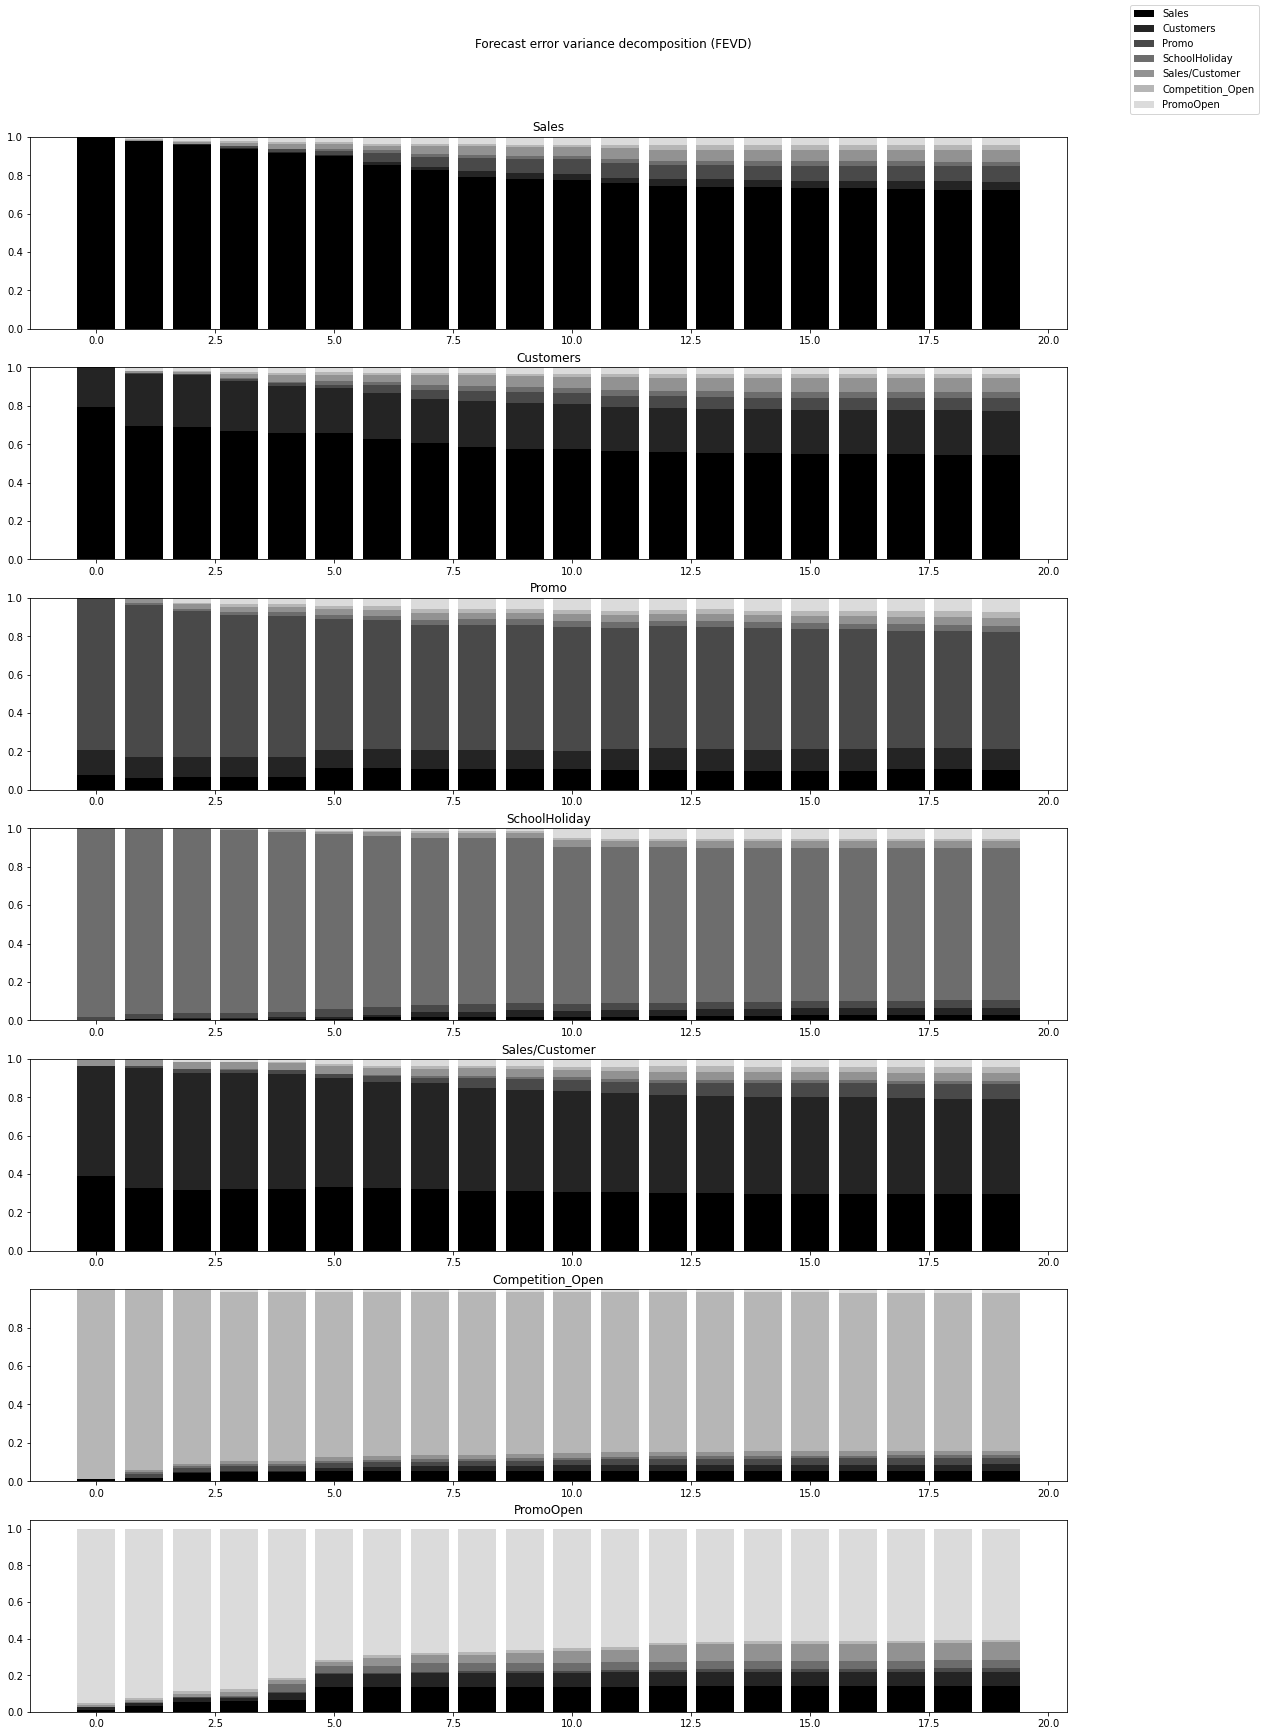

In [99]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [100]:
# Use the adfuller_test function on data.

for name, column in Store1.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.3996
 No. Lags Chosen      = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -4.3204
 No. Lags Chosen      = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [101]:
# look for the columns which have same value in all its rows.

Store1.nunique()

Sales               710
Customers           304
Promo                 2
SchoolHoliday         2
Sales/Customer      778
Competition_Open     31
PromoOpen           127
dtype: int64

In [102]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store1[0:-nobs], Store1[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(739, 7)
(42, 7)


In [103]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  \
index                                                                   
2013-01-03 -0.387629  -0.224347    0.0            0.0       -0.792284   
2013-01-04  0.051233   0.102203    0.0            0.0       -0.238986   
2013-01-05  0.164654   0.039884    0.0            0.0        0.622118   
2013-01-07  0.702115   0.373912    1.0            0.0        1.272110   
2013-01-08 -0.514261  -0.326550    0.0            0.0       -0.609291   

            Competition_Open  PromoOpen  
index                                    
2013-01-03               0.0       0.00  
2013-01-04               0.0       0.00  
2013-01-05               0.0       0.00  
2013-01-07               0.0       0.25  
2013-01-08               0.0       0.00

In [104]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.0846
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -14.4811
 No. Lags Chosen      = 10
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Te


1. Now all features are stationary. lets build the model.

In [105]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -21.329387124383448
BIC :  -20.979665384949797
FPE :  5.454657193035733e-10
HQIC:  -21.194521849172688 

Lag Order = 2
AIC :  -21.530780614532144
BIC :  -20.874355122050446
FPE :  4.45982634781326e-10
HQIC:  -21.27762332813116 

Lag Order = 3
AIC :  -21.932555176802975
BIC :  -20.968772786491712
FPE :  2.984466384647721e-10
HQIC:  -21.560838974799417 

Lag Order = 4
AIC :  -22.162693172831784
BIC :  -20.890898441484715
FPE :  2.3713178167291525e-10
HQIC:  -21.67215018943231 

Lag Order = 5
AIC :  -22.665034887313386
BIC :  -21.084570062108153
FPE :  1.4352939735004187e-10
HQIC:  -22.055396290609405 

Lag Order = 6
AIC :  -22.914001730107422
BIC :  -21.02420673734464
FPE :  1.1194048236740573e-10
HQIC:  -22.18499771731127 

Lag Order = 7
AIC :  -23.12340145821468
BIC :  -20.923613891987017
FPE :  9.084159035401979e-11
HQIC:  -22.274761250866035 

Lag Order = 8
AIC :  -23.150640623269467
BIC :  -20.64019573406011
FPE :  8.846528711993406e-11
HQIC:  -22.18209246241176

In [106]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [107]:
# Fit the lowest metrics' lag which is 11.

res = mod.fit(11)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:17
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -20.0552
Nobs:                     727.000    HQIC:                  -22.1717
Log likelihood:           1867.87    FPE:                6.25001e-11
AIC:                     -23.5017    Det(Omega_mle):     3.06232e-11
--------------------------------------------------------------------
Results for equation Sales
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.016342         0.010539            1.551           0.121
L1.Sales                     0.808780         0.438325            1.845           0.065
L1.Customers                -1.3

In [108]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store1.index[-42:], columns = Store1.columns)
predict_data

Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13  0.242807   0.217255  0.192567       0.052062       -0.035357   
2015-06-15  0.119813   0.074611  0.150717      -0.002217        0.211542   
2015-06-16  0.005050  -0.034296  0.162373      -0.042449        0.167743   
2015-06-17 -0.075919  -0.064690  0.120899       0.036270       -0.008300   
2015-06-18 -0.023773  -0.002428  0.053927      -0.043988       -0.081801   
2015-06-19  0.052797   0.025343  0.031029      -0.021610        0.117337   
2015-06-20  0.004089   0.056788 -0.343928       0.004430       -0.267584   
2015-06-22 -0.054111  -0.034414 -0.118079      -0.021790       -0.154284   
2015-06-23 -0.089237  -0.075951 -0.051621       0.029449       -0.040292   
2015-06-24 -0.110860  -0.065886 -0.078834      -0.005565       -0.210348   
2015-06-25  0.031849   0.028592 -0.041382      -0.023667        0.007175   
2015-06-26  0.043987   0.030860  0.019808      -0.032310        0.091170   
2015-06-27  0.077784   0.037803  0.051075      -0.038804        0.194035   
2015-06-29  0.073060   0.032353  0.142694       0.031609        0.200066   
2015-06-30 -0.011576  -0.018489  0.149990       0.049009        0.038310   
2015-07-01  0.009062   0.001042  0.081719       0.017572        0.042756   
2015-07-02 -0.009520   0.002901  0.042691      -0.022066       -0.052367   
2015-07-03  0.027107   0.022653 -0.026837      -0.022722        0.008639   
2015-07-04 -0.035191  -0.010001 -0.170846       0.011490       -0.121012   
2015-07-06 -0.056263  -0.039165 -0.051900       0.036851       -0.101860   
2015-07-07 -0.060134  -0.041192 -0.050684       0.014427       -0.093540   
2015-07-08 -0.027196  -0.005979 -0.093613      -0.008137       -0.105515   
2015-07-09  0.006927   0.007807 -0.047956      -0.021849       -0.007295   
2015-07-10  0.033982   0.020045  0.016495      -0.012452        0.076737   
2015-07-11  0.039759   0.014881  0.052134      -0.003411        0.127866   
2015-07-13  0.032539   0.009474  0.111936       0.009339        0.117398   
2015-07-14  0.004042  -0.002209  0.096207       0.012761        0.037125   
2015-07-15  0.024511   0.016467  0.048320      -0.005971        0.042374   
2015-07-16  0.017663   0.012579  0.033551      -0.013402        0.028208   
2015-07-17  0.001438   0.001608 -0.015355      -0.007298       -0.002158   
2015-07-18 -0.034389  -0.016126 -0.084835       0.004865       -0.093241   
2015-07-20 -0.044141  -0.026427 -0.036367       0.015578       -0.096990   
2015-07-21 -0.038514  -0.022950 -0.054753       0.003201       -0.078183   
2015-07-22 -0.016183  -0.002830 -0.085788      -0.009771       -0.067788   
2015-07-23  0.002341   0.003722 -0.039960      -0.009356       -0.009096   
2015-07-24  0.016738   0.007393  0.015485      -0.003424        0.048636   
2015-07-25  0.022088   0.007895  0.042057       0.001682        0.072563   
2015-07-27  0.020456   0.006097  0.079867       0.005507        0.073825   
2015-07-28  0.013227   0.005524  0.061236       0.002568        0.044160   
2015-07-29  0.022145   0.013923  0.035789      -0.002531        0.044314   
2015-07-30  0.016026   0.009530  0.027709      -0.003181        0.033390   
2015-07-31 -0.002905  -0.001740 -0.005128       0.002057       -0.006213   

            Competition_Open  PromoOpen  
index                                    
2015-06-13          0.017528  -0.154560  
2015-06-15          0.076043  -0.343823  
2015-06-16          0.111449   0.288064  
2015-06-17          0.049314   0.255238  
2015-06-18          0.095960   0.878696  
2015-06-19         -0.000211   0.041424  
2015-06-20          0.011331  -0.528084  
2015-06-22          0.049483  -0.133752  
2015-06-23          0.042858   0.167373  
2015-06-24          0.053789   0.440015  
2015-06-25          0.019842  -0.034761  
2015-06-26          0.011512  -0.453903  
2015-06-27          0.025494  -0.150711  
2015-06-29          0.064955   0.109766 

In [109]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

               Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13 -0.626929  -0.432675  0.192567       0.052062        8.442731   
2015-06-15 -0.100477  -0.148674  1.343284       0.049845        9.592567   
2015-06-16 -0.310024  -0.389868  1.505657       0.007396        9.990051   
2015-06-17 -0.660473  -0.521863  1.626557       0.043666        8.738989   
2015-06-18 -0.476416  -0.469450  1.680484      -0.000323        9.581136   
2015-06-19 -0.566361  -0.471528  1.711514      -0.021932        8.999500   
2015-06-20 -0.596105  -0.397290  0.367586      -0.017502        8.397101   
2015-06-22 -0.731093  -0.444168  0.249507      -0.039292        7.814325   
2015-06-23 -0.847397  -0.624814  0.197886      -0.009844        8.325110   
2015-06-24 -1.092299  -0.772961  0.119052      -0.015408        7.780779   
2015-06-25 -1.000195  -0.697007  0.077670      -0.039075        7.865182   
2015-06-26 -

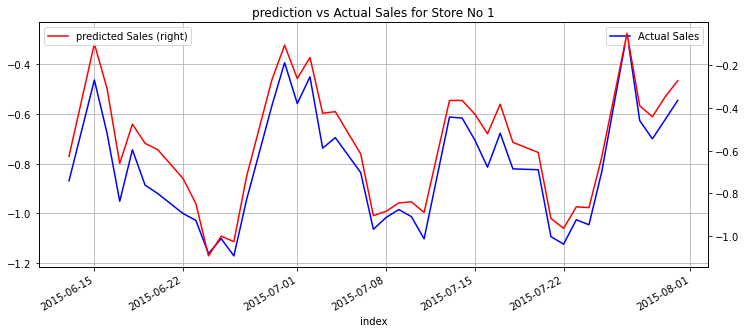

In [110]:
# Plot shows the actual sales and predicticted sales for Store No 1.

plt.figure(figsize = (12,5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("prediction vs Actual Sales for Store No 1")

plt.show()

In [111]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.237070
Mean Squared Error(MSE) : 0.060747
Root Mean Square Error(RMSE) : 0.246468
Mean Absolute Percentage Error(MAPE) : -33.770000
Mean Absolute Error(MAE): 0.237070


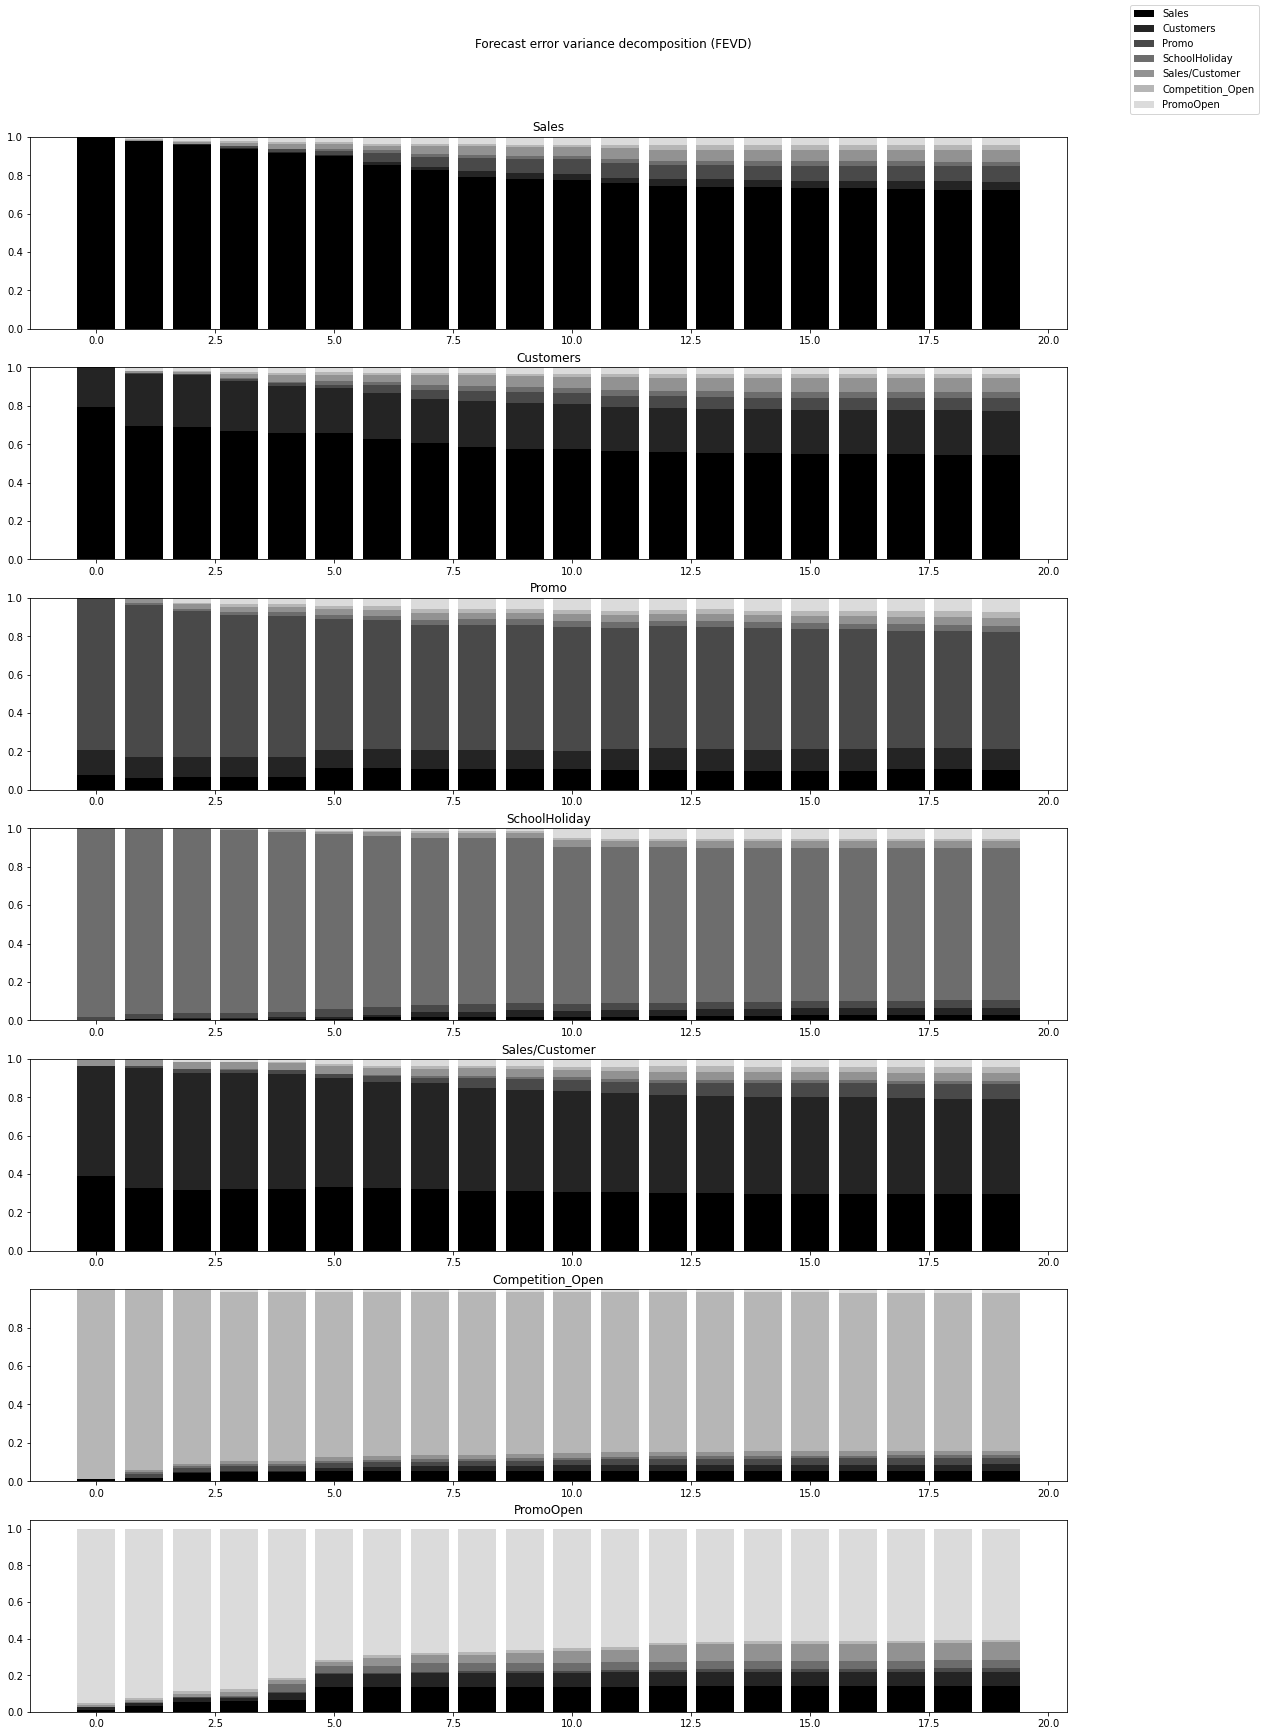

In [112]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.2. Model for Store No. 3

### Model 1. 

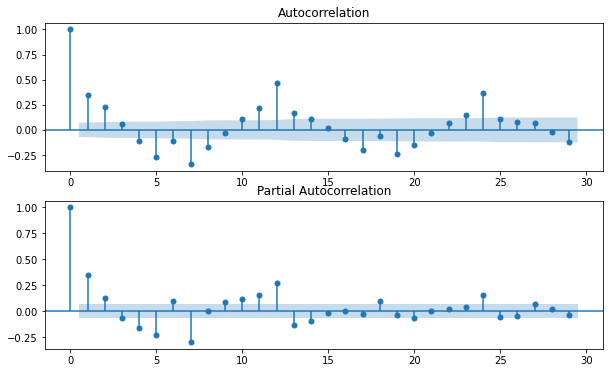

In [113]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store3.Sales, ax = ax[0])
ax[1] = plot_pacf(Store3.Sales, ax = ax[1])

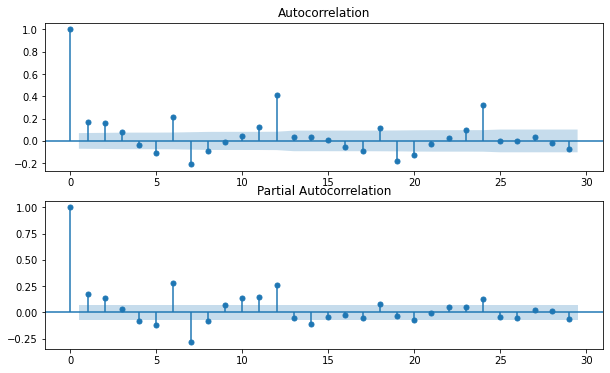

In [114]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store3.Customers, ax = ax[0])
ax[1] = plot_pacf(Store3.Customers, ax = ax[1])

In [115]:
# Use the adfuller_test function on data.

for name, column in Store3.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [116]:
# look for the columns which have same value in all its rows.

Store3.nunique()

Store                          1
DayOfWeek                      6
Sales                        736
Customers                    406
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               778
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [117]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store3 = Store3[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer"]]

In [118]:
# examine data.

Store3.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.042601   0.105372      0              1   
2013-01-03          4 -0.339364  -0.104019      0              1   
2013-01-04          5 -0.285554  -0.181294      0              1   
2013-01-05          6 -0.783704  -0.592597      0              0   
2013-01-07          1  1.705113   0.788386      1              0   

            Sales/Customer  
index                       
2013-01-02        8.475776  
2013-01-03        8.185853  
2013-01-04        8.795652  
2013-01-05        8.615238  
2013-01-07       11.350324

In [119]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store3[0:-nobs], Store3[-nobs:]

# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 6)
(42, 6)


In [120]:
# Drop nul values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0 -0.296763  -0.209391    0.0            0.0   
2013-01-04        1.0  0.053811  -0.077275    0.0            0.0   
2013-01-05        1.0 -0.498150  -0.411304    0.0           -1.0   
2013-01-07       -5.0  2.488817   1.380983    1.0            0.0   
2013-01-08        1.0 -0.788469  -0.555883    0.0            0.0   

            Sales/Customer  
index                       
2013-01-03       -0.289923  
2013-01-04        0.609799  
2013-01-05       -0.180414  
2013-01-07        2.735086  
2013-01-08        0.098274

In [121]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1558
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -11.5927
 No. Lags Chosen      = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.0


1. Now all features are stationary. lets build the model.

In [122]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:22
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -14.5485
Nobs:                     725.000    HQIC:                  -16.1100
Log likelihood:           425.265    FPE:                3.79017e-08
AIC:                     -17.0914    Det(Omega_mle):     2.23016e-08
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000150         0.026772           -0.006           0.996
L1.DayOfWeek              -0.712395         0.052238          -13.637           0.000
L1.Sales                   0.248752 

In [123]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store3.index[-42:], columns = Store3.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13  -0.672551  0.076635  -0.091695  0.001729       0.154516   
2015-06-15  -3.062302  0.881230   0.588391  0.568971      -0.125149   
2015-06-16   0.994833 -0.242846  -0.154664  0.054297      -0.063608   
2015-06-17   1.130191 -0.006350   0.028515 -0.006705       0.018349   
2015-06-18   0.807160 -0.221929  -0.115104 -0.045555      -0.028473   
2015-06-19   0.074960 -0.001195  -0.037281 -0.022625       0.075864   
2015-06-20  -0.258680 -0.215175  -0.147802 -0.280546       0.105009   
2015-06-22  -2.056659  0.215291   0.245232 -0.005150      -0.055737   
2015-06-23   0.560181 -0.210327  -0.081165 -0.020497      -0.025630   
2015-06-24   0.984006 -0.128408  -0.125520 -0.042926      -0.010398   
2015-06-25   0.456229  0.006594   0.021241 -0.098653      -0.025305   
2015-06-26   0.155010 -0.082985  -0.073702 -0.116367      -0.024393   
2015-06-27  -0.409543 -0.068901  -0.121329  0.035650       0.073671   
2015-06-29  -1.574599  0.682451   0.417093  0.386198       0.001170   
2015-06-30   0.709186 -0.050647  -0.014805  0.056011      -0.053318   
2015-07-01   0.635832 -0.125960  -0.081575  0.016422       0.006470   
2015-07-02   0.282204  0.070104   0.042476  0.090150      -0.024917   
2015-07-03   0.215088 -0.052319  -0.051424 -0.051987      -0.037628   
2015-07-04  -0.418665 -0.193998  -0.114938 -0.188916       0.070313   
2015-07-06  -1.127626  0.117972   0.137632 -0.001280       0.049778   
2015-07-07   0.519843 -0.104062  -0.039256 -0.048194      -0.018089   
2015-07-08   0.620929 -0.155600  -0.103639 -0.082689      -0.006015   
2015-07-09   0.188440 -0.027308  -0.011509 -0.058606      -0.024899   
2015-07-10   0.093858 -0.036323  -0.046250 -0.073482      -0.037905   
2015-07-11  -0.520626  0.077968   0.015438  0.063907       0.034577   
2015-07-13  -0.817696  0.357019   0.219561  0.235165       0.034315   
2015-07-14   0.604963 -0.014201  -0.008358  0.043266      -0.028989   
2015-07-15   0.501112 -0.087910  -0.060353 -0.003546      -0.007230   
2015-07-16   0.000134  0.060353   0.032534  0.073295      -0.008062   
2015-07-17   0.077136 -0.053724  -0.056462 -0.032954      -0.034522   
2015-07-18  -0.430722 -0.071392  -0.032260 -0.095417       0.038436   
2015-07-20  -0.570247  0.060352   0.089624  0.004276       0.044652   
2015-07-21   0.515876 -0.103471  -0.053024 -0.041738      -0.018627   
2015-07-22   0.441795 -0.109872  -0.073171 -0.081025      -0.002988   
2015-07-23  -0.016572 -0.009480   0.002444 -0.055213      -0.007053   
2015-07-24  -0.036948 -0.047465  -0.047984 -0.048090      -0.028995   
2015-07-25  -0.457634  0.104523   0.045010  0.069252       0.018624   
2015-07-27  -0.359929  0.209718   0.134985  0.140770       0.022655   
2015-07-28   0.517622 -0.032455  -0.022982  0.020514      -0.022962   
2015-07-29   0.340576 -0.047181  -0.040457  0.004587      -0.006037   
2015-07-30  -0.089765  0.064115   0.032959  0.054043       0.000518   
2015-07-31  -0.047222 -0.037252  -0.037500 -0.021342      -0.021036   

            Sales/Customer  
index                       
2015-06-13        0.640531  
2015-06-15        0.523312  
2015-06-16       -0.157810  
2015-06-17       -0.091347  
2015-06-18       -0.286844  
2015-06-19        0.204495  
2015-06-20       -0.231767  
2015-06-22       -0.296333  
2015-06-23       -0.394077  
2015-06-24        0.087173  
2015-06-25       -0.068815  
2015-06-26        0.023495  
2015-06-27        0.233628  
2015-06-29        0.641270  
2015-06-30       -0.080519  
2015-07-01       -0.040971  
2015-07-02        0.099965  
2015-07-03        0.016240  
2015-07-04       -0.267656  
2015-07-06       -0.162923  
2015-07-07       -0.200502  
2015-07-08       -0.133013  
2015-07-09       -0.039845  
2015-07-10        0.067409  
2015-07-11        0.184429  
2015-07-13        0.355730  
2015-07-14        0.018830  
2015-07-15       -0.035884  
2015-07-16       

In [124]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.327449 -0.654225  -0.766553  0.001729       0.154516   
2015-06-15  -2.734852  2.202528   0.975980  1.570700       0.029367   
2015-06-16  -0.740019  1.625219   0.711635  1.624997      -0.034241   
2015-06-17   1.390172  1.214163   0.515803  1.618291      -0.015891   
2015-06-18   3.197332  0.674204   0.206265  1.572736      -0.044364   
2015-06-19   4.272292  0.846040   0.303592  1.550112       0.031499   
2015-06-20   5.013612 -0.716976  -0.774005  0.269565       0.136508   
2015-06-22  -2.043047  0.126319   0.004676  0.264416       0.080771   
2015-06-23  -0.482866  0.211467   0.274988  0.243918       0.055141   
2015-06-24   1.501140 -0.338725  -0.214473  0.200993       0.044742   
2015-06-25   2.957369 -0.230633  -0.043667  0.102340       0.019438   
2015-06-26   4.112378 -0.165720  -0.104906 -0.014027      -0.004956   
2015-0

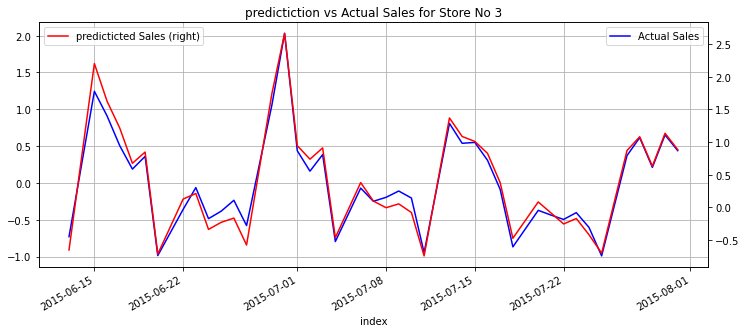

In [125]:
# Plot shows the actual sales and predicticted sales for Store No 1.

plt.figure(figsize=(12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 3")

plt.show()

In [126]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
#print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.394689
Mean Squared Error(MSE) : 0.195895
Root Mean Square Error(RMSE) : 0.442601
Mean Absolute Percentage Error(MAPE) : -8.910000


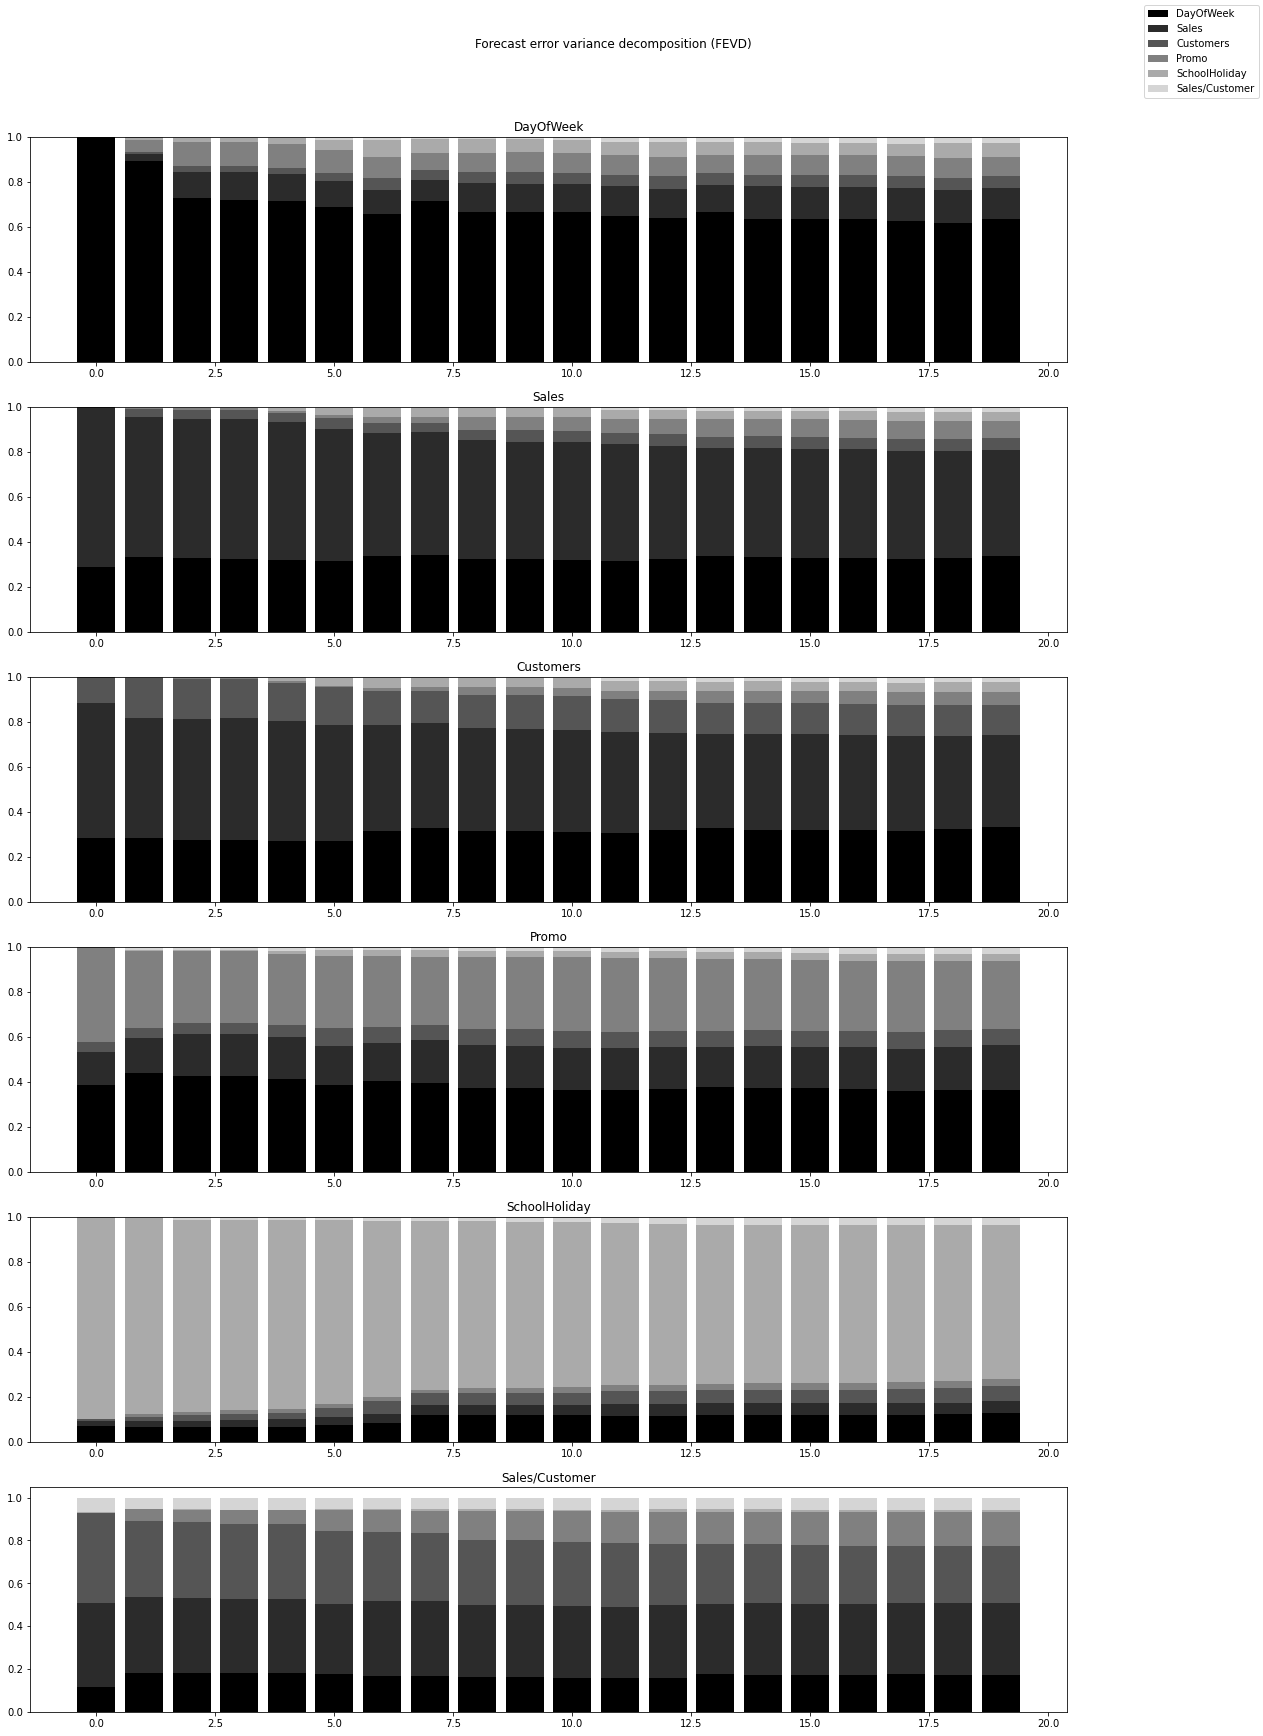

In [127]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [128]:
# Use the adfuller_test function on data.

for name, column in Store3.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.8227
 No. Lags Chosen      = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


In [129]:
X_train = X_train[["Sales", "Customers", "Promo", "SchoolHoliday"]]

In [130]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store3[0:-nobs], Store3[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 6)
(42, 6)



1. Now all features are stationary. lets build the model.

In [131]:
# Building the VAR model.

mod = VAR(X_train)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -14.541887026168656
BIC :  -14.279316829175976
FPE :  4.836600346910893e-07
HQIC:  -14.440624111608262 

Lag Order = 2
AIC :  -15.584041401230156
BIC :  -15.095891878864713
FPE :  1.705871947651159e-07
HQIC:  -15.395769558656927 

Lag Order = 3
AIC :  -16.030843342508092
BIC :  -15.316633493377228
FPE :  1.0912476951914155e-07
HQIC:  -15.755366002076862 

Lag Order = 4
AIC :  -16.50663859272596
BIC :  -15.565885720579988
FPE :  6.781517919677633e-08
HQIC:  -16.143758475640258 

Lag Order = 5
AIC :  -17.155691979394042
BIC :  -15.987911684862889
FPE :  3.5441306909650617e-08
HQIC:  -16.705211094410373 

Lag Order = 6
AIC :  -17.314214323043515
BIC :  -15.918920495321968
FPE :  3.025226352182572e-08
HQIC:  -16.775933962953804 

Lag Order = 7
AIC :  -17.44300005369348
BIC :  -15.819704862174646
FPE :  2.660462323134545e-08
HQIC:  -16.816720791785492 

Lag Order = 8
AIC :  -17.449606197548857
BIC :  -15.597820083405448
FPE :  2.6439989908477515e-08
HQIC:  -16.735127884

In [132]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [133]:
# Fit the lowest metrics' lag which is 11

res = mod.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:26
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -14.7691
Nobs:                     725.000    HQIC:                  -16.4705
Log likelihood:           623.795    FPE:                2.42296e-08
AIC:                     -17.5398    Det(Omega_mle):     1.36256e-08
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -3.519587         4.687186           -0.751           0.453
L1.DayOfWeek               0.120958         0.053640            2.255           0.024
L1.Sales                  -0.048991 

In [134]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(X_train.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store3.index[-42:], columns = Store3.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   4.468640 -0.196049  -0.303369  0.104693       0.205524   
2015-06-15   1.585748  0.743801   0.287634  0.755090       0.059857   
2015-06-16   2.682024  0.410358   0.089309  0.824400       0.055188   
2015-06-17   3.573061  0.433131   0.137407  0.855020       0.087818   
2015-06-18   4.203902  0.223293   0.031322  0.841314       0.057372   
2015-06-19   4.271279  0.201136   0.004739  0.774349       0.140955   
2015-06-20   4.361339 -0.214627  -0.255857  0.345986       0.218465   
2015-06-22   2.408436 -0.066320  -0.046807  0.293482       0.152424   
2015-06-23   2.867005 -0.226680  -0.110249  0.260111       0.155713   
2015-06-24   3.548671 -0.306009  -0.200099  0.213626       0.168521   
2015-06-25   3.808166 -0.210623  -0.114280  0.175909       0.150748   
2015-06-26   4.184341 -0.248132  -0.155233  0.132261       0.132941   
2015-06-27   4.076222 -0.304101  -0.275314  0.218693       0.180851   
2015-06-29   2.537568  0.347654   0.120517  0.587149       0.197631   
2015-06-30   2.996148  0.293755   0.105533  0.630997       0.182261   
2015-07-01   3.403319  0.162256   0.026874  0.644406       0.220045   
2015-07-02   3.661689  0.212236   0.071278  0.735214       0.202679   
2015-07-03   4.212114  0.082000  -0.020604  0.635595       0.155577   
2015-07-04   3.997944 -0.188721  -0.185823  0.392929       0.212353   
2015-07-06   2.774614 -0.045161  -0.040178  0.397740       0.255276   
2015-07-07   3.019958 -0.067149  -0.036924  0.386922       0.247021   
2015-07-08   3.504298 -0.172474  -0.103070  0.336013       0.245471   
2015-07-09   3.766654 -0.167033  -0.087151  0.311126       0.208933   
2015-07-10   4.131038 -0.219740  -0.147079  0.259313       0.157923   
2015-07-11   3.724086 -0.155548  -0.149379  0.319165       0.177589   
2015-07-13   2.775924  0.168533   0.052004  0.520272       0.216241   
2015-07-14   3.123430  0.158674   0.055057  0.554409       0.202089   
2015-07-15   3.564976  0.073518   0.004958  0.555617       0.201366   
2015-07-16   3.699789  0.115910   0.036666  0.616877       0.192476   
2015-07-17   4.013362  0.003806  -0.053519  0.540517       0.150283   
2015-07-18   3.626488 -0.097772  -0.110982  0.423369       0.178608   
2015-07-20   2.899737  0.006519  -0.005466  0.450897       0.217183   
2015-07-21   3.205091 -0.027376  -0.018909  0.445990       0.204578   
2015-07-22   3.618675 -0.102403  -0.066000  0.395087       0.204689   
2015-07-23   3.763595 -0.106078  -0.057952  0.362603       0.193630   
2015-07-24   3.922391 -0.169007  -0.120098  0.322461       0.156281   
2015-07-25   3.486014 -0.085951  -0.092858  0.374463       0.167390   
2015-07-27   2.953538  0.108768   0.036737  0.491303       0.194756   
2015-07-28   3.279737  0.085062   0.027829  0.508217       0.184588   
2015-07-29   3.630559  0.033429  -0.006877  0.512152       0.183722   
2015-07-30   3.727263  0.062413   0.010058  0.543166       0.180367   
2015-07-31   3.840936 -0.015974  -0.053937  0.487191       0.152873   

            Sales/Customer  
index                       
2015-06-13        9.670022  
2015-06-15       10.386394  
2015-06-16       10.182403  
2015-06-17       10.092879  
2015-06-18        9.794823  
2015-06-19        9.845334  
2015-06-20        9.335523  
2015-06-22        8.925860  
2015-06-23        8.636261  
2015-06-24        8.742159  
2015-06-25        8.732267  
2015-06-26        8.800036  
2015-06-27        9.075983  
2015-06-29        9.707142  
2015-06-30        9.618418  
2015-07-01        9.532631  
2015-07-02        9.535879  
2015-07-03        9.437708  
2015-07-04        9.099224  
2015-07-06        8.989524  
2015-07-07        8.897605  
2015-07-08        8.788074  
2015-07-09        8.756981  
2015-07-10        8.834735  
2015-07-11        9.046513  
2015-07-13        9.361801  
2015-07-14        9.343986  
2015-07-15        9.267161  
2015-07-16       

In [135]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

             DayOfWeek     Sales  Customers      Promo  SchoolHoliday  \
index                                                                   
2015-06-13   10.468640 -0.926909  -0.978227   0.104693       0.205524   
2015-06-15    7.054387  1.792415   0.463550   1.859784       0.265381   
2015-06-16   10.736411  1.868310   0.443177   2.684183       0.320570   
2015-06-17   15.309473  1.896735   0.356237   3.539203       0.408388   
2015-06-18   20.513375  1.801998   0.193125   4.380517       0.465760   
2015-06-19   25.784654  2.176165   0.332473   5.154866       0.606715   
2015-06-20   31.145993  0.613697  -0.853180   4.500852       0.825180   
2015-06-22   28.554428  1.175381  -0.366539   4.794335       0.977604   
2015-06-23   32.421433  1.244176  -0.125311   5.054446       1.133317   
2015-06-24   36.970104  0.516383  -0.689351   5.268072       1.301838   
2015-06-25   41.778270  0.407259  -0.654066   5.443981       1.452585   
2015-06-26   46.962612  0.307025  -0.796835   5.576

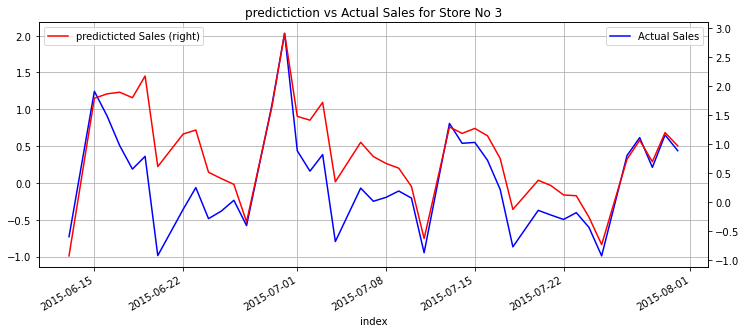

In [136]:
# Plot shows the actual sales and predicticted sales for Store No 1.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 3")
plt.show()

In [137]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.804482
Mean Squared Error(MSE) : 0.825757
Root Mean Square Error(RMSE) : 0.908712
Mean Absolute Percentage Error(MAPE) : -97.230000
Mean Absolute Error(MAE): 0.813817


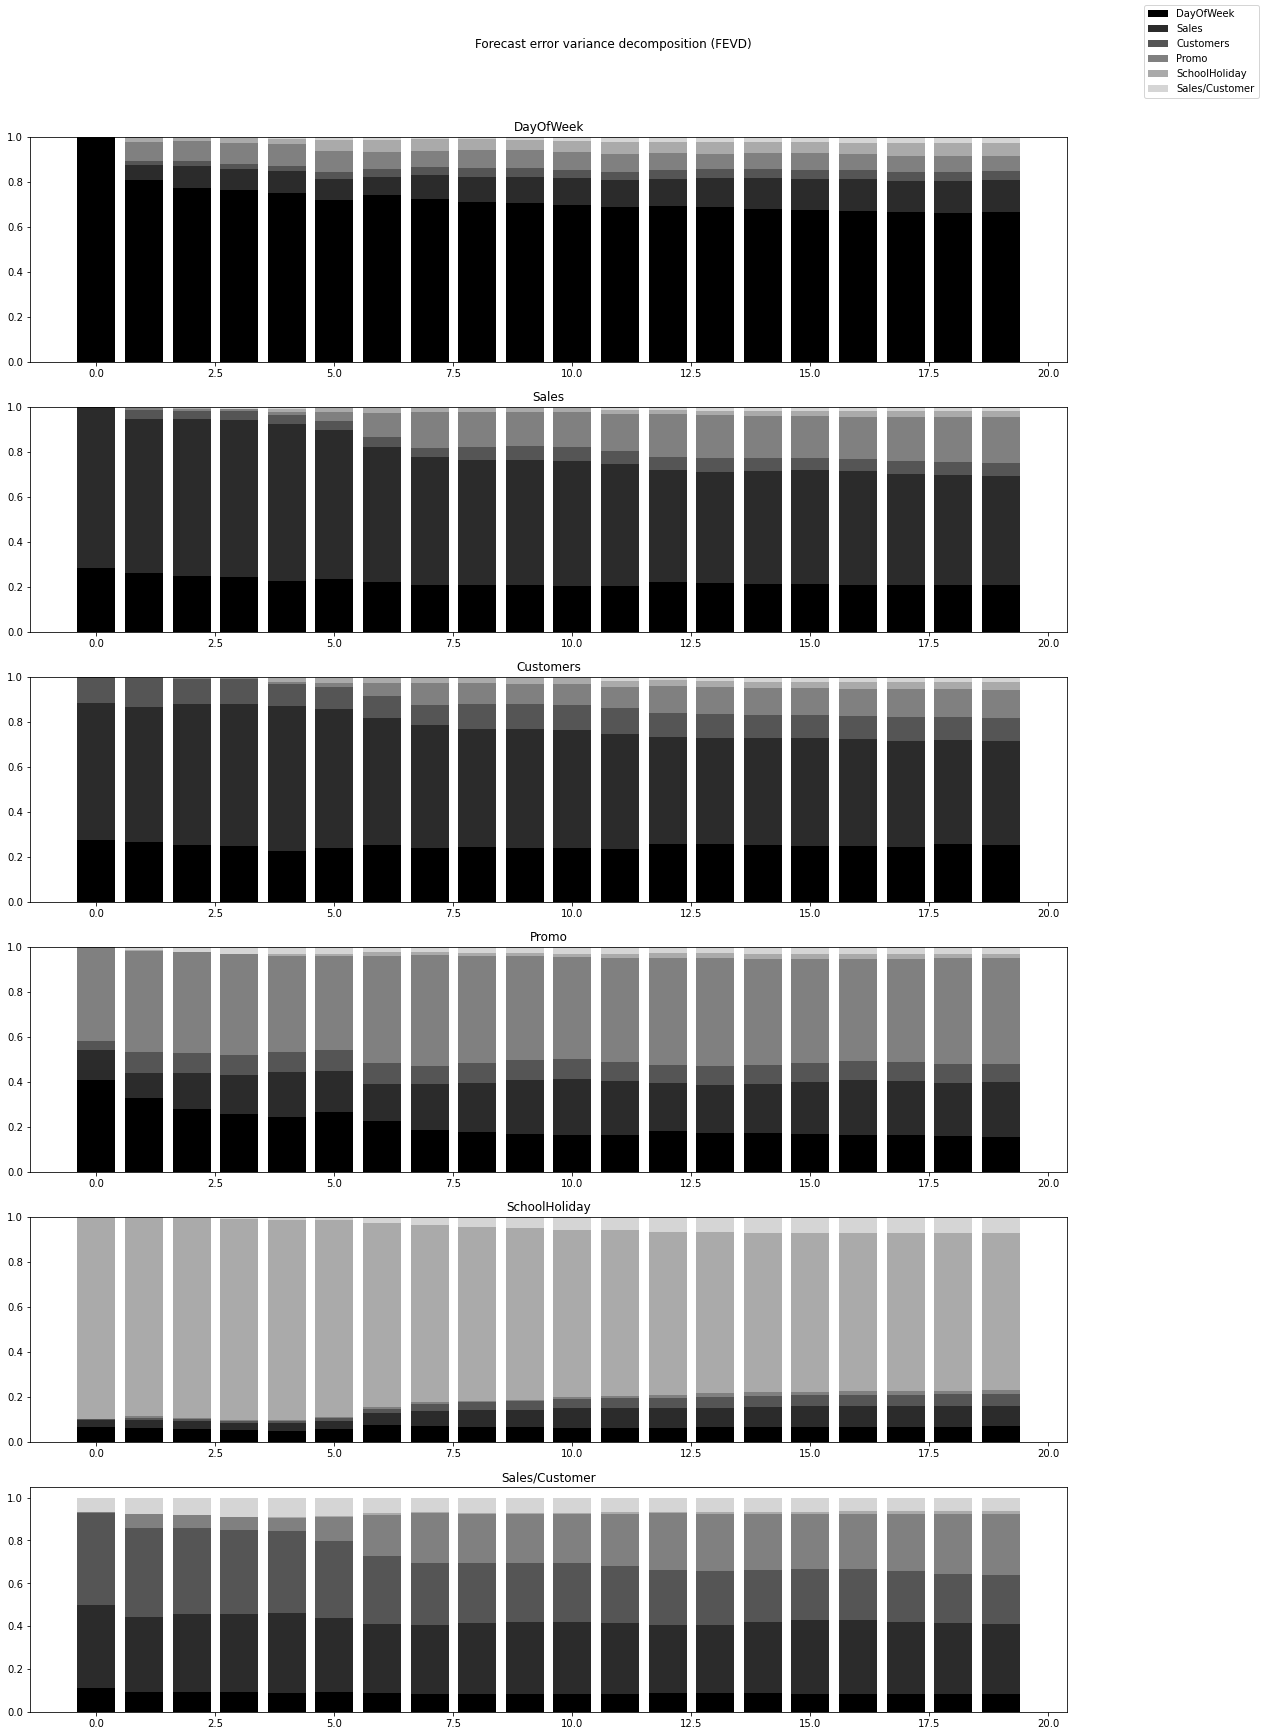

In [138]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.3. Model for Store No. 8.

### Model 1.

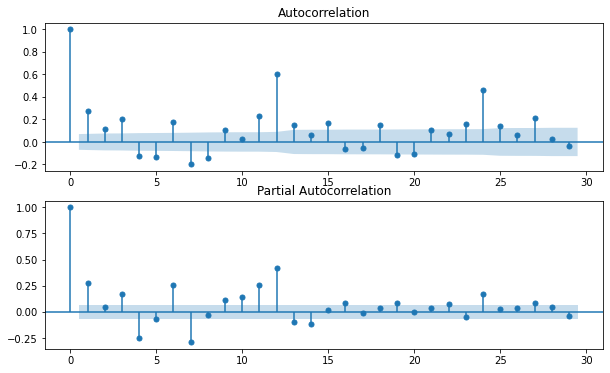

In [139]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(Store8.Sales, ax = ax[0])
ax[1] = plot_pacf(Store8.Sales, ax = ax[1])

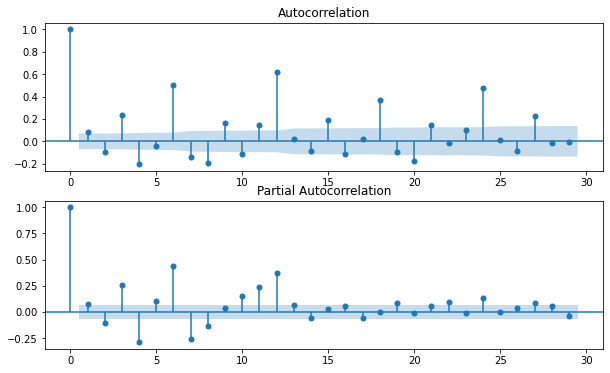

In [140]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0] = plot_acf(Store8.Customers, ax = ax[0])
ax[1] = plot_pacf(Store8.Customers, ax = ax[1])

In [141]:
# Use the adfuller_test function on data.

for name, column in Store8.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3404
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [142]:
# look for the columns which have same value in all its rows.

Store8.nunique()

Store                          1
DayOfWeek                      6
Sales                        751
Customers                    446
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               782
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [143]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store8 = Store8[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Month", "Week"]]

In [144]:
# examine data.

Store8.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.494996  -0.161352      0              1   
2013-01-03          4 -0.680916  -0.251091      0              1   
2013-01-04          5 -0.933213  -0.612539      0              1   
2013-01-05          6 -1.488074  -1.123553      0              0   
2013-01-07          1  0.148475   0.097894      1              0   

            Sales/Customer  Month  Week  
index                                    
2013-01-02        7.763610      1     1  
2013-01-03        7.314199      1     1  
2013-01-04        7.851064      1     1  
2013-01-05        7.490385      1     1  
2013-01-07        9.246883      1     2

In [145]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store8[0:-nobs], Store8[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(742, 8)
(42, 8)


In [146]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0 -0.185920  -0.089739    0.0            0.0   
2013-01-04        1.0 -0.252297  -0.361449    0.0            0.0   
2013-01-05        1.0 -0.554861  -0.511014    0.0           -1.0   
2013-01-07       -5.0  1.636549   1.221447    1.0            0.0   
2013-01-08        1.0 -0.348963  -0.254260    0.0            0.0   

            Sales/Customer  Month  Week  
index                                    
2013-01-03       -0.449411    0.0   0.0  
2013-01-04        0.536864    0.0   0.0  
2013-01-05       -0.360679    0.0   0.0  
2013-01-07        1.756498    0.0   1.0  
2013-01-08       -0.199740    0.0   0.0

In [147]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -11.2639
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.414
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [148]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:31
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -14.0565
Nobs:                     729.000    HQIC:                  -17.0583
Log likelihood:          -594.096    FPE:                6.00015e-09
AIC:                     -18.9442    Det(Omega_mle):     2.20873e-09
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.002142         0.021782           -0.098           0.922
L1.DayOfWeek              -0.762423         0.059542          -12.805           0.000
L1.Sales                  -2.093091 

In [149]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store8.index[-42:], columns = Store8.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   0.981026 -0.511724  -0.547492 -0.026030      -0.123474   
2015-06-15  -4.569228  1.686067   1.181890  0.887967       0.186476   
2015-06-16   0.871021 -0.426076  -0.282592 -0.078600      -0.128022   
2015-06-17   0.219288 -0.082664   0.015972  0.135159       0.098102   
2015-06-18   1.096487  0.257834   0.331968  0.074452      -0.016878   
2015-06-19   1.370144 -0.541709  -0.506981 -0.172242       0.002764   
2015-06-20   0.968996 -0.752568  -0.593160 -0.823637      -0.030870   
2015-06-22  -4.046437  0.625579   0.591961  0.164409       0.049116   
2015-06-23   0.369266 -0.040737  -0.058142  0.006920       0.046961   
2015-06-24   0.458886 -0.075174  -0.050280 -0.017754       0.004415   
2015-06-25   0.954867  0.172992   0.271101 -0.000809       0.011768   
2015-06-26   1.065678 -0.275341  -0.342821 -0.041977       0.014148   
2015-06-27   0.624614 -0.360928  -0.361934 -0.152056      -0.040629   
2015-06-29  -3.228939  0.955459   0.669967  0.484049       0.087849   
2015-06-30   0.338458 -0.136638  -0.070385  0.014163      -0.033406   
2015-07-01   0.309437 -0.050997  -0.008749  0.125130       0.021865   
2015-07-02   0.704118  0.324661   0.326339  0.179242       0.003589   
2015-07-03   1.272503 -0.448345  -0.431354 -0.093534      -0.050369   
2015-07-04   0.410554 -0.420014  -0.331627 -0.460093      -0.092019   
2015-07-06  -2.914090  0.457597   0.416712  0.138125       0.079943   
2015-07-07   0.254618 -0.047069  -0.041068  0.005828       0.005562   
2015-07-08   0.474273 -0.094171  -0.048687 -0.081207       0.028934   
2015-07-09   0.714246  0.101782   0.181596 -0.044412      -0.017859   
2015-07-10   0.935277 -0.312475  -0.342726 -0.087147      -0.024339   
2015-07-11   0.138008 -0.161140  -0.178651 -0.120517      -0.042039   
2015-07-13  -2.452261  0.692798   0.501058  0.351772       0.070823   
2015-07-14   0.347564 -0.117187  -0.069083  0.019625      -0.012516   
2015-07-15   0.367850 -0.009280   0.010042  0.111546       0.037115   
2015-07-16   0.650515  0.205096   0.204650  0.121758      -0.010158   
2015-07-17   0.870766 -0.324963  -0.329822 -0.077131      -0.032514   
2015-07-18   0.014735 -0.260918  -0.198680 -0.295456      -0.061758   
2015-07-20  -2.177202  0.392329   0.346651  0.141544       0.070810   
2015-07-21   0.342596 -0.074042  -0.053971 -0.002123      -0.002437   
2015-07-22   0.470963 -0.079571  -0.036642 -0.059882       0.022828   
2015-07-23   0.605071  0.037955   0.099594 -0.052077      -0.018666   
2015-07-24   0.624382 -0.248715  -0.271234 -0.089220      -0.013246   
2015-07-25  -0.126433 -0.082345  -0.100950 -0.084394      -0.038809   
2015-07-27  -1.850124  0.512047   0.384093  0.250481       0.060941   
2015-07-28   0.393869 -0.107341  -0.065299  0.008342      -0.009652   
2015-07-29   0.395819 -0.005063   0.009114  0.076908       0.026283   
2015-07-30   0.550606  0.123975   0.121178  0.080755      -0.012844   
2015-07-31   0.572363 -0.243326  -0.253681 -0.068742      -0.029230   

            Sales/Customer     Month      Week  
index                                           
2015-06-13        0.274828  0.096628  1.848582  
2015-06-15        1.463056  0.023678  2.244280  
2015-06-16       -0.357864  0.379608  2.421879  
2015-06-17       -0.261367  0.348620 -0.068349  
2015-06-18       -0.395027  0.474754  0.865685  
2015-06-19        0.108677  0.158960 -0.589043  
2015-06-20       -0.721611  0.247095  1.027784  
2015-06-22       -0.032561  0.087631  1.082917  
2015-06-23        0.176973  0.063529  0.658019  
2015-06-24       -0.081734  0.153500 -0.162573  
2015-06-25       -0.392958  0.019338 -0.483816  
2015-06-26        0.301079  0.136179 -2.679979  
2015-06-27        0.041246 -0.033170 -0.385525  
2015-06-29        0.941754 -0.263134  1.177042  
2015-06-30       -0.226754 -0.304891  0.189350  
2015-07-01       -0.073102  0.062703  0.011922  
2015-

In [150]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   6.981026 -1.639235  -1.459162 -0.026030      -0.123474   
2015-06-15  -2.588202  2.135131   1.071305  1.861937       0.063002   
2015-06-16  -0.717181  1.209294   0.641641  1.783337      -0.065020   
2015-06-17   0.502106  0.922021   0.380918  1.918496       0.033082   
2015-06-18   2.598593  1.035180   0.969639  1.992949       0.016203   
2015-06-19   4.968737  0.323017   0.011471  1.820707       0.018967   
2015-06-20   6.937733 -1.448406  -1.282152 -0.002930      -0.011903   
2015-06-22  -2.108704 -0.440998  -0.139293  0.161479       0.037213   
2015-06-23  -0.739438 -0.254570   0.124130  0.168400       0.084174   
2015-06-24   0.719448 -0.489565  -0.260178  0.150646       0.088589   
2015-06-25   2.674315 -0.010143   0.374864  0.149837       0.100356   
2015-06-26   4.739993 -0.588369  -0.296999  0.107861       0.114504   
2015-0

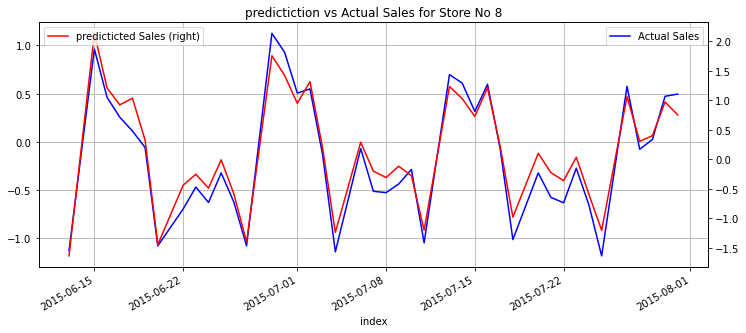

In [151]:
# Plot shows the actual sales and predicticted sales for Store No 8.

plt.figure(figsize=(12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 8")
plt.show()

In [152]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.307806
Mean Squared Error(MSE) : 0.201297
Root Mean Square Error(RMSE) : 0.448662
Mean Absolute Percentage Error(MAPE) : 17.520000
Mean Absolute Error(MAE): 0.378652


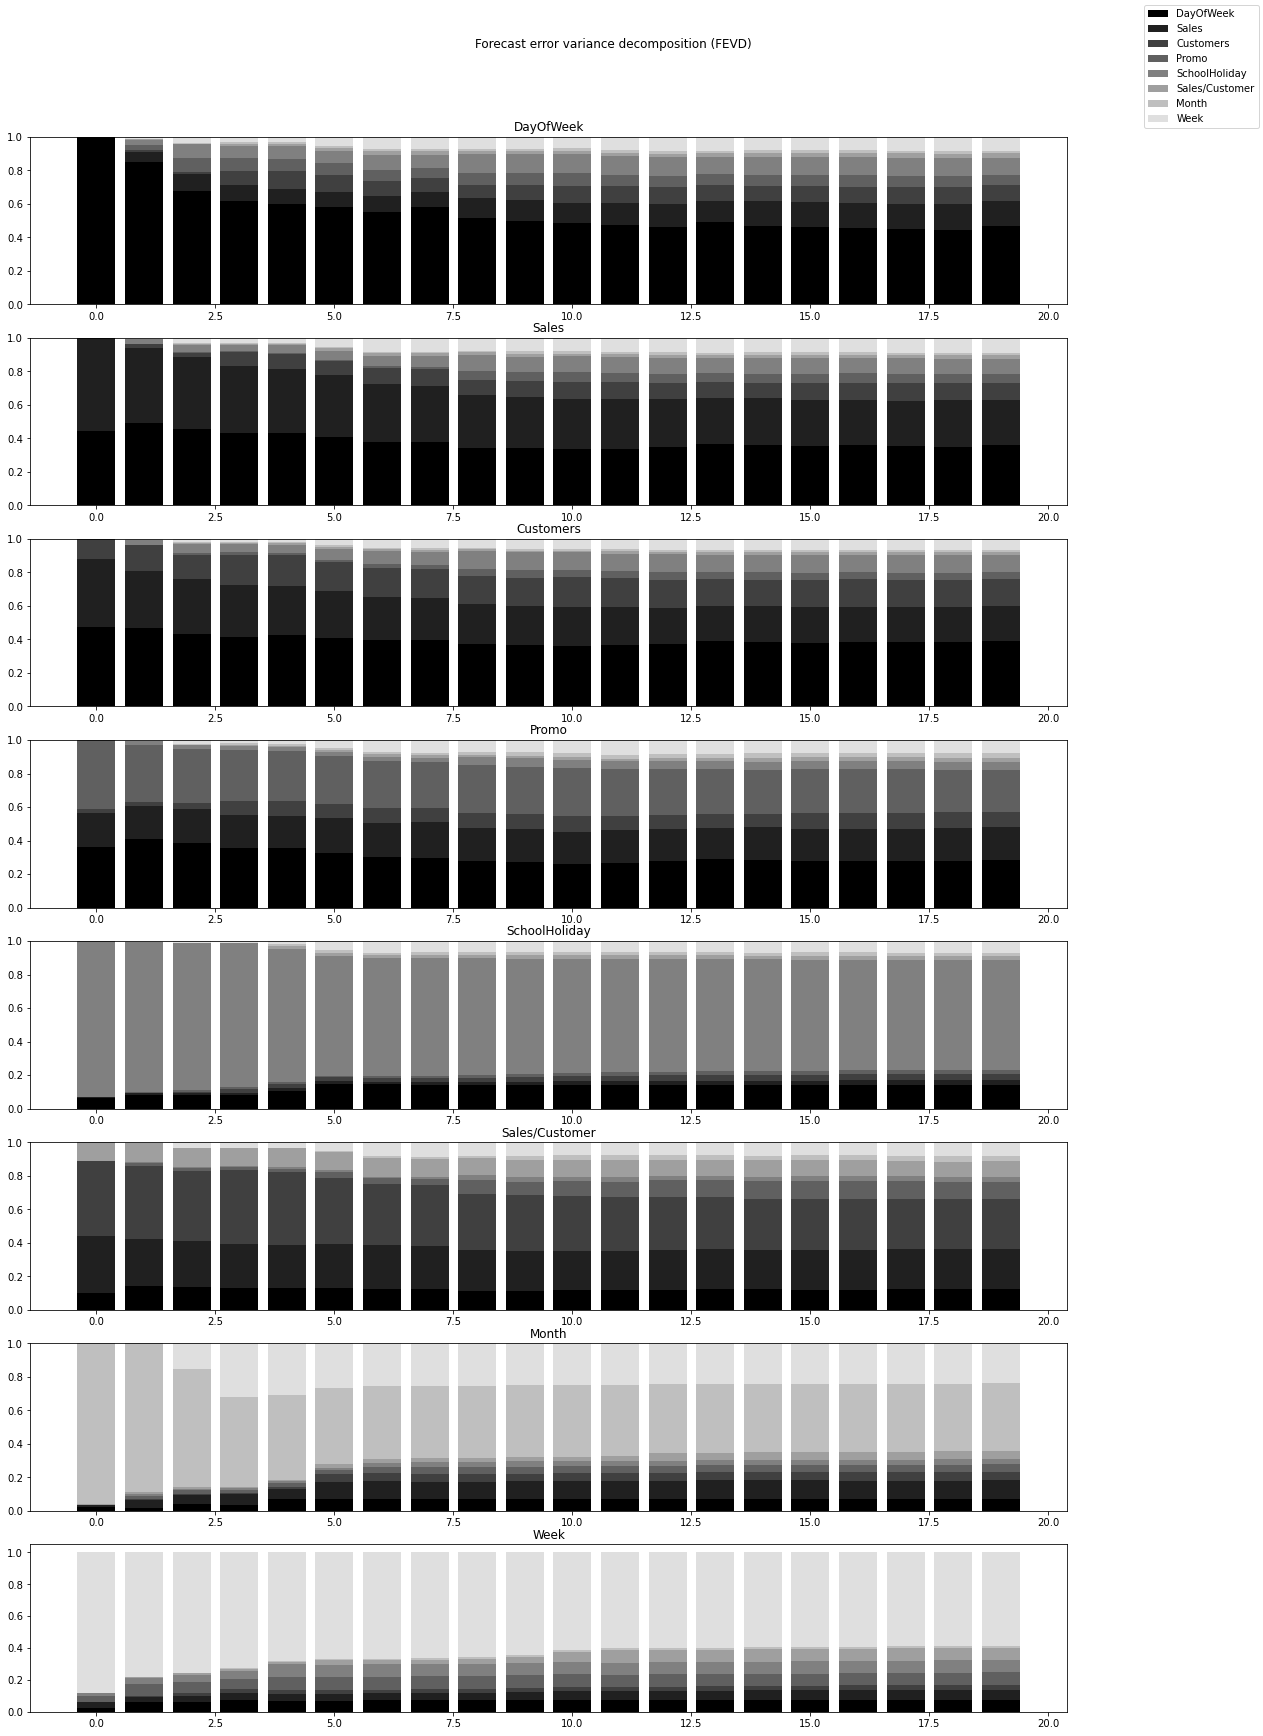

In [153]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [154]:
# Use the adfuller_test function on data.

for name, column in Store8.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3404
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.1666
 No. Lags Chosen      = 18
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.022. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.0

In [155]:
# look for the columns which have same value in all its rows.

Store8.nunique()

DayOfWeek           6
Sales             751
Customers         446
Promo               2
SchoolHoliday       2
Sales/Customer    782
Month              12
Week               52
dtype: int64

In [156]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store8 = Store8[["Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Month"]]

In [157]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store8[0:-nobs], Store8[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(742, 6)
(42, 6)


In [158]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  Month
index                                                                       
2013-01-03 -0.185920  -0.089739    0.0            0.0       -0.449411    0.0
2013-01-04 -0.252297  -0.361449    0.0            0.0        0.536864    0.0
2013-01-05 -0.554861  -0.511014    0.0           -1.0       -0.360679    0.0
2013-01-07  1.636549   1.221447    1.0            0.0        1.756498    0.0
2013-01-08 -0.348963  -0.254260    0.0            0.0       -0.199740    0.0

In [159]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.414
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.2861
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Te


1. Now all features are stationary. lets build the model.

In [160]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -14.304189822200357
BIC :  -14.042731298118836
FPE :  6.134381233992786e-07
HQIC:  -14.203381110525205 

Lag Order = 2
AIC :  -15.149915597184505
BIC :  -14.663835437733951
FPE :  2.6332052562263873e-07
HQIC:  -14.962489293256851 

Lag Order = 3
AIC :  -15.556240903782548
BIC :  -14.84506258941337
FPE :  1.754042338726633e-07
HQIC:  -15.282002312314189 

Lag Order = 4
AIC :  -16.26645733014567
BIC :  -15.329702670948382
FPE :  8.622539514331895e-08
HQIC:  -15.905211057259702 

Lag Order = 5
AIC :  -17.103202176427615
BIC :  -15.940391304031458
FPE :  3.735111893540604e-08
HQIC:  -16.654752126231585 

Lag Order = 6
AIC :  -17.313566909528877
BIC :  -15.924218268950304
FPE :  3.0271599972373656e-08
HQIC:  -16.777716280666603 

Lag Order = 7
AIC :  -17.473961767518038
BIC :  -15.857592108958713
FPE :  2.5793175819592386e-08
HQIC:  -16.85051304969999 

Lag Order = 8
AIC :  -17.487688974374827
BIC :  -15.643813344968722
FPE :  2.5451507874284016e-08
HQIC:  -16.776443944

In [161]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [162]:
# Fit the lowest metrics' lag which is 12.

res = mod.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:36
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -14.9482
Nobs:                     729.000    HQIC:                  -16.6425
Log likelihood:           685.743    FPE:                2.04988e-08
AIC:                     -17.7069    Det(Omega_mle):     1.15624e-08
--------------------------------------------------------------------
Results for equation Sales
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.003851         0.012819            0.300           0.764
L1.Sales                  -0.026708         0.316973           -0.084           0.933
L1.Customers              -1.296087     

In [163]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store8.index[-42:], columns = Store8.columns)
predict_data

Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13 -0.539811  -0.539038 -0.087168      -0.015334        0.132957   
2015-06-15  1.438842   0.989294  0.749704       0.087863        1.272301   
2015-06-16 -0.293846  -0.193325 -0.002702      -0.134449       -0.190944   
2015-06-17  0.064117   0.114818  0.257510       0.081741       -0.139839   
2015-06-18  0.211624   0.292544  0.101093       0.013033       -0.410044   
2015-06-19 -0.510039  -0.465691 -0.141166      -0.032605        0.078293   
2015-06-20 -0.710120  -0.558988 -0.722868      -0.065976       -0.655752   
2015-06-22  0.542262   0.513575  0.116702       0.021834       -0.036587   
2015-06-23 -0.111835  -0.084489 -0.096583       0.041261       -0.001158   
2015-06-24 -0.001181   0.014579 -0.032142       0.008249       -0.087450   
2015-06-25  0.069662   0.167651 -0.012326      -0.025759       -0.371365   
2015-06-26 -0.215389  -0.297182 -0.023757      -0.008794        0.348924   
2015-06-27 -0.282140  -0.296812 -0.122530      -0.029691        0.073297   
2015-06-29  0.921954   0.639993  0.489937       0.089349        0.928259   
2015-06-30 -0.147263  -0.087870  0.028416      -0.045619       -0.177277   
2015-07-01  0.117349   0.110003  0.205350       0.063342        0.093779   
2015-07-02  0.162046   0.201754  0.106838      -0.018389       -0.209893   
2015-07-03 -0.406351  -0.385840 -0.098744      -0.061250        0.063355   
2015-07-04 -0.390614  -0.296399 -0.425346      -0.035664       -0.435708   
2015-07-06  0.382013   0.352093  0.108487       0.035279        0.049705   
2015-07-07 -0.110393  -0.077245 -0.078350       0.009445       -0.096887   
2015-07-08 -0.018192   0.020406 -0.053359       0.038206       -0.149086   
2015-07-09  0.019151   0.090857 -0.053164      -0.019493       -0.276553   
2015-07-10 -0.247145  -0.288701 -0.069492      -0.026438        0.203252   
2015-07-11 -0.098693  -0.124050 -0.080088      -0.023846        0.079113   
2015-07-13  0.607000   0.430696  0.327708       0.059789        0.594457   
2015-07-14 -0.092502  -0.058374  0.036079      -0.021876       -0.081695   
2015-07-15  0.116313   0.105527  0.168816       0.054873        0.073202   
2015-07-16  0.083603   0.103178  0.079898      -0.022331       -0.097322   
2015-07-17 -0.309675  -0.306882 -0.086346      -0.051319        0.076562   
2015-07-18 -0.189191  -0.135450 -0.243655      -0.024323       -0.269821   
2015-07-20  0.301448   0.270251  0.108031       0.040074        0.070781   
2015-07-21 -0.119994  -0.077681 -0.072059      -0.001992       -0.138611   
2015-07-22 -0.017837   0.022416 -0.047676       0.030532       -0.152767   
2015-07-23 -0.026938   0.025990 -0.065427      -0.018146       -0.205461   
2015-07-24 -0.214601  -0.240797 -0.085479      -0.023833        0.138472   
2015-07-25 -0.002306  -0.030557 -0.045655      -0.013527        0.077993   
2015-07-27  0.414264   0.302301  0.227373       0.044385        0.383521   
2015-07-28 -0.070869  -0.046851  0.033524      -0.014272       -0.049213   
2015-07-29  0.097702   0.087632  0.128562       0.038866        0.057298   
2015-07-30  0.029786   0.038929  0.052793      -0.021096       -0.040443   
2015-07-31 -0.230601  -0.233396 -0.074928      -0.036418        0.063536   

               Month  
index                 
2015-06-13  0.127068  
2015-06-15 -0.487665  
2015-06-16 -0.166099  
2015-06-17  0.116614  
2015-06-18  0.148109  
2015-06-19 -0.094241  
2015-06-20  0.079957  
2015-06-22  0.029821  
2015-06-23  0.060147  
2015-06-24  0.166363  
2015-06-25  0.065907  
2015-06-26  0.045288  
2015-06-27  0.034267  
2015-06-29 -0.221558  
2015-06-30 -0.191863  
2015-07-01 -0.017013  
2015-07-02  0.040989  
2015-07-03  0.028497  
2015-07-04  0.044023  
2015-07-06  0.089129  
2015-07-07  0.018342  
2015-07-08  0.063593  
2015-07-09  0.027583  
2015-07-10  0.061496  
2015-07-11  0.007939  
2015-07-13 -0.085212  
2015-07-14 -0.103648  
201

In [164]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

               Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13 -1.667322  -1.450708 -0.087168      -0.015334        8.838247   
2015-06-15  1.859819   0.887163  1.662535       0.072528       11.999075   
2015-06-16  1.066212   0.546766  1.659833      -0.061920       10.754702   
2015-06-17  0.925720   0.384889  1.917343       0.019821       11.166924   
2015-06-18  0.992668   0.934186  2.018436       0.032854        9.047900   
2015-06-19  0.312176   0.017307  1.877270       0.000249       10.558668   
2015-06-20 -1.416800  -1.242144  0.154402      -0.065727        8.915825   
2015-06-22 -0.492709  -0.177671  0.271104      -0.043893        7.663085   
2015-06-23 -0.377380   0.059404  0.174521      -0.002632        7.296922   
2015-06-24 -0.538382  -0.260045  0.142379       0.005616        7.969778   
2015-06-25 -0.162290   0.271548  0.130053      -0.020143        7.315446   
2015-06-26 -

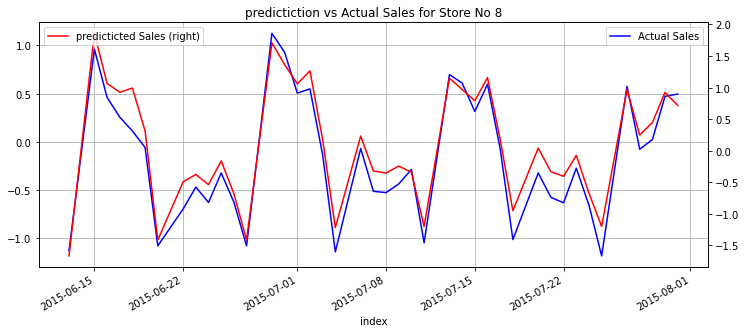

In [165]:
# Plot shows the actual sales and predicticted sales for Store No 8.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 8")

plt.show()

In [166]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.258061
Mean Squared Error(MSE) : 0.160402
Root Mean Square Error(RMSE) : 0.400502
Mean Absolute Percentage Error(MAPE) : 29.710000
Mean Absolute Error(MAE): 0.334140


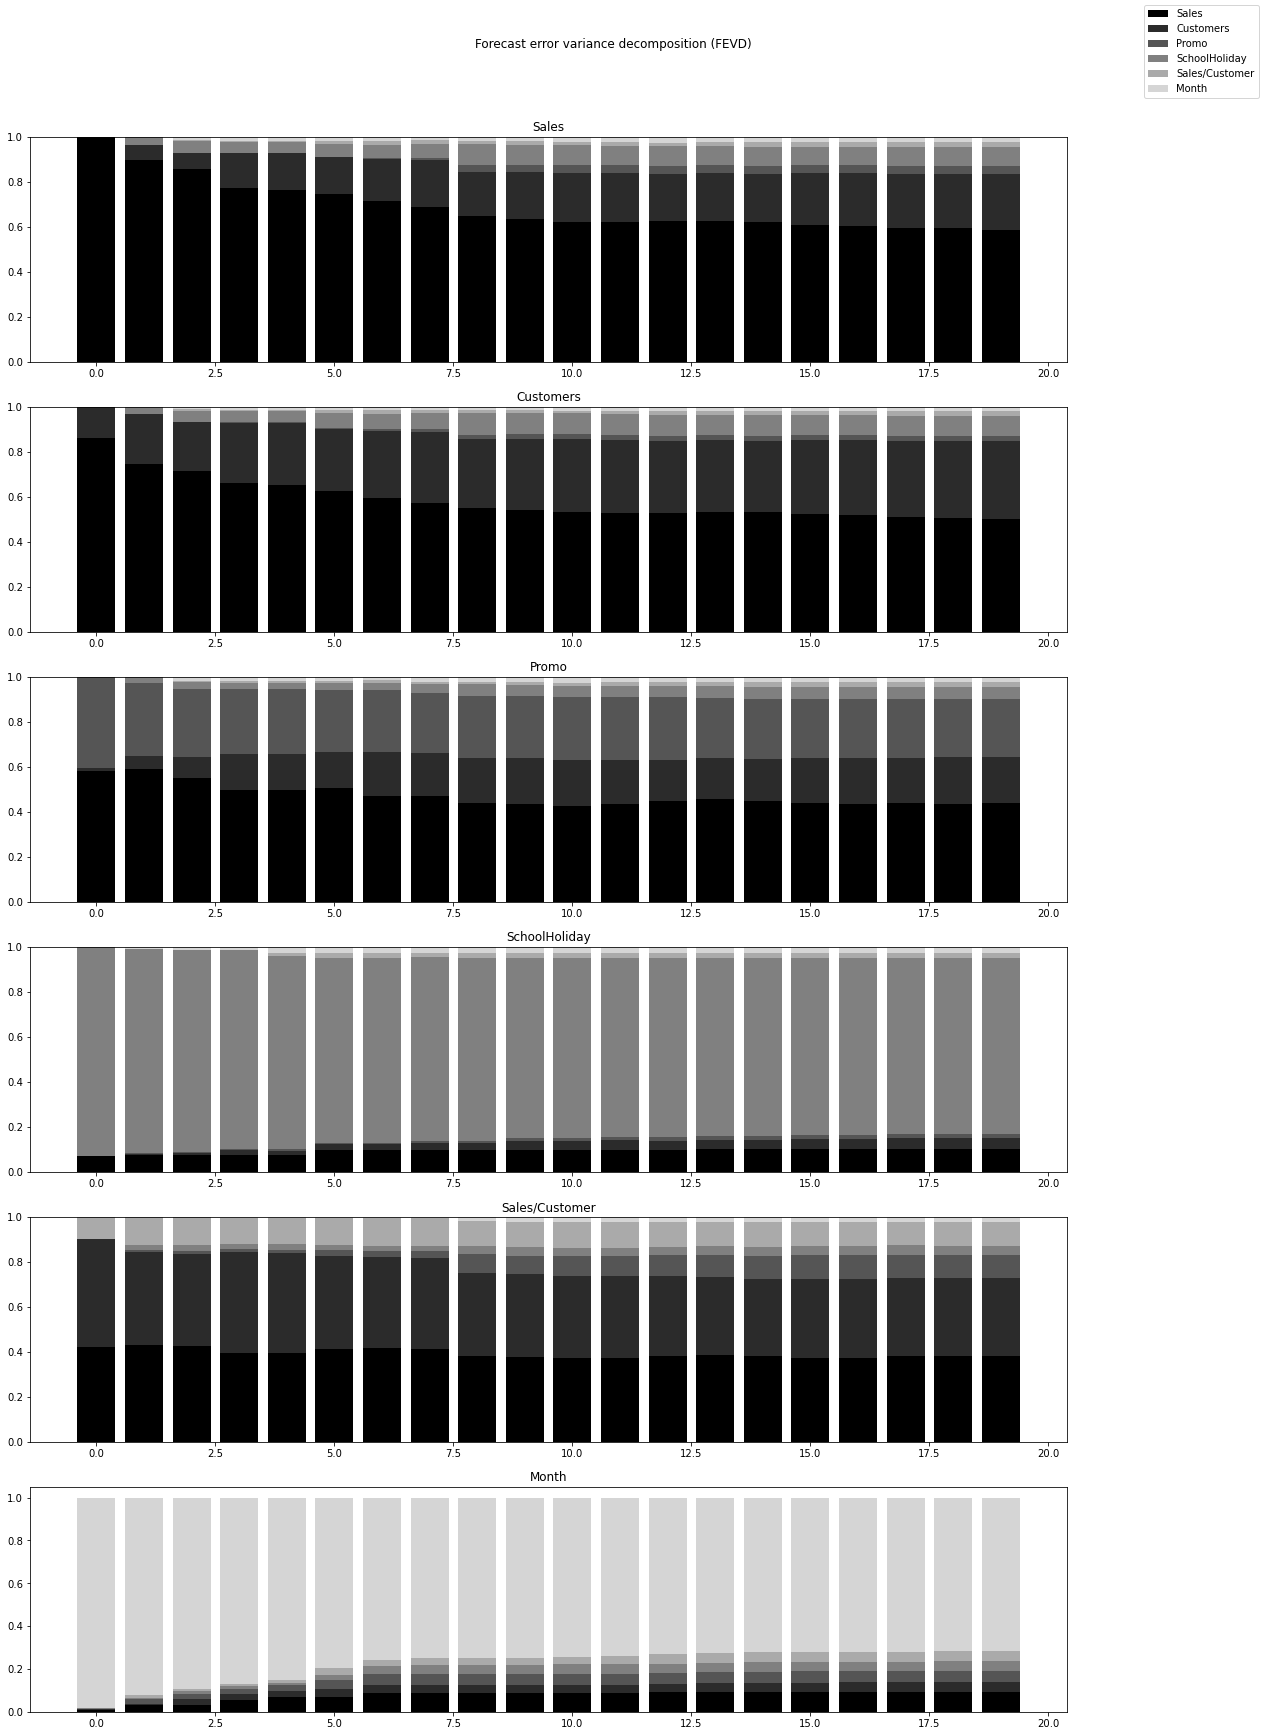

In [167]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.4. Model for Store No. 9.

### Model 1.

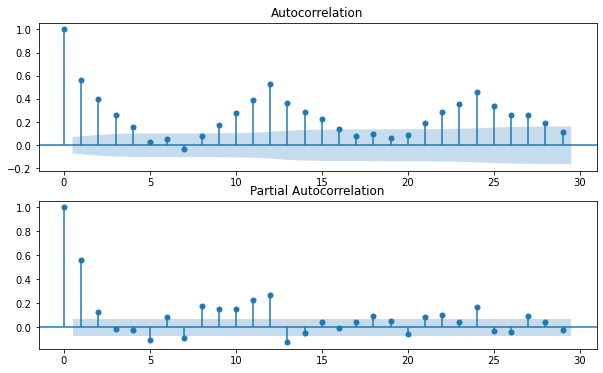

In [168]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store9.Sales, ax = ax[0])
ax[1] = plot_pacf(Store9.Sales, ax = ax[1])

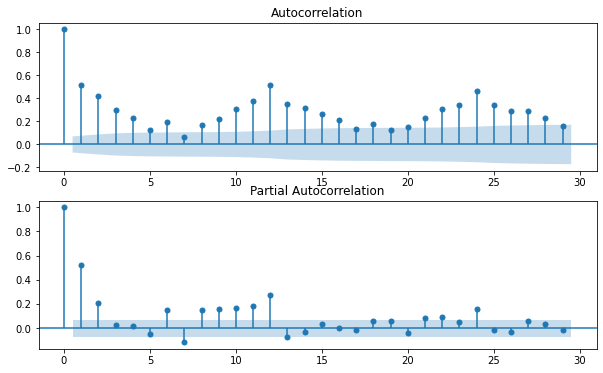

In [169]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store9.Customers, ax = ax[0])
ax[1] = plot_pacf(Store9.Customers, ax = ax[1])

In [170]:
# Use the adfuller_test function on data.

for name, column in Store9.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [171]:
# look for the columns which have same value in all its rows.

Store9.nunique()

Store                          1
DayOfWeek                      6
Sales                        723
Customers                    321
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               776
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [172]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store9 = Store9[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", "Day",
                        "Week"]]

In [173]:
# examine data.

Store9.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.661261  -0.702278      0              1   
2013-01-03          4 -0.758249  -0.772075      0              1   
2013-01-04          5 -0.695094  -0.662394      0              1   
2013-01-05          6 -0.870381  -0.779554      0              0   
2013-01-07          1  0.199385  -0.393177      1              0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-02       10.193347  2013      1    2     1  
2013-01-03       10.158940  2013      1    3     1  
2013-01-04        9.653924  2013      1    4     1  
2013-01-05        9.453333  2013      1    5     1  
2013-01-07       12.519008  2013      1    7     2

In [174]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store9[0:-nobs], Store9[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 10)
(42, 10)


In [175]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0 -0.096988  -0.069797    0.0            0.0   
2013-01-04        1.0  0.063155   0.109681    0.0            0.0   
2013-01-05        1.0 -0.175287  -0.117159    0.0           -1.0   
2013-01-07       -5.0  1.069766   0.386376    1.0            0.0   
2013-01-08        1.0 -0.440795  -0.216869    0.0            0.0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-03       -0.034407   0.0    0.0  1.0   0.0  
2013-01-04       -0.505017   0.0    0.0  1.0   0.0  
2013-01-05       -0.200590   0.0    0.0  1.0   0.0  
2013-01-07        3.065675   0.0    0.0  2.0   1.0  
2013-01-08       -0.538313   0.0    0.0  1.0   0.0

In [176]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1558
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.5206
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [177]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:41
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -23.0200
Nobs:                     725.000    HQIC:                  -27.3317
Log likelihood:           1712.76    FPE:                9.19728e-14
AIC:                     -30.0416    Det(Omega_mle):     2.21298e-14
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.473293         0.427757            1.106           0.269
L1.DayOfWeek              -0.884770         0.056566          -15.641           0.000
L1.Sales                   0.238756 

In [178]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store9.index[-42:], columns = Store9.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13  -0.459360  0.293314   0.094239 -0.074453       0.122625   
2015-06-15  -4.098560  0.577702   0.298842  0.682365       0.111713   
2015-06-16   2.114165 -0.322087  -0.228010 -0.241038      -0.266747   
2015-06-17   0.616594  0.075575   0.076072  0.035731       0.006899   
2015-06-18   1.144510 -0.076181  -0.023449 -0.068899      -0.059172   
2015-06-19  -0.034001  0.263348   0.152178  0.094217       0.091890   
2015-06-20  -0.042043 -0.121793  -0.058397 -0.284954       0.082788   
2015-06-22  -2.945593  0.038647   0.040484  0.343462       0.106458   
2015-06-23   1.494547 -0.312624  -0.152262 -0.011489      -0.156148   
2015-06-24   0.545490 -0.079023  -0.036874  0.014331       0.046709   
2015-06-25   0.978845 -0.110238  -0.071528 -0.297445      -0.021478   
2015-06-26  -0.410018  0.036408   0.017930 -0.159651      -0.099285   
2015-06-27  -0.307903  0.005768  -0.026823 -0.155360       0.099573   
2015-06-29  -2.088093  0.327465   0.174467  0.368131       0.098066   
2015-06-30   1.743220 -0.281645  -0.143345 -0.170708      -0.106822   
2015-07-01   0.271874  0.130662   0.065338  0.109623       0.016980   
2015-07-02   0.513013  0.133946   0.068022  0.123069      -0.045098   
2015-07-03  -0.448843  0.189686   0.092041  0.143214      -0.018593   
2015-07-04  -0.094914 -0.105182  -0.052815 -0.167857       0.005606   
2015-07-06  -1.636165  0.026196   0.034631  0.251898       0.097284   
2015-07-07   1.453096 -0.238898  -0.120263 -0.066403      -0.073021   
2015-07-08   0.372924 -0.011930  -0.008628 -0.069875       0.003919   
2015-07-09   0.237965 -0.055898  -0.024748 -0.182379       0.022569   
2015-07-10  -0.385921 -0.006679  -0.006118 -0.092397      -0.041276   
2015-07-11  -0.316011  0.003963  -0.009492 -0.070357       0.016148   
2015-07-13  -1.117085  0.137865   0.074883  0.199489       0.088621   
2015-07-14   1.384980 -0.189165  -0.094232 -0.147482      -0.076912   
2015-07-15   0.176788  0.101510   0.047313  0.027526      -0.005247   
2015-07-16   0.027229  0.143601   0.071565  0.097812       0.006246   
2015-07-17  -0.285757  0.086100   0.036862  0.080476      -0.033447   
2015-07-18  -0.236455 -0.046568  -0.024521 -0.039669       0.010835   
2015-07-20  -0.819879  0.019362   0.020203  0.205058       0.066067   
2015-07-21   1.109221 -0.121604  -0.061306 -0.017103      -0.048454   
2015-07-22   0.289436  0.004004  -0.000527 -0.070661      -0.011806   
2015-07-23  -0.108864 -0.019684  -0.002883 -0.115832       0.016957   
2015-07-24  -0.315967 -0.043394  -0.020972 -0.074445      -0.011128   
2015-07-25  -0.240617 -0.013047  -0.010700 -0.050481       0.008897   
2015-07-27  -0.517865  0.038076   0.023789  0.079322       0.056913   
2015-07-28   0.965298 -0.116976  -0.057682 -0.111105      -0.048065   
2015-07-29   0.171104  0.071060   0.029039 -0.002359      -0.021582   
2015-07-30  -0.232148  0.136420   0.066966  0.092616       0.016835   
2015-07-31  -0.180380  0.036130   0.012513  0.053751      -0.024438   

            Sales/Customer      Year     Month       Day      Week  
index                                                               
2015-06-13        0.656599  0.013592 -0.251446  3.728349 -4.009414  
2015-06-15        0.477711 -0.022381  0.359539 -0.754252  0.455752  
2015-06-16        0.043194  0.044945 -0.465437 -1.407167 -0.048612  
2015-06-17       -0.109635  0.030802 -0.274490 -1.606927  0.913555  
2015-06-18       -0.145117  0.010687  0.024913 -3.714480  0.108575  
2015-06-19        0.257705  0.003925  0.006181 -0.401307  1.691447  
2015-06-20       -0.124176 -0.008291  0.155946 -0.462979  2.151598  
2015-06-22       -0.124990 -0.011859  0.208714 -0.348771  0.923112  
2015-06-23       -0.382827 -0.042554  0.454873  2.646570  0.466701  
2015-06-24       -0.090507 -0.021578  0.268221  0.919783 -0.576394  
2015-06-25       -0.018319 -0.004626  0.037540  1.575471 -0

In [179]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.540640  0.038694  -0.463460 -0.074453       0.122625   
2015-06-15  -3.557920  2.345099   0.625584  1.607913       0.234338   
2015-06-16  -0.443754  1.232932   0.076009  1.366875      -0.032410   
2015-06-17   1.172840  0.975656  -0.084730  1.402606      -0.025510   
2015-06-18   3.317350  0.916552  -0.123135  1.333707      -0.084682   
2015-06-19   4.283348  1.099667   0.086377  1.427924       0.007208   
2015-06-20   5.241306  0.439768  -0.253701  0.142970       0.089996   
2015-06-22  -2.704288  0.459726  -0.103535  0.486432       0.196454   
2015-06-23  -0.209741  0.015959  -0.330580  0.474942       0.040306   
2015-06-24   1.335750  0.315221  -0.192961  0.489274       0.087015   
2015-06-25   3.314595  0.136028  -0.264489  0.191828       0.065537   
2015-06-26   3.904576  0.132158  -0.296414  0.032177      -0.033748   
2015-0

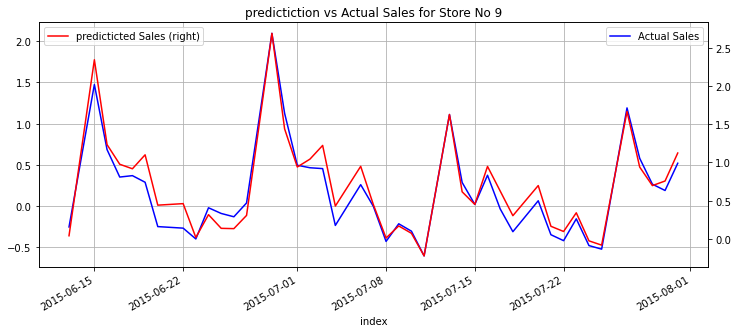

In [180]:
# Plot shows the actual sales and predicticted sales for Store No 9.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 9")
plt.show()

In [181]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.507933
Mean Squared Error(MSE) : 0.281363
Root Mean Square Error(RMSE) : 0.530437
Mean Absolute Percentage Error(MAPE) : -215.320000
Mean Absolute Error(MAE): 0.507933


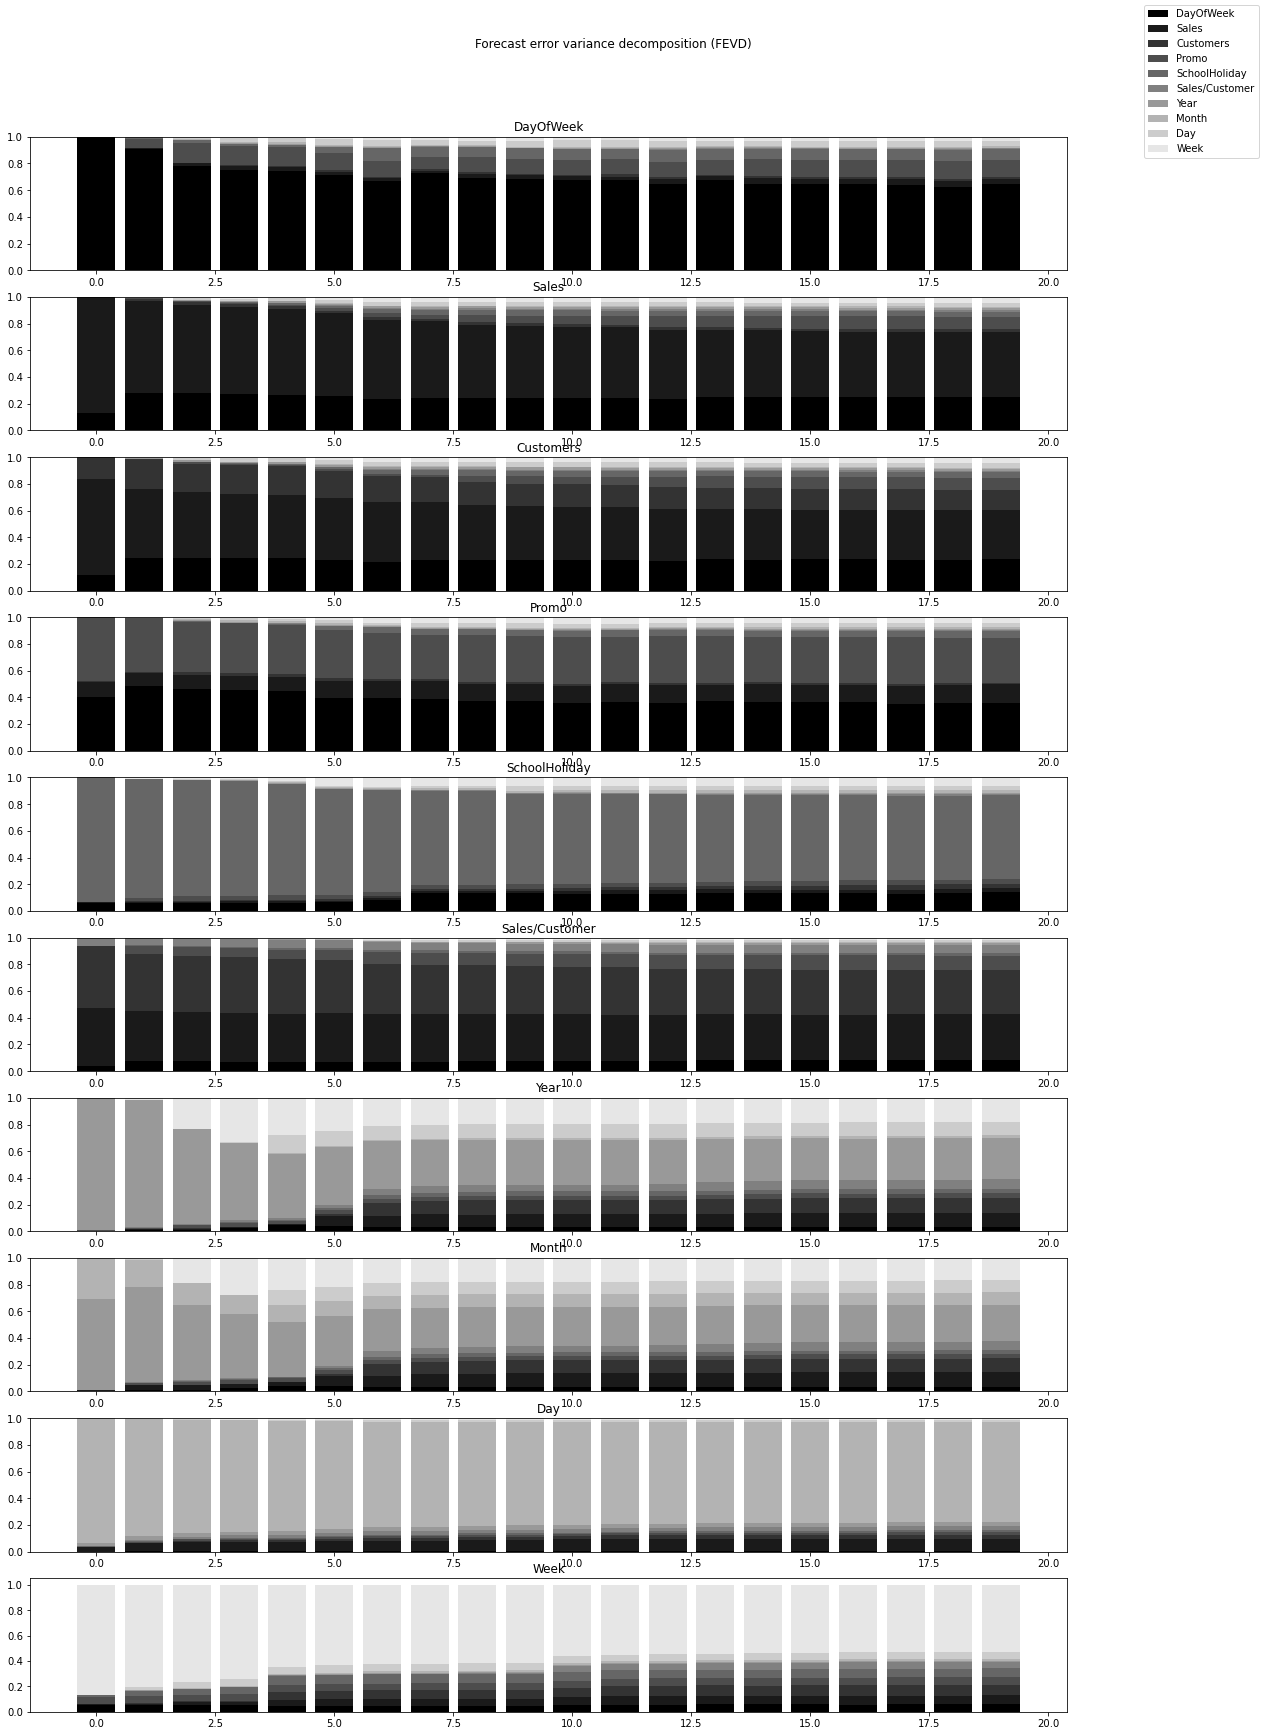

In [182]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [183]:
# Use the adfuller_test function on data.

for name, column in Store9.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.6716
 No. Lags Chosen      = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0791. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Sig

In [184]:
# look for the columns which have same value in all its rows.

Store9.nunique()

DayOfWeek           6
Sales             723
Customers         321
Promo               2
SchoolHoliday       2
Sales/Customer    776
Year                3
Month              12
Day                31
Week               52
dtype: int64

In [185]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store9 = Store9[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday"]]

In [186]:
# examine data.

Store9.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday
index                                                           
2013-01-02          3 -0.661261  -0.702278      0              1
2013-01-03          4 -0.758249  -0.772075      0              1
2013-01-04          5 -0.695094  -0.662394      0              1
2013-01-05          6 -0.870381  -0.779554      0              0
2013-01-07          1  0.199385  -0.393177      1              0

In [187]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store9[0:-nobs], Store9[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 5)
(42, 5)


In [188]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday
index                                                           
2013-01-03        1.0 -0.096988  -0.069797    0.0            0.0
2013-01-04        1.0  0.063155   0.109681    0.0            0.0
2013-01-05        1.0 -0.175287  -0.117159    0.0           -1.0
2013-01-07       -5.0  1.069766   0.386376    1.0            0.0
2013-01-08        1.0 -0.440795  -0.216869    0.0            0.0

In [189]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1558
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.5206
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [190]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -11.501610265710948
BIC :  -11.313860449416545
FPE :  1.0113812922783484e-05
HQIC:  -11.429198018567396 

Lag Order = 2
AIC :  -11.962752516121911
BIC :  -11.618177588909653
FPE :  6.377455942433999e-06
HQIC:  -11.829846781703337 

Lag Order = 3
AIC :  -12.310700978252584
BIC :  -11.808966113108065
FPE :  4.503452196605941e-06
HQIC:  -12.117164915806876 

Lag Order = 4
AIC :  -13.026768428318583
BIC :  -12.367537616889708
FPE :  2.2007998747724732e-06
HQIC:  -12.772464702924577 

Lag Order = 5
AIC :  -14.145072844307107
BIC :  -13.32800889113683
FPE :  7.193464498002746e-07
HQIC:  -13.829863624434752 

Lag Order = 6
AIC :  -14.486991131009678
BIC :  -13.511755647732858
FPE :  5.110821036639954e-07
HQIC:  -14.110738086064956 

Lag Order = 7
AIC :  -14.60130468463472
BIC :  -13.467558084138755
FPE :  4.559408859338984e-07
HQIC:  -14.163868982489163 

Lag Order = 8
AIC :  -14.6788448093424
BIC :  -13.386246299891411
FPE :  4.2200518506046546e-07
HQIC:  -14.18008711384

In [191]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [192]:
# Fit the lowest metrics' lag which is 15

res = mod.fit(15)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -12.5458
Nobs:                     721.000    HQIC:                  -14.0281
Log likelihood:           657.816    FPE:                3.19631e-07
AIC:                     -14.9600    Det(Omega_mle):     1.93657e-07
--------------------------------------------------------------------
Results for equation DayOfWeek
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.005998         0.026845            0.223           0.823
L1.DayOfWeek             -0.902485         0.051741          -17.442           0.000
L1.Sales                 -0.948052      

In [193]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store9.index[-42:], columns = Store9.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday
index                                                              
2015-06-13   0.573629  0.413028   0.130182 -0.030422       0.023569
2015-06-15  -3.913156  0.699440   0.364038  0.650870      -0.026247
2015-06-16   0.488871 -0.378382  -0.177137  0.097392      -0.184622
2015-06-17   0.720647 -0.005997  -0.006461  0.059233       0.144949
2015-06-18   1.091794 -0.022377   0.013267  0.023913      -0.002665
2015-06-19   1.450225  0.090135   0.004721 -0.189460      -0.008977
2015-06-20  -0.911780 -0.040422   0.009004 -0.345098      -0.048299
2015-06-22  -2.734687 -0.120546  -0.059366  0.081993       0.086841
2015-06-23   0.328411 -0.191645  -0.066060 -0.086176       0.019004
2015-06-24   1.101078 -0.165441  -0.065106 -0.019070       0.026160
2015-06-25   1.149916  0.035147  -0.013301 -0.058960      -0.050058
2015-06-26   0.564535 -0.026418  -0.006871 -0.238298      -0.057114
2015-06-27  -0.802616  0.135962   0.060574  0.005541       0.060861
2015-06-29  -2.173114  0.310276   0.142862  0.392888       0.085316
2015-06-30   0.587552 -0.161648  -0.085461  0.102254      -0.068895
2015-07-01   0.747287 -0.032406  -0.013899  0.083941       0.038539
2015-07-02   1.240734  0.011321  -0.000376  0.013874      -0.072787
2015-07-03  -0.021227  0.198297   0.095430  0.020921      -0.018998
2015-07-04  -0.652374 -0.008916  -0.004947 -0.171546      -0.006902
2015-07-06  -1.693300 -0.033729  -0.004998  0.095647       0.061434
2015-07-07   0.490427 -0.171385  -0.073802 -0.021665       0.019789
2015-07-08   1.094051 -0.124653  -0.061104 -0.094223      -0.022216
2015-07-09   0.626621  0.024141   0.019287 -0.138438      -0.048876
2015-07-10  -0.140310  0.018382   0.003331 -0.145895      -0.003885
2015-07-11  -0.699999  0.065285   0.028256 -0.017137      -0.018222
2015-07-13  -1.214746  0.097586   0.048867  0.214230       0.084338
2015-07-14   0.643371 -0.094659  -0.052249  0.080819      -0.012937
2015-07-15   0.900078 -0.026850  -0.015015 -0.008174      -0.025663
2015-07-16   0.268017  0.106543   0.051437  0.055176      -0.006466
2015-07-17  -0.185981  0.106374   0.046750  0.034653      -0.020663
2015-07-18  -0.503199 -0.023697  -0.013667 -0.054590      -0.006762
2015-07-20  -0.883799 -0.021355  -0.002245  0.090256       0.063990
2015-07-21   0.661410 -0.126922  -0.057340 -0.021437       0.001651
2015-07-22   0.679160 -0.027006  -0.013569 -0.069766      -0.011509
2015-07-23   0.173586  0.028067   0.017003 -0.102272      -0.023050
2015-07-24  -0.294856 -0.003773  -0.002298 -0.080484      -0.010516
2015-07-25  -0.441159  0.016429   0.005320 -0.006594      -0.008856
2015-07-27  -0.562527  0.042993   0.023167  0.117588       0.049150
2015-07-28   0.584874 -0.057167  -0.029036  0.016271      -0.007227
2015-07-29   0.536928 -0.005401  -0.006031 -0.029568      -0.018750
2015-07-30  -0.052527  0.088369   0.043723  0.044553      -0.012921
2015-07-31  -0.237077  0.052029   0.022201  0.030595      -0.004537

In [194]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday
index                                                              
2015-06-13   6.573629  0.158407  -0.427517 -0.030422       0.023569
2015-06-15  -2.339527  2.586551   0.726723  1.620449      -0.002678
2015-06-16  -0.850655  1.418088   0.228021  1.717840      -0.187300
2015-06-17   0.869992  1.079239  -0.015250  1.777074      -0.042351
2015-06-18   2.961786  1.073940  -0.016940  1.800987      -0.045016
2015-06-19   5.412012  1.083843   0.045114  1.611527      -0.053992
2015-06-20   5.500232  0.505315  -0.227563  0.266429      -0.102291
2015-06-22  -2.234456  0.366080  -0.177249  0.348422      -0.015450
2015-06-23  -0.906045  0.043292  -0.318091  0.262246       0.003554
2015-06-24   1.195034  0.256136  -0.208704  0.243175       0.029714
2015-06-25   3.344949  0.222328  -0.222005  0.184216      -0.020344
2015-06-26   4.909485  0.155633  -0.278731 -0.054082      -0.077457
2015-06-27   5.106868  0.459149  -0.205693 -0.04

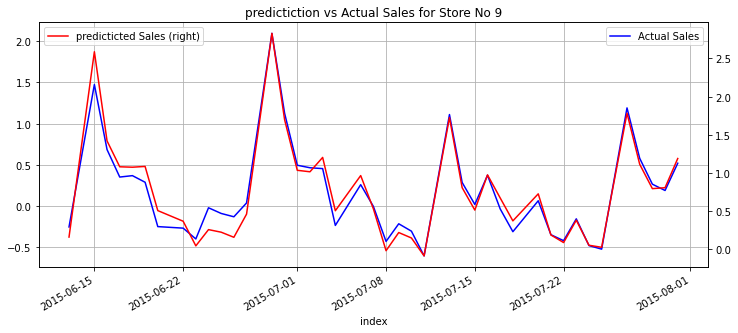

In [195]:
# Plot shows the actual sales and predicticted sales for Store No 9.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 9")
plt.show()

In [196]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.581729
Mean Squared Error(MSE) : 0.361894
Root Mean Square Error(RMSE) : 0.601576
Mean Absolute Percentage Error(MAPE) : -233.110000
Mean Absolute Error(MAE): 0.581729


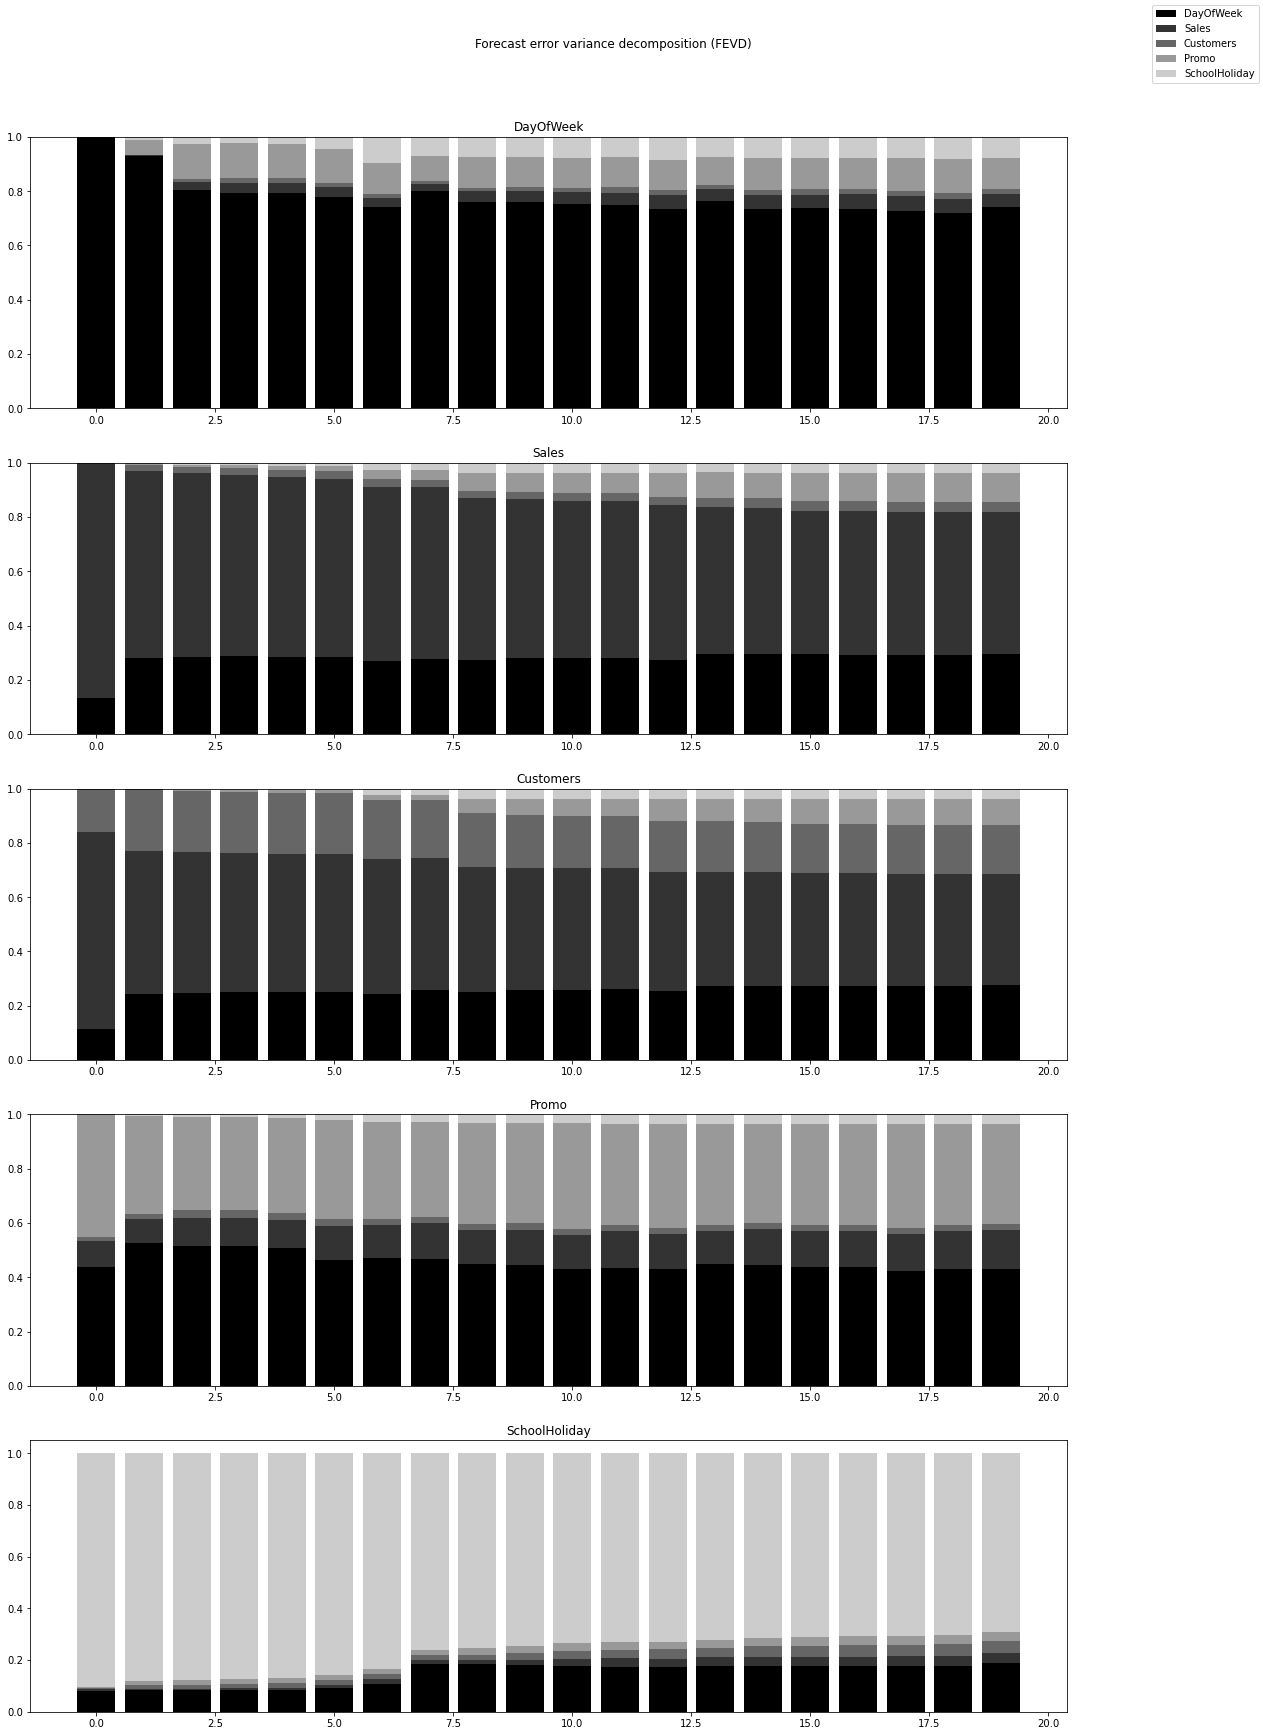

In [197]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.5. Model for Store No. 13.

### Model 1.

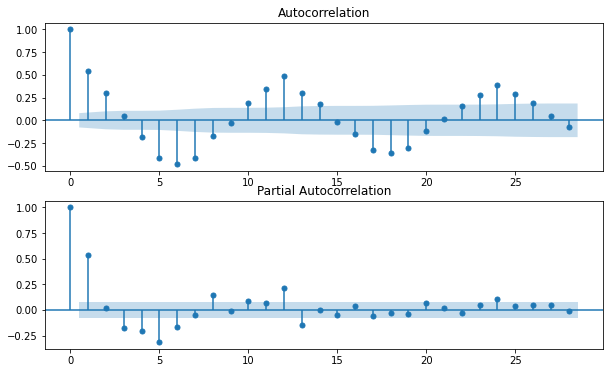

In [198]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store13.Sales, ax = ax[0])
ax[1] = plot_pacf(Store13.Sales, ax = ax[1])

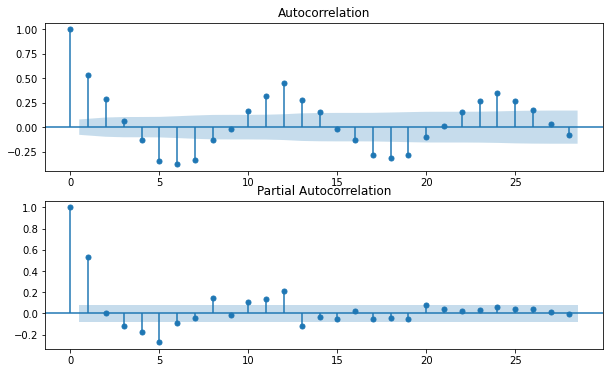

In [199]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store13.Customers, ax = ax[0])
ax[1] = plot_pacf(Store13.Customers, ax = ax[1])

In [200]:
# Use the adfuller_test function on data.

for name, column in Store13.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3336
 No. Lags Chosen      = 15
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [201]:
# look for the columns which have same value in all its rows.

Store13.nunique()

Store                          1
DayOfWeek                      6
Sales                        587
Customers                    275
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               621
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              25
PromoOpen                    106
dtype: int64

In [202]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store13 = Store13[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", 
                           "Day", "Week"]]

In [203]:
# examine data.

Store13.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -1.036968  -1.111089      0              1   
2013-01-03          4 -1.057267  -1.173408      0              1   
2013-01-04          5 -1.001201  -1.053756      0              1   
2013-01-05          6 -0.860392  -1.043785      0              0   
2013-01-07          1  0.415916  -0.482916      1              0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-02       11.788644  2013      1    2     1  
2013-01-03       12.582192  2013      1    3     1  
2013-01-04       11.317647  2013      1    4     1  
2013-01-05       12.456395  2013      1    5     1  
2013-01-07       14.492091  2013      1    7     2

In [204]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store13[0:-nobs], Store13[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(579, 10)
(42, 10)


In [205]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0 -0.020300  -0.062319    0.0            0.0   
2013-01-04        1.0  0.056066   0.119652    0.0            0.0   
2013-01-05        1.0  0.140810   0.009971    0.0           -1.0   
2013-01-07       -5.0  1.276308   0.560869    1.0            0.0   
2013-01-08        1.0 -0.498150  -0.249275    0.0            0.0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-03        0.793548   0.0    0.0  1.0   0.0  
2013-01-04       -1.264545   0.0    0.0  1.0   0.0  
2013-01-05        1.138748   0.0    0.0  1.0   0.0  
2013-01-07        2.035696   0.0    0.0  2.0   1.0  
2013-01-08       -0.206377   0.0    0.0  1.0   0.0

In [206]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -11.4022
 No. Lags Chosen      = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -9.2941
 No. Lags Chosen      = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 


1. Now all features are stationary. lets build the model.

In [207]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:49:53
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -21.9703
Nobs:                     570.000    HQIC:                  -25.7362
Log likelihood:           743.558    FPE:                6.09416e-13
AIC:                     -28.1456    Det(Omega_mle):     1.61381e-13
--------------------------------------------------------------------
Results for equation DayOfWeek
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.030913         0.034749            0.890           0.374
L1.DayOfWeek             -0.840540         0.056925          -14.766           0.000
L1.Sales                  1.051492      

In [208]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store13.index[-42:], columns = Store13.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13  -0.063696  0.213398   0.077632  0.089078       0.063502   
2015-06-15  -3.136837  0.628675   0.196388  0.545324       0.070237   
2015-06-16  -0.006006 -0.100250  -0.007933  0.027812       0.051143   
2015-06-17   1.208428 -0.110561  -0.026981 -0.048628       0.089488   
2015-06-18   0.913015  0.033508   0.010363 -0.030480      -0.131313   
2015-06-19   1.122013 -0.195911  -0.037935 -0.310442      -0.044422   
2015-06-20  -0.633316 -0.180822  -0.081009 -0.280567       0.035854   
2015-06-22  -2.374879 -0.088704  -0.066932  0.112062       0.009613   
2015-06-23   0.039508 -0.056907  -0.048740  0.095190       0.073743   
2015-06-24   1.233956  0.032688   0.015298  0.004557      -0.013943   
2015-06-25   0.599884  0.154303   0.072041  0.131733      -0.090958   
2015-06-26   1.062937  0.080885   0.053191 -0.152322      -0.065307   
2015-06-27  -1.226250  0.082568   0.036092 -0.020965       0.047044   
2015-06-29  -1.831178  0.111964   0.033798  0.267566       0.085069   
2015-06-30   0.521377 -0.064342  -0.042203  0.070879       0.033451   
2015-07-01   1.152695 -0.115190  -0.040209 -0.081402      -0.015595   
2015-07-02   0.471163  0.009345   0.017091  0.002934      -0.085420   
2015-07-03   0.602090 -0.023941  -0.002240 -0.166821      -0.046742   
2015-07-04  -1.144766 -0.021721  -0.010569 -0.089410       0.050100   
2015-07-06  -1.461277 -0.021466  -0.024060  0.107499       0.076018   
2015-07-07   0.650201 -0.088611  -0.046186 -0.004845       0.005716   
2015-07-08   0.946325 -0.019222  -0.001812 -0.044824      -0.031432   
2015-07-09   0.346093  0.086993   0.046959  0.020700      -0.055591   
2015-07-10   0.345820  0.020252   0.012523 -0.096910      -0.034429   
2015-07-11  -1.006263  0.067688   0.024574  0.045677       0.062869   
2015-07-13  -1.058056  0.084163   0.020936  0.206209       0.060731   
2015-07-14   0.640350 -0.044902  -0.024252  0.039687      -0.005113   
2015-07-15   0.793691 -0.042868  -0.009872 -0.039408      -0.038143   
2015-07-16   0.226207  0.023798   0.020439 -0.016520      -0.046955   
2015-07-17   0.120232 -0.033411  -0.010285 -0.119661      -0.020802   
2015-07-18  -0.831080 -0.032674  -0.015851 -0.052582       0.053469   
2015-07-20  -0.715626 -0.028681  -0.022200  0.057615       0.051136   
2015-07-21   0.592814 -0.066388  -0.032601 -0.021444      -0.010262   
2015-07-22   0.618714 -0.003063   0.004479 -0.032706      -0.031572   
2015-07-23   0.148314  0.062232   0.031634  0.007137      -0.034532   
2015-07-24  -0.025040  0.031406   0.013524 -0.027262      -0.009219   
2015-07-25  -0.703549  0.056009   0.018790  0.065600       0.046051   
2015-07-27  -0.460738  0.044476   0.010523  0.124625       0.034557   
2015-07-28   0.543154 -0.032507  -0.014957  0.011703      -0.015205   
2015-07-29   0.493867 -0.022836  -0.002344 -0.036490      -0.027955   
2015-07-30   0.070545  0.005466   0.008413 -0.032739      -0.025200   
2015-07-31  -0.105151 -0.032735  -0.012592 -0.077112      -0.000247   

            Sales/Customer      Year     Month       Day      Week  
index                                                               
2015-06-13        0.640215  0.017014  0.006022 -2.108991 -0.274196  
2015-06-15        2.139583  0.007902  0.060125 -1.260719  2.633742  
2015-06-16       -0.483577  0.041774 -0.138599 -2.500585 -4.106592  
2015-06-17       -0.625356 -0.030218  0.344773  3.441928 -0.603382  
2015-06-18        0.286215  0.049431 -0.585126 -1.188264  1.342402  
2015-06-19       -0.745707  0.004594  0.042458 -1.843114  0.518107  
2015-06-20       -0.441741 -0.018089  0.198425  1.916605  0.462860  
2015-06-22        0.067592 -0.007864  0.193001 -0.982554  1.028413  
2015-06-23        0.109672 -0.006494  0.092352  0.233184  0.405680  
2015-06-24        0.109750 -0.011215  0.099298  1.661611 -0.894174  
2015-06-25        0.255865 -0.004357  0.029386  1.593053 -0

In [209]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.936304 -0.504251  -0.978616  0.089078       0.063502   
2015-06-15  -2.200533  1.116857  -0.365939  1.634402       0.133739   
2015-06-16  -1.206540  0.807487  -0.590741  1.662214       0.184882   
2015-06-17   1.001889  0.286420  -0.657606  1.613586       0.274369   
2015-06-18   2.914903  0.049908  -0.821736  1.583105       0.143057   
2015-06-19   5.036916  0.014784  -0.687672  1.272664       0.098635   
2015-06-20   5.403600 -0.538201  -0.898303 -0.007904       0.134489   
2015-06-22  -1.971279 -1.203033  -1.289292  0.104158       0.144102   
2015-06-23  -0.931770 -0.912588  -1.173511  0.199348       0.217845   
2015-06-24   1.302186 -1.081287  -1.275373  0.203905       0.203902   
2015-06-25   2.902070 -0.033149  -1.116085  0.335638       0.112944   
2015-06-26   4.965007 -0.637945  -1.025503  0.183316       0.047637   
2015-0

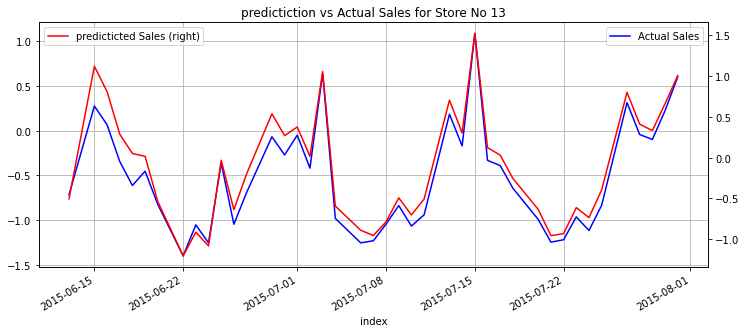

In [210]:
# Plot shows the actual sales and predicticted sales for Store No 13.

plt.figure(figsize = (12,5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 13")
plt.show()

In [211]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.416008
Mean Squared Error(MSE) : 0.192527
Root Mean Square Error(RMSE) : 0.438779
Mean Absolute Percentage Error(MAPE) : -70.460000
Mean Absolute Error(MAE): 0.416008


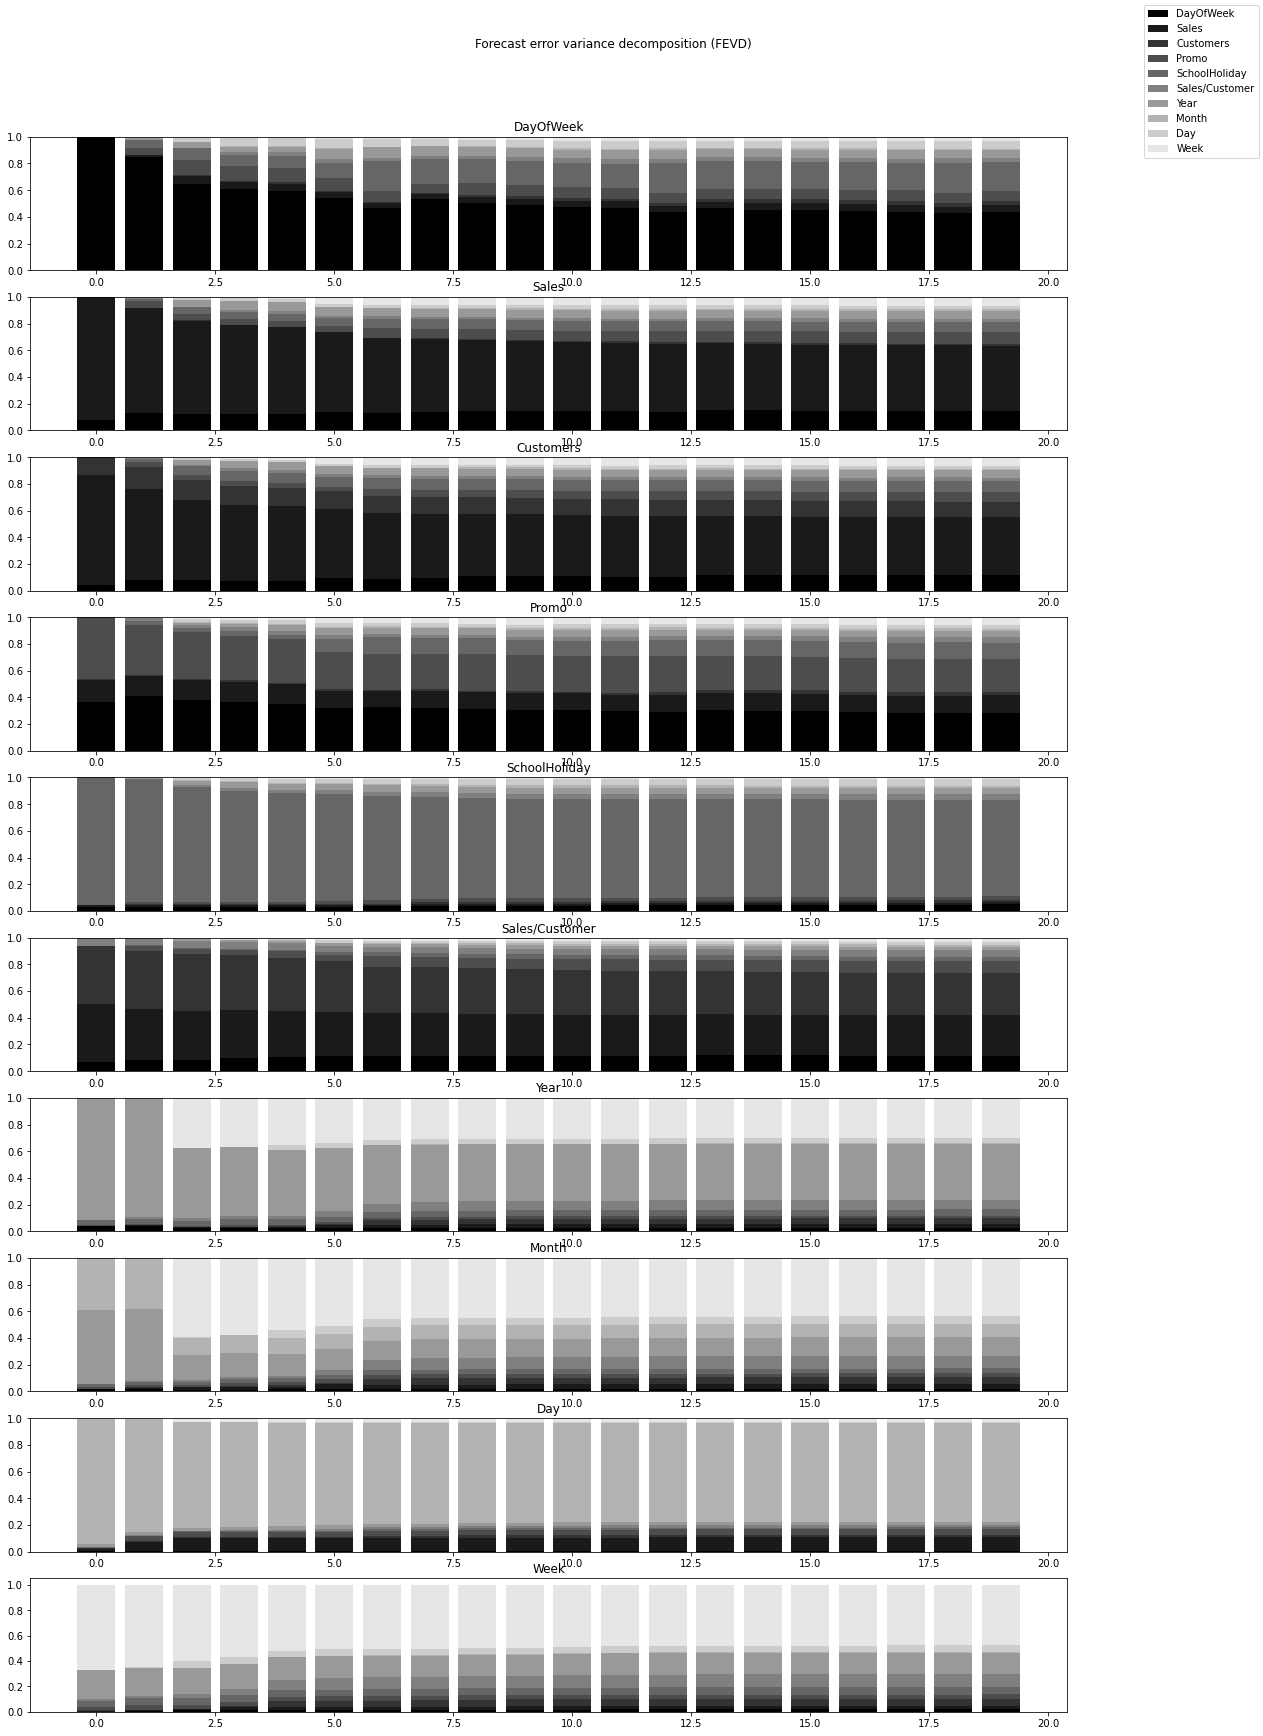

In [212]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [213]:
# Use the adfuller_test function on data.

for name, column in Store13.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3336
 No. Lags Chosen      = 15
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -6.301
 No. Lags Chosen      = 12
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 

In [214]:
# look for the columns which have same value in all its rows.

Store13.nunique()

DayOfWeek           6
Sales             587
Customers         275
Promo               2
SchoolHoliday       2
Sales/Customer    621
Year                3
Month              12
Day                31
Week               52
dtype: int64

In [215]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store13 = Store13[["Sales", "Customers", "Promo", "SchoolHoliday"]]

In [216]:
# examine data.

Store13.head()

Sales  Customers  Promo  SchoolHoliday
index                                                
2013-01-02 -1.036968  -1.111089      0              1
2013-01-03 -1.057267  -1.173408      0              1
2013-01-04 -1.001201  -1.053756      0              1
2013-01-05 -0.860392  -1.043785      0              0
2013-01-07  0.415916  -0.482916      1              0

In [217]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store13[0:-nobs], Store13[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(579, 4)
(42, 4)


In [218]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

Sales  Customers  Promo  SchoolHoliday
index                                                
2013-01-03 -0.020300  -0.062319    0.0            0.0
2013-01-04  0.056066   0.119652    0.0            0.0
2013-01-05  0.140810   0.009971    0.0           -1.0
2013-01-07  1.276308   0.560869    1.0            0.0
2013-01-08 -0.498150  -0.249275    0.0            0.0

In [219]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name=column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -9.2941
 No. Lags Chosen      = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.9496
 No. Lags Chosen      = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test 


1. Now all features are stationary. lets build the model.

In [220]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -11.959880851134713
BIC :  -11.808829126125767
FPE :  6.395735512595938e-06
HQIC:  -11.90097693061368 

Lag Order = 2
AIC :  -12.157222469064065
BIC :  -11.884965740270571
FPE :  5.250368491075112e-06
HQIC:  -12.051045445693253 

Lag Order = 3
AIC :  -12.3724499192058
BIC :  -11.978663411168474
FPE :  4.233764142488614e-06
HQIC:  -12.21886583529759 

Lag Order = 4
AIC :  -12.665957444624958
BIC :  -12.150314937743895
FPE :  3.157000681183784e-06
HQIC:  -12.464831734644557 

Lag Order = 5
AIC :  -12.917902812261824
BIC :  -12.280076633895266
FPE :  2.454048527049891e-06
HQIC:  -12.669100299052412 

Lag Order = 6
AIC :  -12.974203472540756
BIC :  -12.2138644880338
FPE :  2.3199136836333996e-06
HQIC:  -12.677588363518906 

Lag Order = 7
AIC :  -13.24095155208008
BIC :  -12.357769155722641
FPE :  1.776968624270046e-06
HQIC:  -12.89638743540117 

Lag Order = 8
AIC :  -13.270395920638382
BIC :  -12.26403802655176
FPE :  1.7257006664498288e-06
HQIC:  -12.877745761331719 


In [221]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [222]:
# Fit the lowest metrics' lag which is 15
res = mod.fit(15)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -11.5745
Nobs:                     563.000    HQIC:                  -12.7194
Log likelihood:           835.433    FPE:                1.44255e-06
AIC:                     -13.4525    Det(Omega_mle):     9.55929e-07
--------------------------------------------------------------------
Results for equation Sales
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000357         0.014934            0.024           0.981
L1.Sales                 -0.698281         0.144313           -4.839           0.000
L1.Customers              0.374059         0

In [223]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store13.index[-42:], columns = Store13.columns)
predict_data

Sales  Customers     Promo  SchoolHoliday
index                                                   
2015-06-13  0.480290   0.173909  0.156430      -0.018368
2015-06-15  0.313898   0.102788  0.255690       0.016378
2015-06-16  0.188635   0.088475  0.473608       0.264847
2015-06-17 -0.273869  -0.091306 -0.100297      -0.040561
2015-06-18 -0.113361  -0.031327 -0.083980       0.131750
2015-06-19 -0.037608   0.001017 -0.232486      -0.009211
2015-06-20 -0.194831  -0.084150 -0.274494      -0.098133
2015-06-22 -0.051137  -0.026337 -0.031312       0.166618
2015-06-23 -0.187488  -0.088875 -0.004755       0.023164
2015-06-24  0.105548   0.015800  0.050737       0.045642
2015-06-25  0.098183   0.079899 -0.008476      -0.172489
2015-06-26  0.012419   0.011730 -0.085319      -0.062808
2015-06-27  0.219056   0.067249  0.079751       0.014261
2015-06-29  0.078400   0.028338  0.228916       0.028669
2015-06-30  0.036186  -0.007051  0.181415       0.046741
2015-07-01 -0.127843  -0.035745 -0.100291      -0.075068
2015-07-02  0.013024   0.021064 -0.032910      -0.046322
2015-07-03 -0.012257  -0.005730 -0.098862      -0.069207
2015-07-04 -0.027852  -0.017565 -0.028426       0.060986
2015-07-06 -0.127731  -0.062081 -0.001194       0.089282
2015-07-07 -0.113360  -0.052600 -0.034454       0.007981
2015-07-08  0.020888   0.014386 -0.022660       0.007854
2015-07-09  0.036580   0.032686 -0.076088      -0.072915
2015-07-10  0.063537   0.026030 -0.061640       0.004602
2015-07-11  0.069683   0.023110  0.092071       0.043781
2015-07-13  0.035564   0.004450  0.144453       0.043112
2015-07-14  0.037820   0.011956  0.082329       0.005489
2015-07-15 -0.042309  -0.006361 -0.056161      -0.048796
2015-07-16  0.048149   0.023936 -0.017965      -0.030108
2015-07-17  0.025314   0.008551 -0.007881      -0.011025
2015-07-18 -0.022036  -0.014358  0.023652       0.049417
2015-07-20 -0.114281  -0.053450 -0.033704       0.021272
2015-07-21 -0.063982  -0.026043 -0.034458      -0.010623
2015-07-22 -0.002536   0.005489 -0.055206      -0.029131
2015-07-23  0.022842   0.014666 -0.067359      -0.033312
2015-07-24  0.016949   0.004315 -0.014283       0.024763
2015-07-25  0.020392   0.002260  0.073778       0.026616
2015-07-27  0.032870   0.007965  0.087325       0.017346
2015-07-28  0.031538   0.016277  0.036082      -0.015196
2015-07-29  0.000410   0.006389 -0.036136      -0.034501
2015-07-30  0.047045   0.021309  0.010981      -0.005474
2015-07-31  0.011281   0.002286  0.023167       0.016239

In [224]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

               Sales  Customers     Promo  SchoolHoliday
index                                                   
2015-06-13 -0.237359  -0.882340  0.156430      -0.018368
2015-06-15  1.068972  -0.363263  1.412120      -0.001990
2015-06-16  1.048488  -0.491657  1.885728       0.262857
2015-06-17  0.364112  -0.622847  1.785431       0.222296
2015-06-18 -0.019268  -0.828667  1.701452       0.354046
2015-06-19  0.103911  -0.655650  1.468965       0.344835
2015-06-20 -0.463082  -0.869423  0.194471       0.246702
2015-06-22 -1.090346  -1.219818  0.163159       0.413320
2015-06-23 -0.930482  -1.144171  0.158404       0.436484
2015-06-24 -1.026321  -1.245531  0.209141       0.482126
2015-06-25 -0.034304  -1.078385  0.200665       0.309637
2015-06-26 -0.707566  -1.029264  0.115346       0.246830
2015-06-27 -0.134391  -0.822421  0.195097       0.261091
2015-06-29  0.569113  -0.554778  1.424013       0.289760
2015-06-30  0.401978  -0.654061  1.605428       0.336500
2015-07-01  0.495177  -0.777053

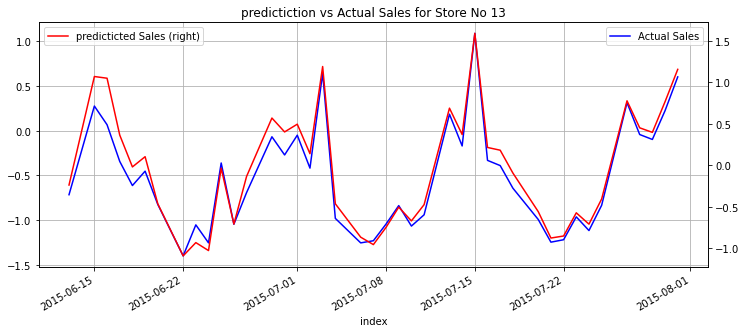

In [225]:
# Plot shows the actual sales and predicticted sales for Store No 13.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 13")
plt.show()

In [226]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.481531
Mean Squared Error(MSE) : 0.254836
Root Mean Square Error(RMSE) : 0.504813
Mean Absolute Percentage Error(MAPE) : -79.160000
Mean Absolute Error(MAE): 0.481531


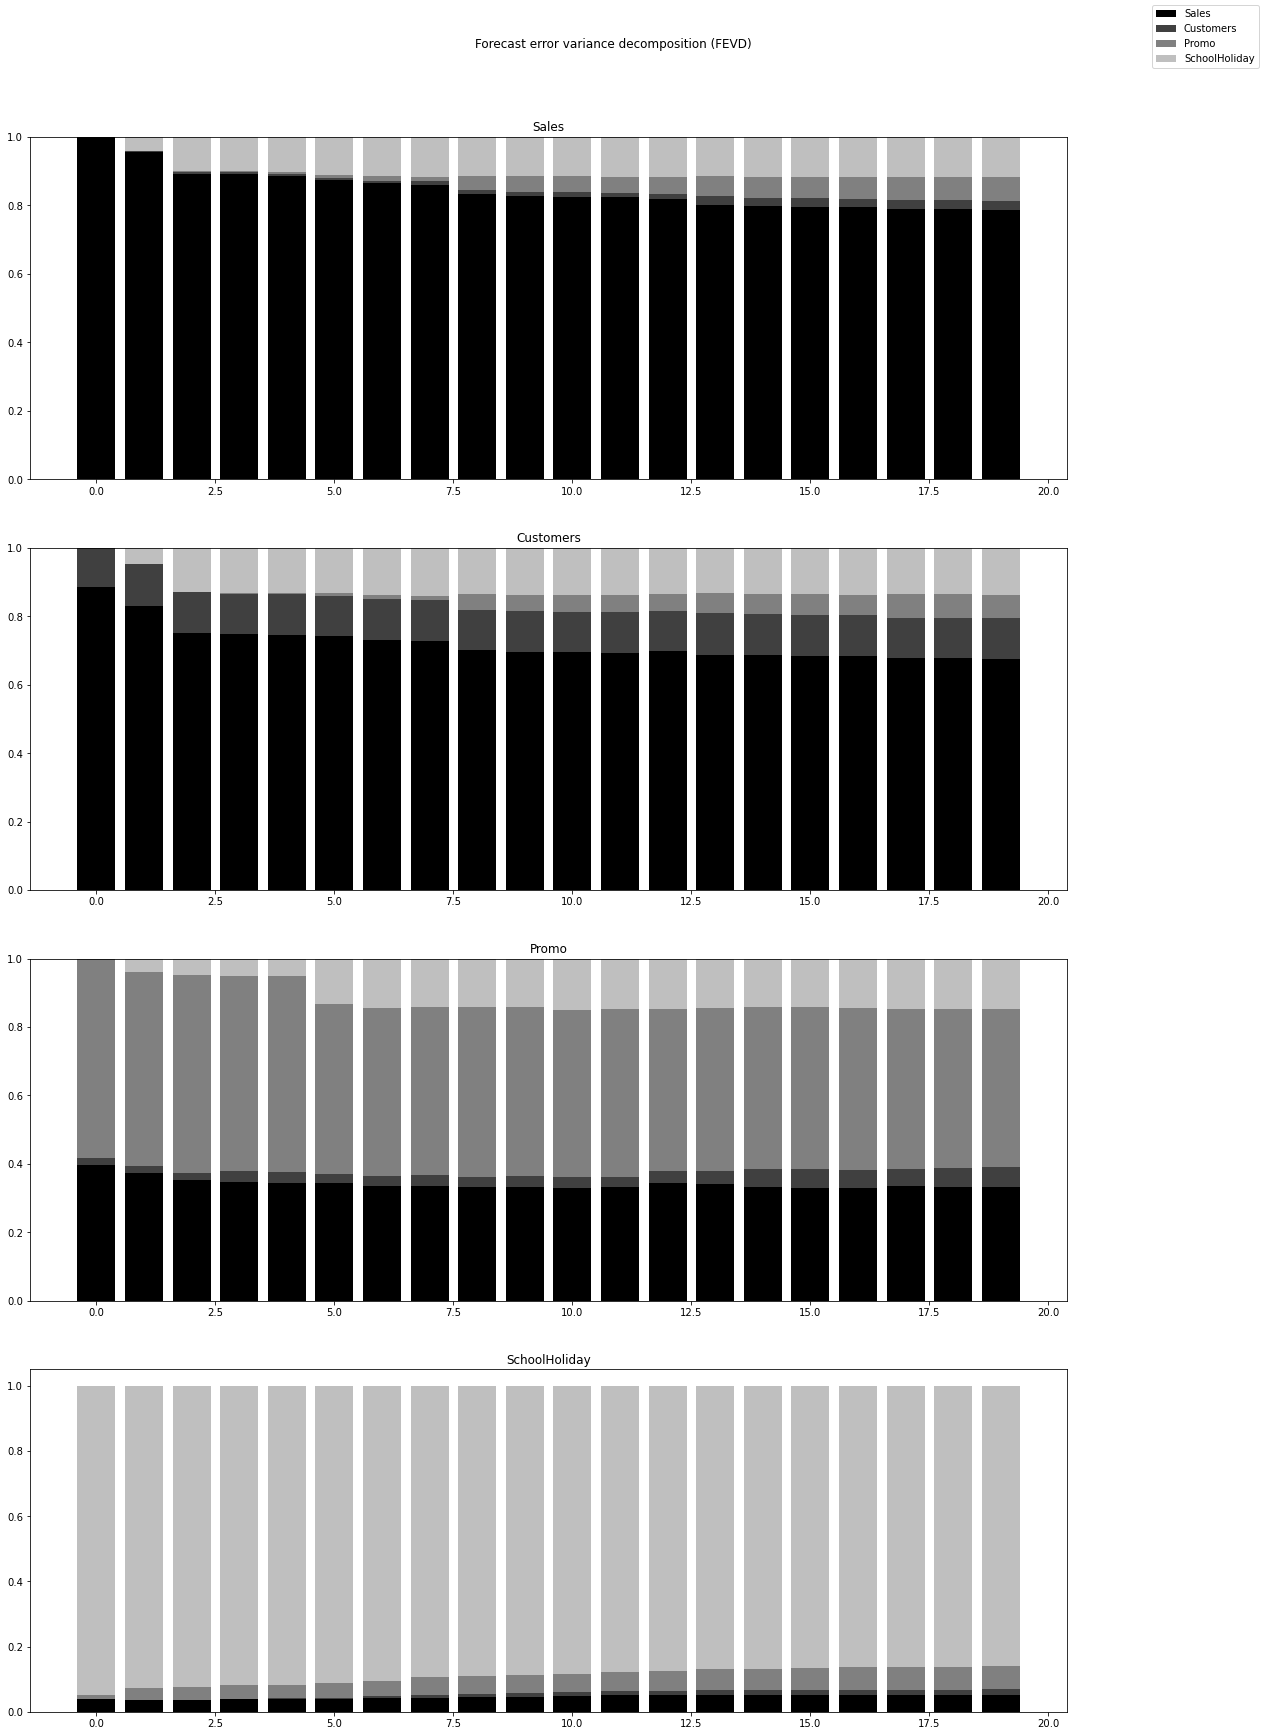

In [227]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.6. Model for Store No. 25.

### Model 1.

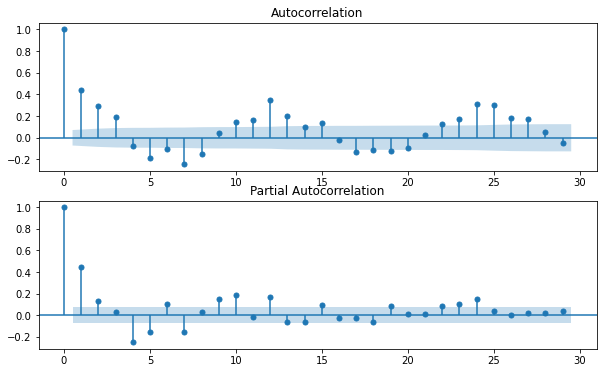

In [228]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store25.Sales, ax = ax[0])
ax[1] = plot_pacf(Store25.Sales, ax = ax[1])

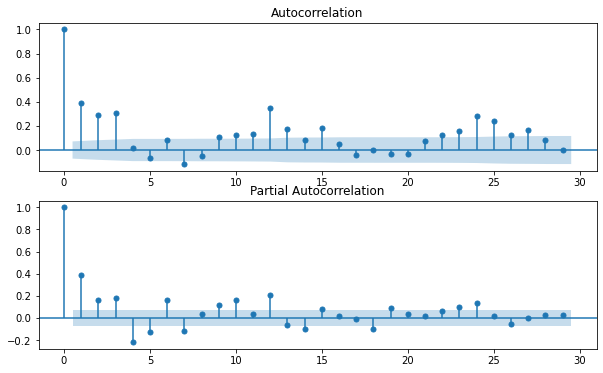

In [229]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store25.Customers, ax = ax[0])
ax[1] = plot_pacf(Store25.Customers, ax = ax[1])

In [230]:
# Use the adfuller_test function on data.

for name, column in Store25.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.0229
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [231]:
# look for the columns which have same value in all its rows.

Store25.nunique()

Store                          1
DayOfWeek                      6
Sales                        714
Customers                    518
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               749
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    125
dtype: int64

In [232]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store25 = Store25[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday",]]

In [233]:
# examine data.

Store25.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday
index                                                           
2013-01-02          3  1.607481   2.331397      0              1
2013-01-03          4  1.112875   2.054702      0              1
2013-01-04          5  0.893767   1.887688      0              1
2013-01-05          6  0.654680   1.541196      0              0
2013-01-07          1  2.435261   3.126584      1              0

In [234]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store25[0:-nobs], Store25[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(710, 5)
(42, 5)


In [235]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday
index                                                           
2013-01-03        1.0 -0.494606  -0.276695    0.0            0.0
2013-01-04        1.0 -0.219109  -0.167014    0.0            0.0
2013-01-05        1.0 -0.239086  -0.346492    0.0           -1.0
2013-01-07       -5.0  1.780581   1.585388    1.0            0.0
2013-01-08        1.0 -0.086999  -0.219362    0.0            0.0

In [236]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -12.53
 No. Lags Chosen      = 17
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.0391
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 T


1. Now all features are stationary. lets build the model.

In [237]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -8.40418
Nobs:                     694.000    HQIC:                  -9.92957
Log likelihood:          -764.397    FPE:                1.86997e-05
AIC:                     -10.8914    Det(Omega_mle):     1.11219e-05
--------------------------------------------------------------------
Results for equation DayOfWeek
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.001486         0.030279            0.049           0.961
L1.DayOfWeek             -0.842163         0.053700          -15.683           0.000
L1.Sales                 -0.163016      

In [238]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store25.index[-42:], columns = Store25.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday
index                                                              
2015-06-13   1.030207  0.363618   0.153493 -0.057417      -0.026613
2015-06-15  -4.393377  1.030767   0.795570  0.751766       0.108218
2015-06-16   0.369857 -0.130445   0.036798  0.068982      -0.271679
2015-06-17   0.538766  0.415487   0.356066  0.038849       0.148913
2015-06-18   1.538383 -0.410226  -0.330481  0.045184       0.037963
2015-06-19   1.711761 -0.569444  -0.475888 -0.325723      -0.134241
2015-06-20  -1.377761 -0.178621  -0.087865 -0.438875       0.065038
2015-06-22  -2.774700  0.047014   0.108371  0.067580       0.163720
2015-06-23   0.338823 -0.172388  -0.215127  0.033654      -0.019306
2015-06-24   1.171330 -0.070013  -0.078537  0.024588      -0.012501
2015-06-25   1.454172  0.116009   0.087915 -0.058116      -0.109439
2015-06-26   0.727369 -0.114887  -0.111407 -0.203848      -0.051858
2015-06-27  -1.547620  0.295137   0.191821  0.171408       0.059490
2015-06-29  -2.039862  0.657358   0.550707  0.382356       0.096516
2015-06-30   0.756942 -0.328694  -0.219722  0.056607      -0.049681
2015-07-01   0.998704 -0.038019  -0.026537  0.035044       0.008356
2015-07-02   1.121929 -0.022745  -0.109201  0.013730      -0.002182
2015-07-03   0.200216 -0.182800  -0.175417 -0.166169      -0.100707
2015-07-04  -1.428454  0.074675   0.190634 -0.187056       0.008633
2015-07-06  -1.481172 -0.002996   0.062151  0.099699       0.118513
2015-07-07   0.869405 -0.230408  -0.241393 -0.007943      -0.008387
2015-07-08   1.091229 -0.020925  -0.040047 -0.061167      -0.020089
2015-07-09   0.756915 -0.020791  -0.035503 -0.142956      -0.027693
2015-07-10  -0.224741 -0.023898  -0.031592 -0.097965      -0.040582
2015-07-11  -1.444255  0.201424   0.154672  0.170117       0.003329
2015-07-13  -0.825160  0.308153   0.263223  0.217113       0.080734
2015-07-14   0.997067 -0.097420  -0.044485  0.019925      -0.037370
2015-07-15   0.953198 -0.146506  -0.136163 -0.006856      -0.012404
2015-07-16   0.310895  0.073184   0.004931  0.006240       0.010468
2015-07-17  -0.402433 -0.072866  -0.072755 -0.085585      -0.040523
2015-07-18  -1.116329  0.031046   0.098824 -0.026522       0.009189
2015-07-20  -0.438140  0.029065   0.064736  0.076288       0.074166
2015-07-21   0.968425 -0.177140  -0.193647 -0.022201      -0.013106
2015-07-22   0.803455 -0.040622  -0.053397 -0.096506      -0.039400
2015-07-23   0.062236  0.010337   0.016398 -0.109335      -0.003031
2015-07-24  -0.620207  0.006176   0.010232 -0.017390      -0.009926
2015-07-25  -0.879077  0.113643   0.096953  0.119501       0.005508
2015-07-27  -0.088224  0.132285   0.107711  0.113419       0.051047
2015-07-28   0.963026 -0.084093  -0.070828 -0.026731      -0.029084
2015-07-29   0.533518 -0.066880  -0.070764 -0.024912      -0.025908
2015-07-30  -0.201491  0.073944   0.038429  0.011349       0.007860
2015-07-31  -0.554061  0.012342   0.017085 -0.020501      -0.010117

In [239]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday
index                                                              
2015-06-13   7.030207  0.775990   1.265936 -0.057417      -0.026613
2015-06-15  -2.363170  3.870246   3.624460  1.694349       0.081604
2015-06-16  -0.993313  2.979043   3.272389  1.763331      -0.190075
2015-06-17   0.545452  3.312042   3.159818  1.802180      -0.041162
2015-06-18   3.083835  2.647586   2.819366  1.847364      -0.003198
2015-06-19   5.795596  1.899633   2.298609  1.521641      -0.137439
2015-06-20   5.417835  0.879377   1.457935  0.082766      -0.072401
2015-06-22  -2.356864  1.862436   2.398883  0.150346       0.091319
2015-06-23  -1.018041  1.308541   2.026713  0.184000       0.072013
2015-06-24   1.153289  1.029086   1.733800  0.208588       0.059512
2015-06-25   3.607461  1.138006   1.831686  0.150472      -0.049927
2015-06-26   5.334830  1.124295   1.702830 -0.053376      -0.101785
2015-06-27   4.787210  1.307300   1.590536  0.11

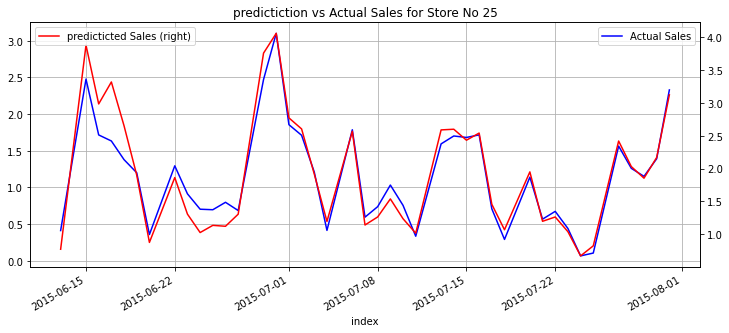

In [240]:
# Plot shows the actual sales and predicticted sales for Store No 25.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 25")
plt.show()

In [241]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.756192
Mean Squared Error(MSE) : 0.653419
Root Mean Square Error(RMSE) : 0.808343
Mean Absolute Percentage Error(MAPE) : 112.640000
Mean Absolute Error(MAE): 0.756192


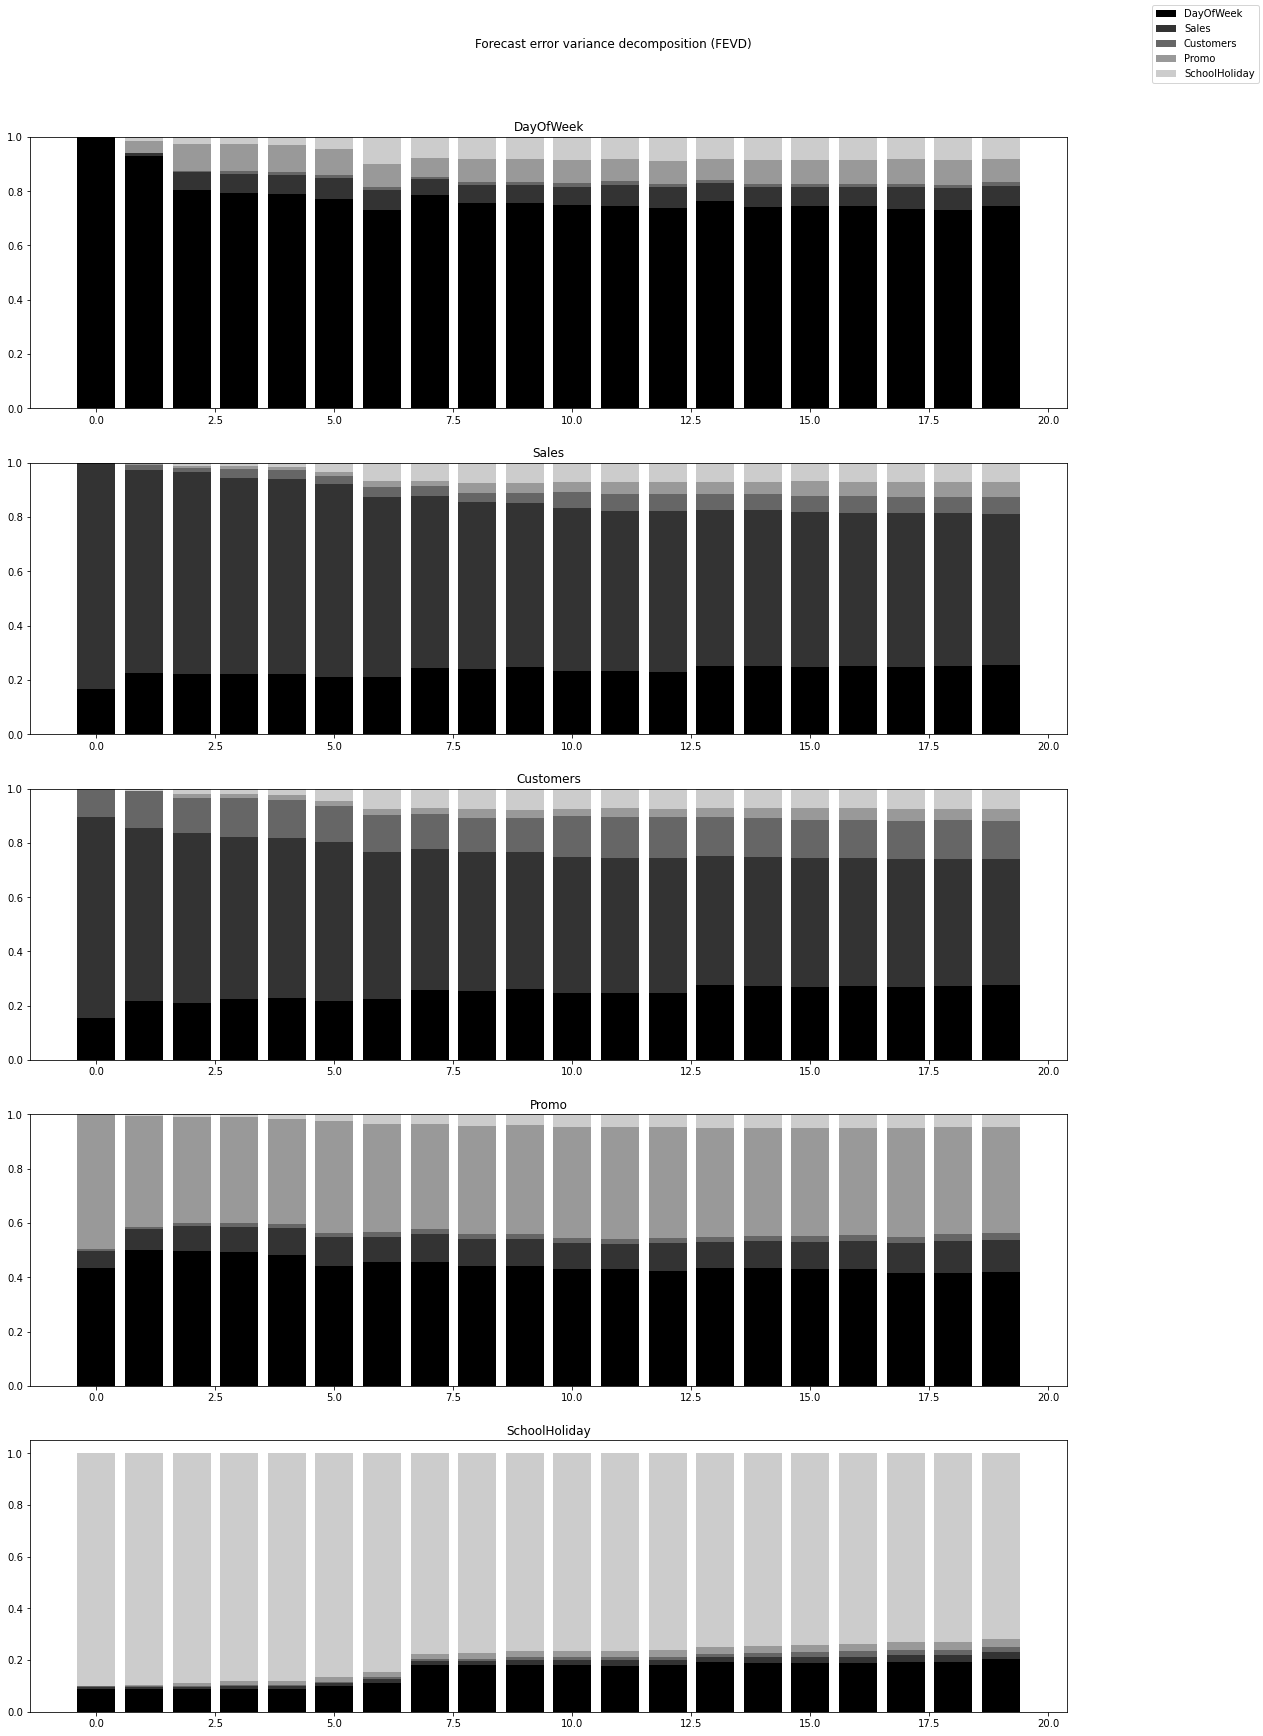

In [242]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [243]:
Store25 = Merge[Merge.Store == 25]

In [244]:
# Use the adfuller_test function on data.

for name, column in Store25.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.0229
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le

In [245]:
# look for the columns which have same value in all its rows.

Store25.nunique()

Store                          1
DayOfWeek                      6
Sales                        714
Customers                    518
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               749
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    125
dtype: int64

In [246]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store25 = Store25[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Week"]]

In [247]:
# examine data.

Store25.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3  1.607481   2.331397      0              1   
2013-01-03          4  1.112875   2.054702      0              1   
2013-01-04          5  0.893767   1.887688      0              1   
2013-01-05          6  0.654680   1.541196      0              0   
2013-01-07          1  2.435261   3.126584      1              0   

            Sales/Customer  Week  
index                             
2013-01-02        7.034158     1  
2013-01-03        6.558916     1  
2013-01-04        6.400658     1  
2013-01-05        6.507603     1  
2013-01-07        7.195340     2

In [248]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store25[0:-nobs], Store25[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(710, 7)
(42, 7)



1. Now all features are stationary. lets build the model.

In [249]:
# Building the VAR model.

mod = VAR(X_train)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.820314711366816
BIC :  -8.459840932120272
FPE :  0.0001477028597411029
HQIC:  -8.681052716645622 

Lag Order = 2
AIC :  -9.858478023385882
BIC :  -9.18184436542283
FPE :  5.230421318563033e-05
HQIC:  -9.597056762293644 

Lag Order = 3
AIC :  -10.545702681741325
BIC :  -9.55221085352623
FPE :  2.6309986135668748e-05
HQIC:  -10.161836355107447 

Lag Order = 4
AIC :  -11.126196292051892
BIC :  -9.815145451809503
FPE :  1.4726344438394782e-05
HQIC:  -10.619598032765252 

Lag Order = 5
AIC :  -11.682907725158605
BIC :  -10.053594467983157
FPE :  8.442050015613719e-06
HQIC:  -11.053289592710865 

Lag Order = 6
AIC :  -12.069728503857156
BIC :  -10.121446848738449
FPE :  5.736491776471199e-06
HQIC:  -11.316801478850726 

Lag Order = 7
AIC :  -12.256579300888218
BIC :  -9.98862067765389
FPE :  4.761750591998985e-06
HQIC:  -11.38005327950859 

Lag Order = 8
AIC :  -12.385233005532548
BIC :  -9.796886241705911
FPE :  4.190355771010966e-06
HQIC:  -11.384816793984749 

Lag 

In [250]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [251]:
# Fit the lowest metrics' lag which is 15

res = mod.fit(15)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:08
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -7.96693
Nobs:                     695.000    HQIC:                  -10.9422
Log likelihood:          -1706.84    FPE:                2.75709e-06
AIC:                     -12.8181    Det(Omega_mle):     1.02075e-06
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     11.875640         2.239388            5.303           0.000
L1.DayOfWeek               0.006771         0.059453            0.114           0.909
L1.Sales                  -0.105580 

In [252]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(X_train.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store25.index[-42:], columns = Store25.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.390585  0.902471   1.571994  0.018723       0.119208   
2015-06-15   1.336104  2.036921   2.430849  0.906783       0.276407   
2015-06-16   2.583446  1.824997   2.356463  0.900876       0.068219   
2015-06-17   3.239600  2.064652   2.582644  0.898773       0.186349   
2015-06-18   4.147431  2.120097   2.662663  1.026801       0.246005   
2015-06-19   5.042660  1.565920   2.155811  0.836030       0.224776   
2015-06-20   4.528059  1.110864   1.831088  0.255674       0.309838   
2015-06-22   1.926605  1.202949   2.049428  0.269296       0.465124   
2015-06-23   2.615326  0.942162   1.786920  0.277515       0.392502   
2015-06-24   3.278999  0.928695   1.656097  0.234779       0.418703   
2015-06-25   4.188545  0.953107   1.681146  0.090820       0.384208   
2015-06-26   4.761741  0.845933   1.588092  0.012400       0.283248   
2015-06-27   3.906111  1.013531   1.676739  0.182157       0.292771   
2015-06-29   1.869970  1.692659   2.220598  0.623478       0.373238   
2015-06-30   2.772680  1.452206   2.018042  0.635374       0.324579   
2015-07-01   3.596473  1.411358   1.983251  0.712108       0.316912   
2015-07-02   4.179976  1.433317   1.975172  0.845340       0.297194   
2015-07-03   4.569010  1.263907   1.812603  0.684827       0.206352   
2015-07-04   3.693086  1.063133   1.719936  0.398688       0.211716   
2015-07-06   2.101364  1.355929   2.066971  0.492997       0.312125   
2015-07-07   3.081323  1.035984   1.783729  0.430722       0.280726   
2015-07-08   3.808218  0.898810   1.640577  0.302224       0.280649   
2015-07-09   4.247924  0.990170   1.728019  0.193131       0.248830   
2015-07-10   4.234160  0.988606   1.699906  0.168209       0.188183   
2015-07-11   3.223575  1.193240   1.847571  0.326919       0.202402   
2015-07-13   2.240746  1.635275   2.241143  0.592291       0.277300   
2015-07-14   3.294480  1.497384   2.134925  0.593487       0.246161   
2015-07-15   3.917425  1.406157   2.059297  0.633572       0.232887   
2015-07-16   4.099628  1.493072   2.112020  0.658152       0.226349   
2015-07-17   4.002567  1.365346   2.003451  0.511993       0.192806   
2015-07-18   3.127267  1.234182   1.940858  0.405290       0.212198   
2015-07-20   2.520836  1.263491   2.007324  0.481732       0.273899   
2015-07-21   3.460762  1.078739   1.828818  0.420361       0.254850   
2015-07-22   4.064309  0.944503   1.697179  0.319678       0.236015   
2015-07-23   4.100307  1.028334   1.764001  0.273822       0.217749   
2015-07-24   3.754135  1.077101   1.783608  0.294230       0.189527   
2015-07-25   2.966098  1.227786   1.902537  0.425120       0.206987   
2015-07-27   2.739902  1.411157   2.065586  0.561878       0.251332   
2015-07-28   3.592284  1.364780   2.022725  0.555451       0.232511   
2015-07-29   4.020931  1.318291   1.968685  0.560651       0.214140   
2015-07-30   3.967040  1.377080   2.007775  0.543372       0.210424   
2015-07-31   3.578654  1.341938   1.991172  0.467410       0.204623   

            Sales/Customer       Week  
index                                  
2015-06-13        6.926581  23.821005  
2015-06-15        7.468604  25.420635  
2015-06-16        7.311537  24.506535  
2015-06-17        7.607226  24.284656  
2015-06-18        7.656362  23.303030  
2015-06-19        7.478544  22.818851  
2015-06-20        7.155759  23.522641  
2015-06-22        6.986720  23.426738  
2015-06-23        6.809774  23.292413  
2015-06-24        6.962867  23.176885  
2015-06-25        7.023298  22.510052  
2015-06-26        6.963240  20.987472  
2015-06-27        7.066134  20.830382  
2015-06-29        7.391517  21.065031  
2015-06-30        7.340590  21.037981  
2015-07-01        7.257071  21.232054  
2015-07-02        7.267493  21.500935  
2015-07-03        7.162916  21.786878  
2015-07-04        6.935196  22.185271  
2015-07-06        6.973979  22.519169  
2015-07

In [253]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

             DayOfWeek      Sales  Customers      Promo  SchoolHoliday  \
index                                                                    
2015-06-13   11.390585   1.314843   2.684437   0.018723       0.119208   
2015-06-15    7.726689   5.415253   6.678240   1.925507       0.395615   
2015-06-16   11.310135   6.479491   8.645833   2.826383       0.463833   
2015-06-17   15.549734   8.461655  10.759840   3.725157       0.650183   
2015-06-18   20.697165  10.327522  13.412532   4.751958       0.896187   
2015-06-19   26.739825  11.714932  15.523474   5.587988       1.120963   
2015-06-20   32.267885  11.984162  16.601751   4.843662       1.430801   
2015-06-22   29.194490  14.123155  19.483758   5.112958       1.895925   
2015-06-23   32.809816  14.683810  21.113634   5.390472       2.288427   
2015-06-24   37.088815  15.403063  22.555354   5.625251       2.707130   
2015-06-25   42.277360  16.349082  24.246471   5.716071       3.091338   
2015-06-26   48.039101  17.296192  25.

In [254]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -28.659446
Mean Squared Error(MSE) : 1050.310469
Root Mean Square Error(RMSE) : 32.408494
Mean Absolute Percentage Error(MAPE) : 5805.570000
Mean Absolute Error(MAE): 28.659446


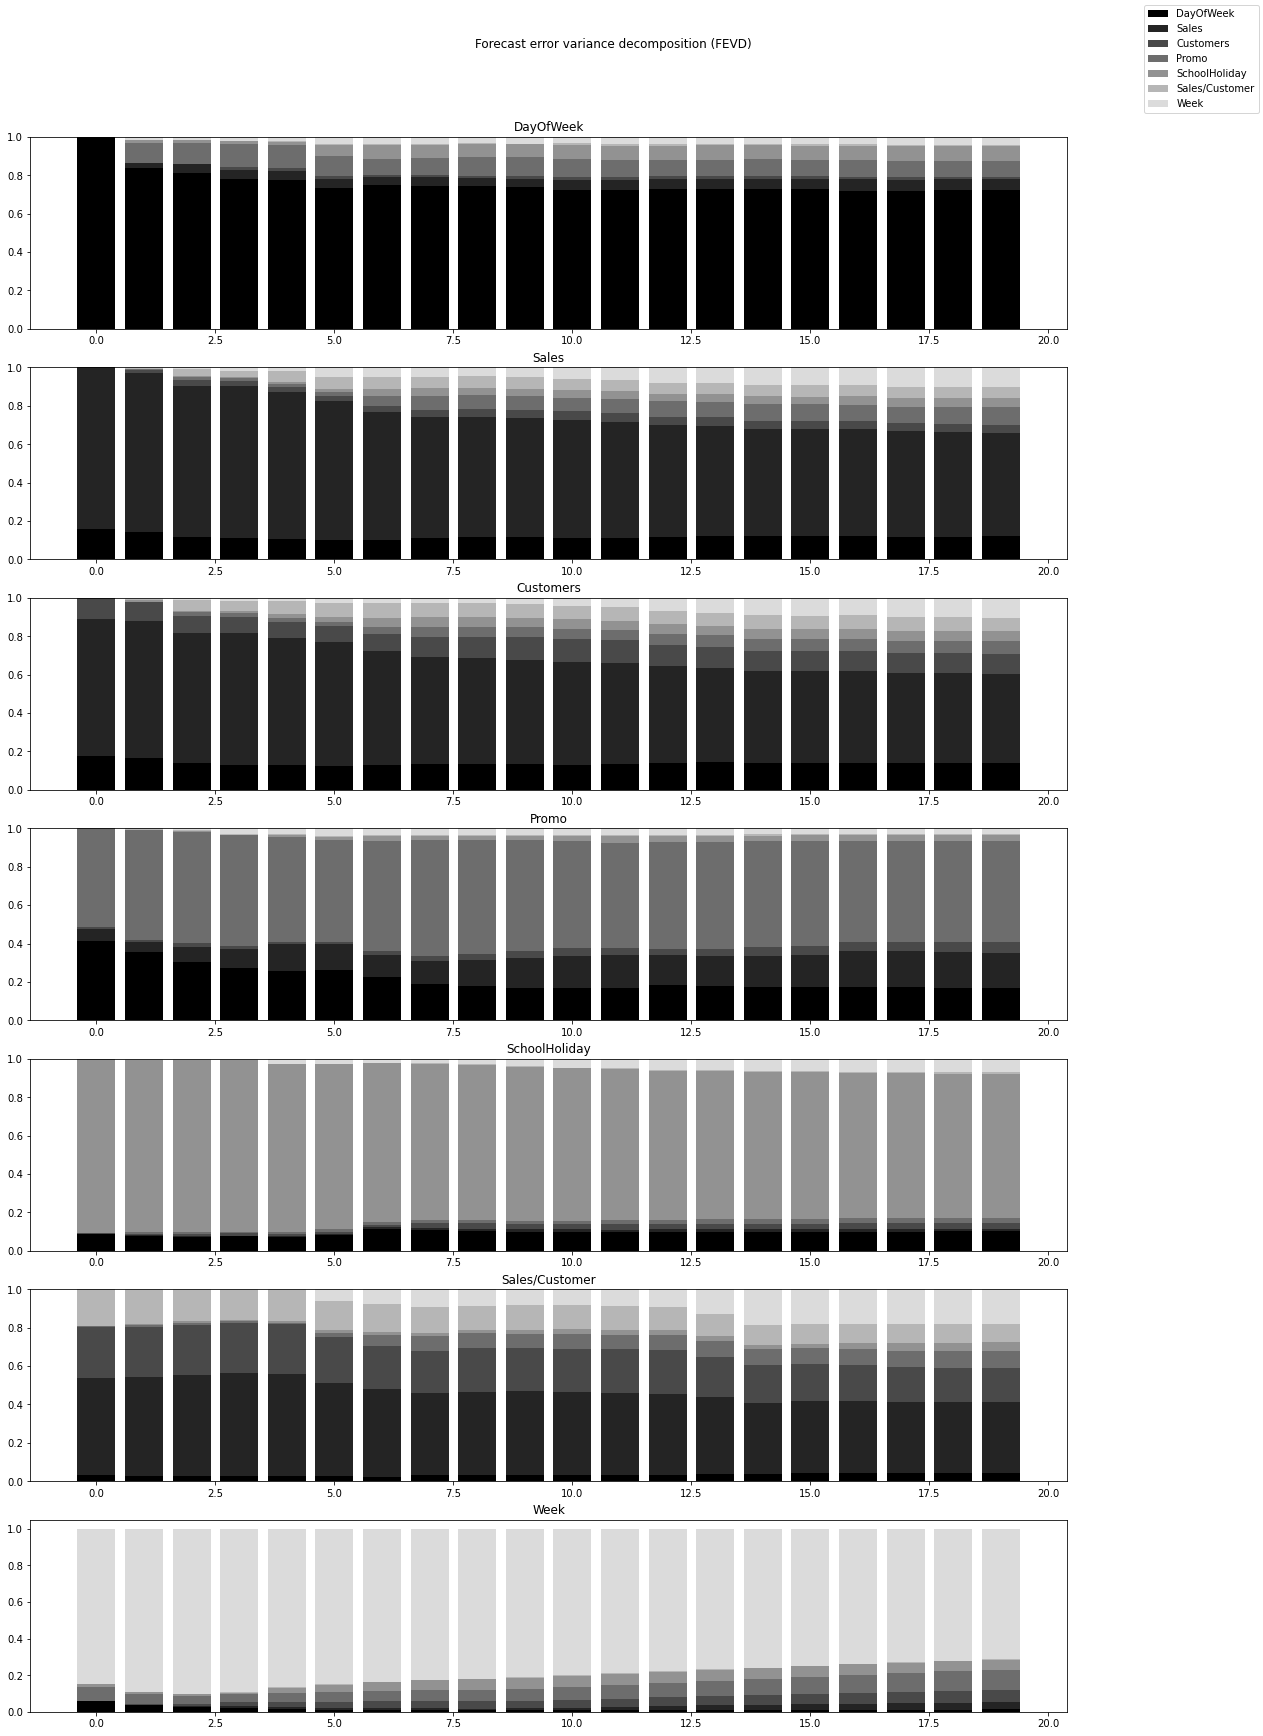

In [255]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.7. Model for Store No. 29.

### Model 1.

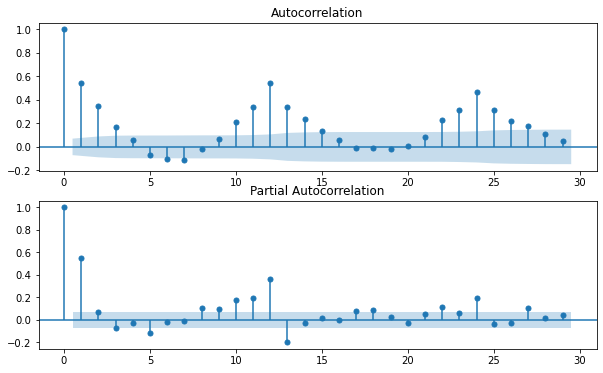

In [256]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store29.Sales, ax = ax[0])
ax[1] = plot_pacf(Store29.Sales, ax = ax[1])

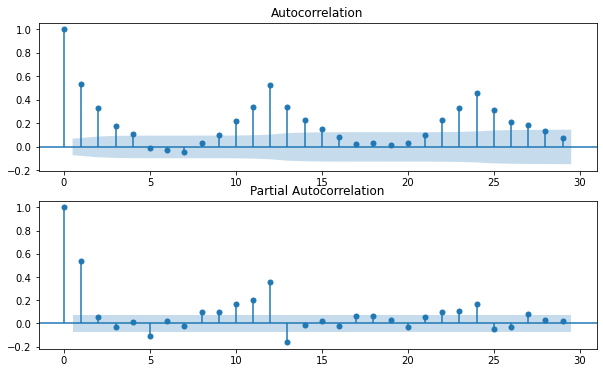

In [257]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store29.Customers, ax = ax[0])
ax[1] = plot_pacf(Store29.Customers, ax = ax[1])

In [258]:
# Use the adfuller_test function on data.

for name, column in Store29.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [259]:
# look for the columns which have same value in all its rows.

Store29.nunique()

Store                          1
DayOfWeek                      6
Sales                        733
Customers                    388
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               777
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [260]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store29 = Store29[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", "Day",
                        "Week"]]

In [261]:
# examine data.

Store29.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.543329  -0.530279      0              1   
2013-01-03          4 -0.773715  -0.764597      0              1   
2013-01-04          5 -0.497574  -0.642452      0              1   
2013-01-05          6 -0.448274  -0.562684      0              0   
2013-01-07          1  1.237574   0.249952      1              0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-02        9.580000  2013      1    2     1  
2013-01-03        9.986842  2013      1    3     1  
2013-01-04       10.714851  2013      1    4     1  
2013-01-05       10.361266  2013      1    5     1  
2013-01-07       12.509849  2013      1    7     2

In [262]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store29[0:-nobs], Store29[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 10)
(42, 10)


In [263]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0 -0.230386  -0.234318    0.0            0.0   
2013-01-04        1.0  0.276141   0.122145    0.0            0.0   
2013-01-05        1.0  0.049299   0.079768    0.0           -1.0   
2013-01-07       -5.0  1.685848   0.812636    1.0            0.0   
2013-01-08        1.0 -1.147421  -0.580811    0.0            0.0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-03        0.406842   0.0    0.0  1.0   0.0  
2013-01-04        0.728009   0.0    0.0  1.0   0.0  
2013-01-05       -0.353585   0.0    0.0  1.0   0.0  
2013-01-07        2.148583   0.0    0.0  2.0   1.0  
2013-01-08       -1.025722   0.0    0.0  1.0   0.0

In [264]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1558
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.6766
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [265]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:13
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -22.1639
Nobs:                     725.000    HQIC:                  -26.4757
Log likelihood:           1402.44    FPE:                2.16488e-13
AIC:                     -29.1855    Det(Omega_mle):     5.20897e-14
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.494561         0.408530            1.211           0.226
L1.DayOfWeek              -0.878399         0.055346          -15.871           0.000
L1.Sales                  -0.660104 

In [266]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store29.index[-42:], columns = Store29.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13  -0.861730  0.596450   0.297999 -0.047305       0.206725   
2015-06-15  -2.554421  0.288838   0.068638  0.393485       0.096110   
2015-06-16   1.144338  0.049426   0.055648 -0.133413      -0.336595   
2015-06-17  -0.165642 -0.206126  -0.106383  0.102240       0.171277   
2015-06-18   1.479540 -0.073333  -0.028642 -0.033099      -0.143634   
2015-06-19   0.332753  0.284862   0.157621  0.037380       0.067417   
2015-06-20  -0.301993 -0.028606   0.000722 -0.084791       0.238687   
2015-06-22  -1.531315  0.111833   0.013470  0.158204      -0.153637   
2015-06-23  -0.143295 -0.156708  -0.051122  0.111932       0.010002   
2015-06-24   0.642326 -0.248262  -0.093568  0.013758       0.082649   
2015-06-25   1.211890 -0.220495  -0.116122 -0.329418      -0.142596   
2015-06-26  -0.558542  0.016791  -0.000551 -0.064736      -0.087321   
2015-06-27   0.084458 -0.024487   0.001676 -0.223241       0.154435   
2015-06-29  -1.331859  0.188537   0.074346  0.105202       0.063471   
2015-06-30   0.492657 -0.134162  -0.091476 -0.017764      -0.071415   
2015-07-01   0.356162  0.080707   0.041415  0.114781       0.022719   
2015-07-02   0.664626  0.197283   0.101528  0.093376      -0.086904   
2015-07-03  -0.439449  0.264463   0.131811  0.160402      -0.040207   
2015-07-04  -0.024842 -0.040931  -0.017564 -0.020186       0.063336   
2015-07-06  -0.797153  0.039484   0.015221  0.136617       0.009576   
2015-07-07   0.387295 -0.161696  -0.068459  0.007595      -0.033248   
2015-07-08   0.266729 -0.082711  -0.031289 -0.026704       0.046760   
2015-07-09   0.591604 -0.227888  -0.105091 -0.231825       0.001454   
2015-07-10  -0.494256  0.023877   0.012011 -0.070893      -0.048870   
2015-07-11  -0.087381 -0.057988  -0.033286 -0.110733       0.047219   
2015-07-13  -0.540132  0.073436   0.025600  0.028707       0.022043   
2015-07-14   0.369506 -0.107227  -0.052951 -0.051336      -0.013755   
2015-07-15   0.224440  0.082655   0.038117  0.054548       0.004084   
2015-07-16   0.385483  0.140812   0.065765  0.047283      -0.027807   
2015-07-17  -0.465465  0.224567   0.109148  0.138685      -0.023897   
2015-07-18  -0.018029 -0.025165  -0.011664  0.025272       0.016299   
2015-07-20  -0.448473  0.055163   0.022620  0.132638       0.014329   
2015-07-21   0.329132 -0.083938  -0.037094  0.046594      -0.005963   
2015-07-22   0.317963 -0.055459  -0.016534 -0.043912      -0.000958   
2015-07-23   0.222889 -0.135692  -0.060086 -0.152555       0.005047   
2015-07-24  -0.437020 -0.009349  -0.005512 -0.055689      -0.002624   
2015-07-25  -0.012739 -0.087568  -0.043675 -0.098682       0.012888   
2015-07-27  -0.296013  0.007504  -0.001314 -0.014359       0.017226   
2015-07-28   0.290499 -0.084847  -0.043527 -0.043665      -0.010345   
2015-07-29   0.218361  0.067925   0.032677  0.016988      -0.012446   
2015-07-30   0.113645  0.123332   0.058373  0.042331      -0.005525   
2015-07-31  -0.332972  0.150585   0.070018  0.101212      -0.012752   

            Sales/Customer      Year     Month       Day      Week  
index                                                               
2015-06-13        0.533066  0.001305 -0.147106  4.987670 -4.658438  
2015-06-15        0.730687 -0.009029  0.116574  1.400388  2.388188  
2015-06-16       -0.213932  0.063511 -0.576611 -4.572880  1.701360  
2015-06-17       -0.113086  0.015574 -0.062924 -2.452997 -1.170769  
2015-06-18       -0.102970 -0.018463  0.274739 -0.721062  0.321212  
2015-06-19        0.297626 -0.010786  0.184203 -0.401600  1.739607  
2015-06-20       -0.111957  0.016709 -0.158994  0.089747  0.671680  
2015-06-22        0.501437 -0.032411  0.422789  0.343737  0.444109  
2015-06-23       -0.347963 -0.016180  0.185694  1.467901  0.370845  
2015-06-24       -0.404580 -0.006049  0.070470  1.213481 -0.272353  
2015-06-25       -0.258262  0.002998 -0.034637  0.956256 -0

In [267]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.138270  1.064566   0.198966 -0.047305       0.206725   
2015-06-15  -2.416151  3.420437   1.105168  1.346180       0.302835   
2015-06-16  -0.271813  2.036634   0.547599  1.212766      -0.033760   
2015-06-17   0.562545  1.411624   0.239304  1.315007       0.137517   
2015-06-18   3.042085  1.445591   0.220632  1.281908      -0.006117   
2015-06-19   4.374838  1.517144   0.375761  1.319288       0.061300   
2015-06-20   5.072845  1.285863   0.391440  0.234497       0.299987   
2015-06-22  -1.458470  0.972690   0.085837  0.392701       0.146350   
2015-06-23  -0.601765  0.840793  -0.060009  0.504632       0.156352   
2015-06-24   1.040561  0.713685  -0.006505  0.518390       0.239001   
2015-06-25   3.252451  0.147772  -0.197409  0.188973       0.096405   
2015-06-26   3.693909  0.383027  -0.195467  0.124237       0.009085   
2015-0

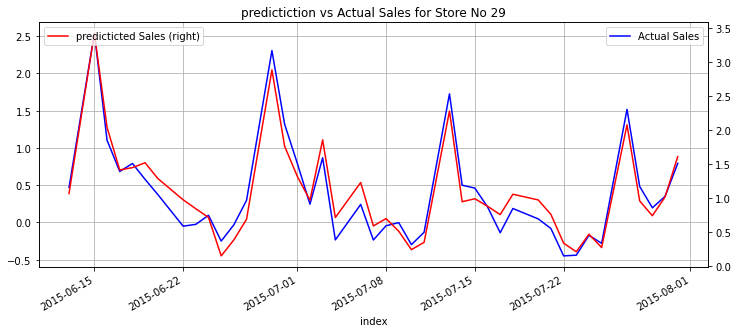

In [268]:
# Plot shows the actual sales and predicticted sales for Store No 29.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 29")

plt.show()

In [269]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.691561
Mean Squared Error(MSE) : 0.513279
Root Mean Square Error(RMSE) : 0.716435
Mean Absolute Percentage Error(MAPE) : -606.920000
Mean Absolute Error(MAE): 0.691561


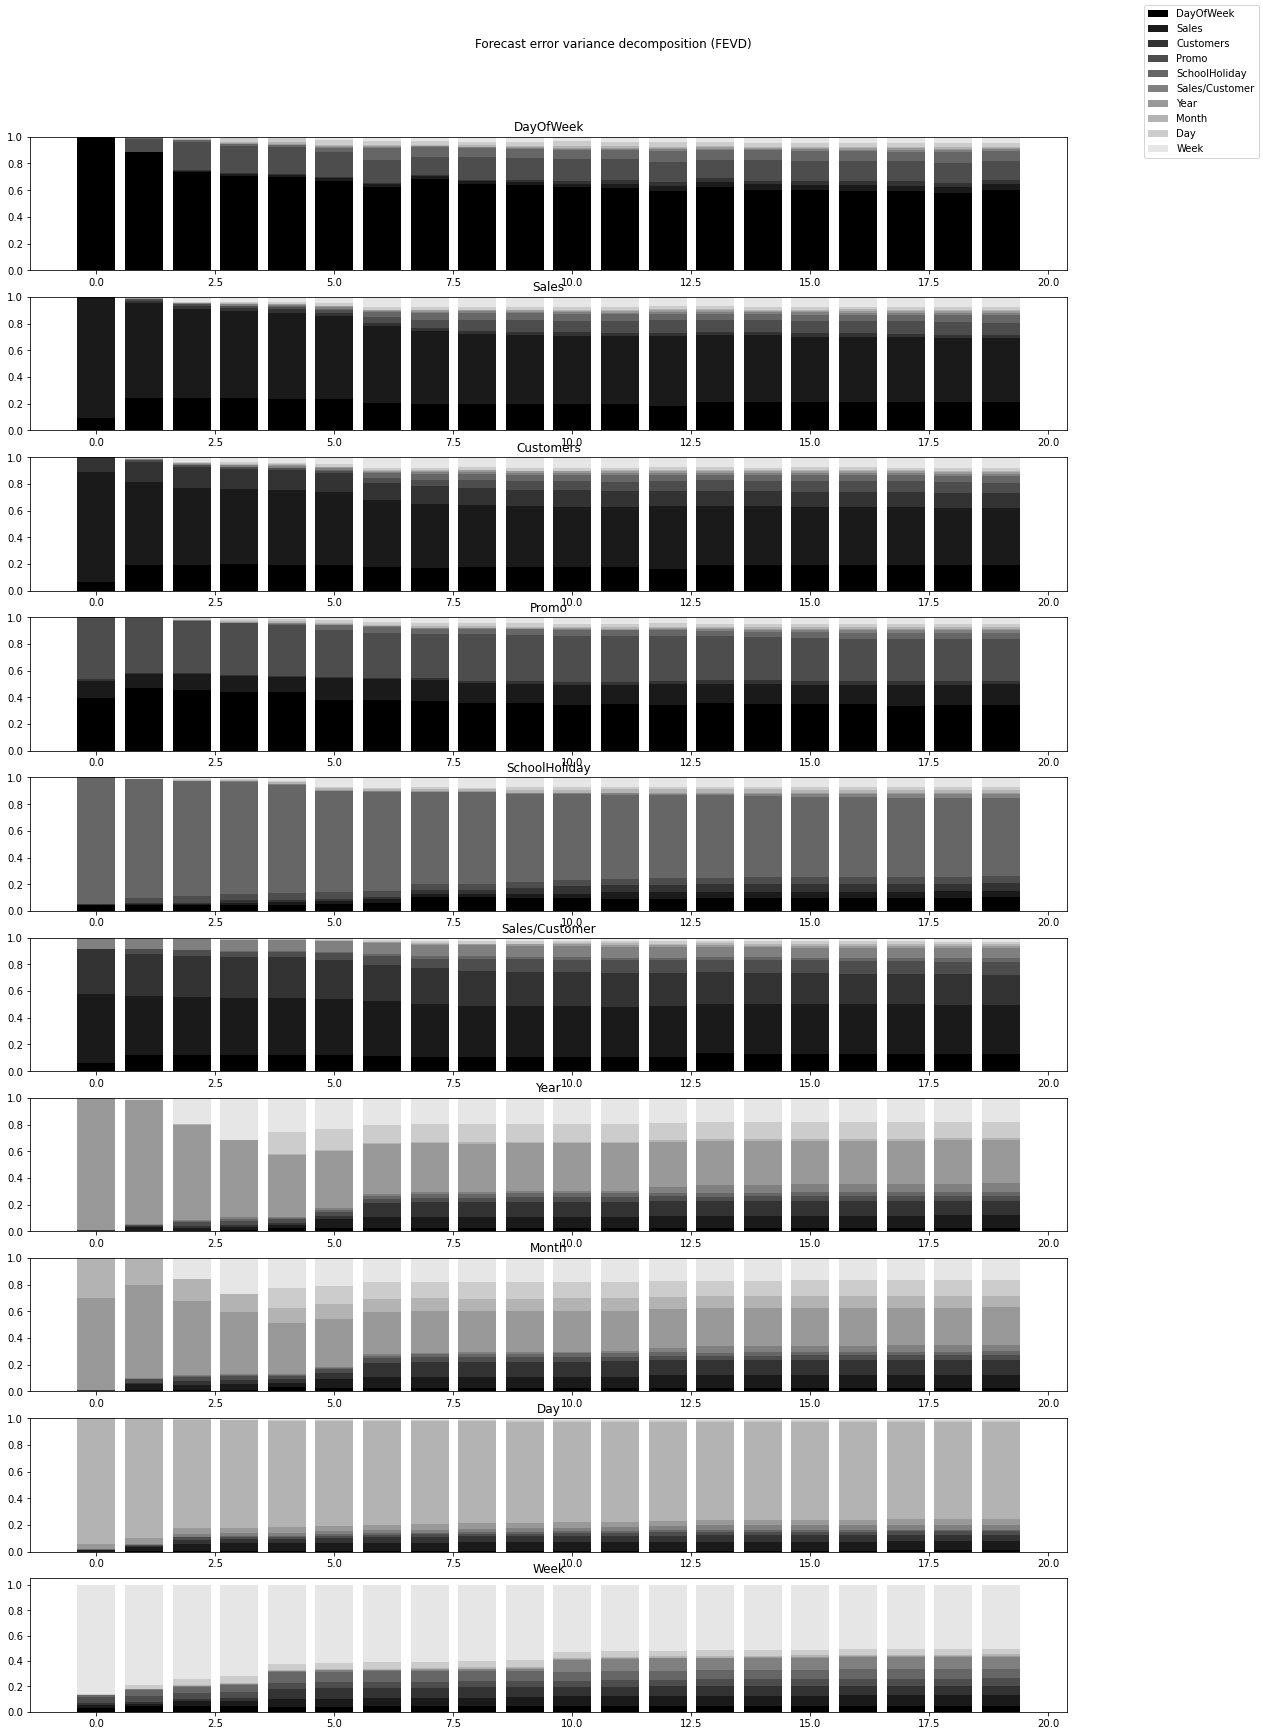

In [270]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [271]:
# Use the adfuller_test function on data.

for name, column in Store29.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -8.3239
 No. Lags Chosen      = 15
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -2.9067
 No. Lags Chosen      = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0446. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.

In [272]:
# look for the columns which have same value in all its rows.

Store29.nunique()

DayOfWeek           6
Sales             733
Customers         388
Promo               2
SchoolHoliday       2
Sales/Customer    777
Year                3
Month              12
Day                31
Week               52
dtype: int64

In [273]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store29 = Store29[["Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", "Day",
                        "Week"]]

In [274]:
# examine data.

Store29.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  Year  \
index                                                                         
2013-01-02 -0.543329  -0.530279      0              1        9.580000  2013   
2013-01-03 -0.773715  -0.764597      0              1        9.986842  2013   
2013-01-04 -0.497574  -0.642452      0              1       10.714851  2013   
2013-01-05 -0.448274  -0.562684      0              0       10.361266  2013   
2013-01-07  1.237574   0.249952      1              0       12.509849  2013   

            Month  Day  Week  
index                         
2013-01-02      1    2     1  
2013-01-03      1    3     1  
2013-01-04      1    4     1  
2013-01-05      1    5     1  
2013-01-07      1    7     2

In [275]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store29[0:-nobs], Store29[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(737, 9)
(42, 9)


In [276]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

Sales  Customers  Promo  SchoolHoliday  Sales/Customer  Year  \
index                                                                         
2013-01-03 -0.230386  -0.234318    0.0            0.0        0.406842   0.0   
2013-01-04  0.276141   0.122145    0.0            0.0        0.728009   0.0   
2013-01-05  0.049299   0.079768    0.0           -1.0       -0.353585   0.0   
2013-01-07  1.685848   0.812636    1.0            0.0        2.148583   0.0   
2013-01-08 -1.147421  -0.580811    0.0            0.0       -1.025722   0.0   

            Month  Day  Week  
index                         
2013-01-03    0.0  1.0   0.0  
2013-01-04    0.0  1.0   0.0  
2013-01-05    0.0  1.0   0.0  
2013-01-07    0.0  2.0   1.0  
2013-01-08    0.0  1.0   0.0

In [277]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.6766
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.2732
 No. Lags Chosen      = 20
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Promo" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Tes


1. Now all features are stationary. lets build the model.

In [278]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -23.59519019621785
BIC :  -23.031940747334644
FPE :  5.659077761399665e-11
HQIC:  -23.3779534547872 

Lag Order = 2
AIC :  -24.406874630312192
BIC :  -23.335559856615895
FPE :  2.513473105515119e-11
HQIC:  -23.993658619665347 

Lag Order = 3
AIC :  -25.371610084732787
BIC :  -23.791145259527553
FPE :  9.580653077713142e-12
HQIC:  -24.761971488028806 

Lag Order = 4
AIC :  -26.28457073292661
BIC :  -24.19386730239503
FPE :  3.846741525390141e-12
HQIC:  -25.47806463239133 

Lag Order = 5
AIC :  -26.726335034334692
BIC :  -24.12430059885397
FPE :  2.4748622851332633e-12
HQIC:  -25.722514903356583 

Lag Order = 6
AIC :  -27.077096216683433
BIC :  -23.962634512025204
FPE :  1.7445554345099444e-12
HQIC:  -25.875513911859965 

Lag Order = 7
AIC :  -27.179784921395356
BIC :  -23.551795799808268
FPE :  1.5766698135832016e-12
HQIC:  -25.77999067452957 

Lag Order = 8
AIC :  -27.20362335474769
BIC :  -23.061002765921835
FPE :  1.5426228377697045e-12
HQIC:  -25.605165764794513

In [279]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [280]:
# Fit the lowest metrics' lag which is 11

res = mod.fit(11)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:20
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -21.7620
Nobs:                     725.000    HQIC:                  -25.2580
Log likelihood:           1593.91    FPE:                1.21144e-12
AIC:                     -27.4551    Det(Omega_mle):     3.78669e-13
--------------------------------------------------------------------
Results for equation Sales
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.646746         0.260560            2.482           0.013
L1.Sales                  -1.353907         0.389014           -3.480           0.001
L1.Customers               1.036724     

In [281]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store29.index[-42:], columns = Store29.columns)
predict_data

Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13  0.772515   0.420991  0.060869       0.137701        0.469836   
2015-06-15 -0.279164  -0.203858  0.021578       0.012946        0.182774   
2015-06-16  0.640585   0.299592  0.148195      -0.184555        0.631185   
2015-06-17 -0.509411  -0.250089 -0.044324       0.072637       -0.445402   
2015-06-18  0.197733   0.092730  0.203122      -0.053633        0.242393   
2015-06-19  0.195435   0.109049  0.074737       0.005942        0.259011   
2015-06-20 -0.270087  -0.092822 -0.110996       0.204534       -0.493216   
2015-06-22  0.149697   0.042834 -0.023240      -0.191629        0.400449   
2015-06-23 -0.064488  -0.005374  0.099303       0.057273       -0.234854   
2015-06-24 -0.155160  -0.063851 -0.003101       0.088544       -0.238690   
2015-06-25 -0.338136  -0.175216 -0.313302      -0.091321       -0.367083   
2015-06-26 -0.135361  -0.082398 -0.020001      -0.098027       -0.143075   
2015-06-27  0.204505   0.109316 -0.102578       0.124755        0.111724   
2015-06-29 -0.065191  -0.027266 -0.083571      -0.021204       -0.125446   
2015-06-30  0.339876   0.129983  0.123250       0.010846        0.537305   
2015-07-01 -0.096199  -0.037998  0.093424       0.049365       -0.058684   
2015-07-02  0.195422   0.090347  0.140761      -0.101458        0.275426   
2015-07-03  0.235146   0.116649  0.153231      -0.033586        0.288995   
2015-07-04 -0.191386  -0.078223 -0.009961       0.055916       -0.208442   
2015-07-06  0.059563   0.021158 -0.027802      -0.046672        0.101846   
2015-07-07 -0.065494  -0.017110  0.058924       0.039940       -0.178144   
2015-07-08 -0.098570  -0.048087 -0.031471       0.022480       -0.110995   
2015-07-09 -0.225575  -0.105842 -0.214294       0.021784       -0.309263   
2015-07-10 -0.067624  -0.030630 -0.030555      -0.055884       -0.146162   
2015-07-11  0.024235   0.006150 -0.096571       0.046049        0.038013   
2015-07-13 -0.040160  -0.019927 -0.087003      -0.031891       -0.071714   
2015-07-14  0.131837   0.053623  0.028747       0.010378        0.181439   
2015-07-15  0.018757   0.008222  0.063312       0.038214        0.071440   
2015-07-16  0.119528   0.050598  0.091793      -0.047344        0.195307   
2015-07-17  0.220798   0.106409  0.160644      -0.006318        0.282869   
2015-07-18 -0.088618  -0.032394  0.034217       0.002603       -0.082201   
2015-07-20  0.075517   0.031922  0.036638      -0.025072        0.107626   
2015-07-21 -0.032133  -0.007986  0.055125       0.032646       -0.084630   
2015-07-22 -0.112764  -0.050011 -0.059608      -0.003666       -0.145020   
2015-07-23 -0.151095  -0.071451 -0.155538       0.015779       -0.221676   
2015-07-24 -0.069439  -0.031331 -0.045058      -0.008855       -0.136418   
2015-07-25 -0.038692  -0.020342 -0.098840       0.017069       -0.053040   
2015-07-27 -0.019229  -0.010677 -0.070321      -0.012102       -0.037884   
2015-07-28  0.058578   0.021504  0.018124      -0.000521        0.093320   
2015-07-29  0.051568   0.023012  0.043955       0.012111        0.097404   
2015-07-30  0.095033   0.042467  0.068349      -0.025566        0.142268   
2015-07-31  0.157251   0.073601  0.123139       0.001703        0.215570   

                Year     Month       Day      Week  
index                                               
2015-06-13 -0.006579 -0.017942  4.110956 -5.126148  
2015-06-15  0.005013  0.009079 -0.742060  0.913953  
2015-06-16  0.069375 -0.683505 -3.115851  2.425549  
2015-06-17  0.016913 -0.060577 -3.102766 -1.923446  
2015-06-18  0.002975  0.069994 -2.133069 -0.005442  
2015-06-19 -0.018807  0.240325  0.660622  2.170451  
2015-06-20  0.031319 -0.312528 -0.754015  0.177042  
2015-06-22 -0.031544  0.379918  1.212714  1.123364  
2015-06-23 -0.014255  0.159303  1.766889  0.622606  
2015-06-24 -0.014682  0.178640  1.139090 -0.573035  
2015-06-25 -0.008219  0.090777  1.

In [282]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

               Sales  Customers     Promo  SchoolHoliday  Sales/Customer  \
index                                                                      
2015-06-13  1.240631   0.321958  0.060869       0.137701       12.099158   
2015-06-15  3.028500   0.955663  1.082447       0.150647       14.649777   
2015-06-16  2.235856   0.642039  1.230642      -0.033908       14.045173   
2015-06-17  1.307561   0.190037  1.186317       0.038729       13.235935   
2015-06-18  1.612593   0.292738  1.389439      -0.014904       13.863395   
2015-06-19  1.594719   0.399294  1.464176      -0.008962       13.239117   
2015-06-20  1.121957   0.321429  0.353180       0.195572       11.800698   
2015-06-22  0.846647   0.045192  0.329940       0.003943       12.336754   
2015-06-23  0.806970  -0.054907  0.429243       0.061216       12.968699   
2015-06-24  0.772964   0.028314  0.426143       0.149759       12.210396   
2015-06-25  0.089410  -0.221684  0.112841       0.058439       10.636537   
2015-06-26  

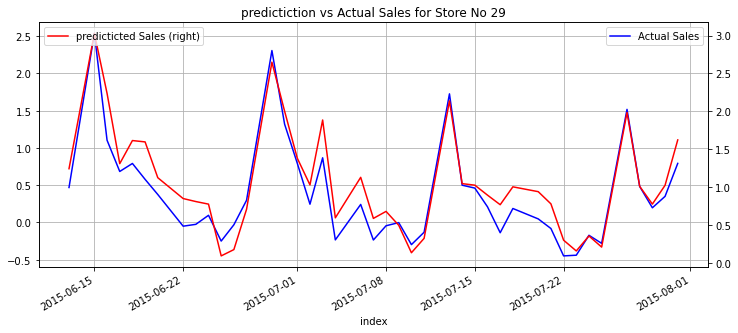

In [283]:
# Plot shows the actual sales and predicticted sales for Store No 29.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 29")
plt.show()

In [284]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.669363
Mean Squared Error(MSE) : 0.490342
Root Mean Square Error(RMSE) : 0.700245
Mean Absolute Percentage Error(MAPE) : -559.700000
Mean Absolute Error(MAE): 0.669363


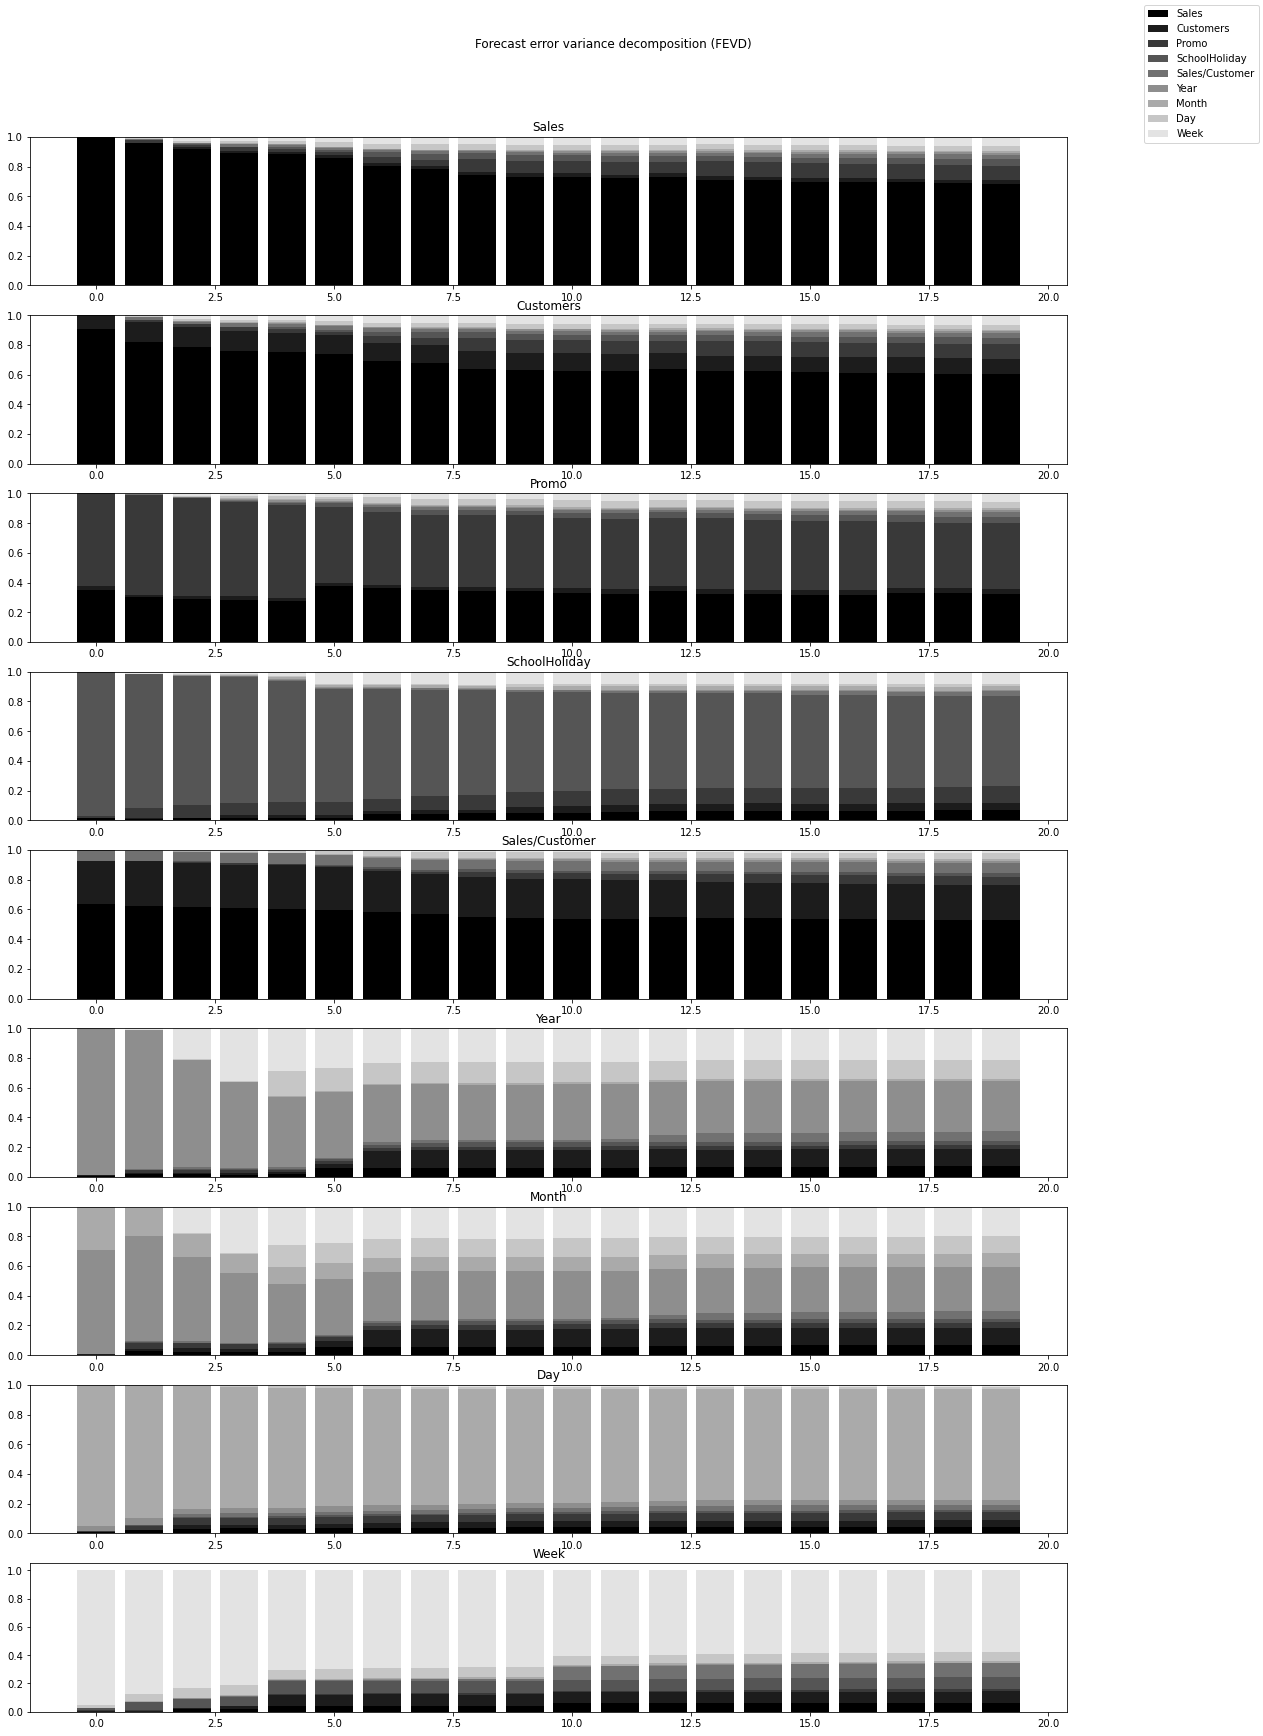

In [285]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.8. Model for Store No. 31.

### Model 1.

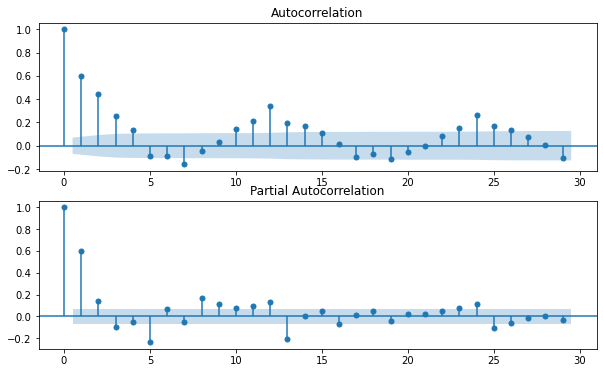

In [286]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store31.Sales, ax = ax[0])
ax[1] = plot_pacf(Store31.Sales, ax = ax[1])

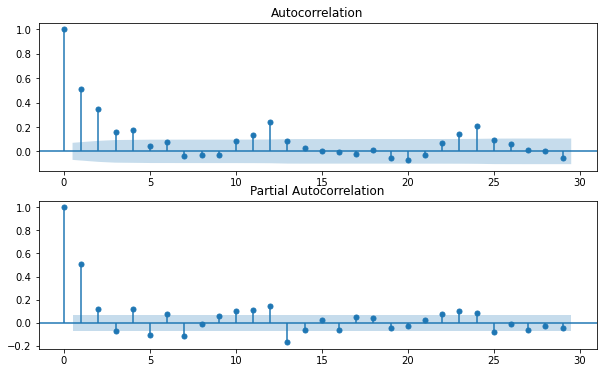

In [287]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store31.Customers, ax = ax[0])
ax[1] = plot_pacf(Store31.Customers, ax = ax[1])

In [288]:
# Use the adfuller_test function on data.

for name, column in Store31.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3404
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [289]:
# look for the columns which have same value in all its rows.

Store31.nunique()

Store                          1
DayOfWeek                      6
Sales                        702
Customers                    288
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               784
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              31
PromoOpen                    127
dtype: int64

In [290]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store31 = Store31[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", "Day",
                        "Week"]]

In [291]:
# examine data.

Store31.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.590695  -0.487902      0              1   
2013-01-03          4 -0.429263  -0.460482      0              1   
2013-01-04          5 -0.262676  -0.323381      0              1   
2013-01-05          6 -0.434419  -0.345815      0              0   
2013-01-07          1  0.290573  -0.049178      1              0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-02        9.033510  2013      1    2     1  
2013-01-03        9.728374  2013      1    3     1  
2013-01-04        9.699842  2013      1    4     1  
2013-01-05        8.985577  2013      1    5     1  
2013-01-07       10.574697  2013      1    7     2

In [292]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store31[0:-nobs], Store31[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(742, 10)
(42, 10)


In [293]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0  0.161432   0.027420    0.0            0.0   
2013-01-04        1.0  0.166587   0.137101    0.0            0.0   
2013-01-05        1.0 -0.171743  -0.022435    0.0           -1.0   
2013-01-07       -5.0  0.724992   0.296637    1.0            0.0   
2013-01-08        1.0 -0.443695  -0.326550    0.0            0.0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-03        0.694864   0.0    0.0  1.0   0.0  
2013-01-04       -0.028532   0.0    0.0  1.0   0.0  
2013-01-05       -0.714265   0.0    0.0  1.0   0.0  
2013-01-07        1.589120   0.0    0.0  2.0   1.0  
2013-01-08        0.013538   0.0    0.0  1.0   0.0

In [294]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -11.2639
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -9.4237
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [295]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:28
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -24.1165
Nobs:                     730.000    HQIC:                  -28.4060
Log likelihood:           2103.42    FPE:                3.18828e-14
AIC:                     -31.1005    Det(Omega_mle):     7.74150e-15
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.059160         0.383260            0.154           0.877
L1.DayOfWeek              -0.955882         0.054653          -17.490           0.000
L1.Sales                   1.165373 

In [296]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store31.index[-42:], columns = Store31.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   0.326997 -0.012714   0.007702  0.064787       0.026392   
2015-06-15  -3.941945  0.447545   0.117932  0.795787      -0.011631   
2015-06-16   0.705099 -0.187866  -0.113641  0.069451       0.038574   
2015-06-17   1.102519 -0.026859   0.023182 -0.034030      -0.029114   
2015-06-18   0.504482  0.007452   0.059643  0.038003       0.013112   
2015-06-19   1.210506  0.080984   0.048694 -0.191443      -0.007493   
2015-06-20   0.238004 -0.432141  -0.186851 -0.706365      -0.059544   
2015-06-22  -3.488324  0.092078   0.050465  0.082148       0.084760   
2015-06-23   0.536187 -0.141715  -0.120017  0.016602       0.007689   
2015-06-24   1.052650 -0.023343  -0.004990 -0.010545       0.033184   
2015-06-25   0.764176  0.160004   0.106953  0.026862      -0.087795   
2015-06-26   0.718892  0.144864   0.099890 -0.038578       0.013205   
2015-06-27  -0.318748 -0.005326  -0.038296  0.086209       0.013116   
2015-06-29  -2.614213  0.188461   0.037502  0.503052       0.064925   
2015-06-30   0.729156 -0.101207  -0.068897  0.023368       0.002917   
2015-07-01   0.880415 -0.109760  -0.035128 -0.019259      -0.024537   
2015-07-02   0.461484  0.113478   0.086669  0.088859      -0.006391   
2015-07-03   0.787373  0.007843   0.024977 -0.205784      -0.049381   
2015-07-04  -0.419702 -0.244782  -0.113501 -0.416319      -0.032866   
2015-07-06  -2.323542  0.002465  -0.013646  0.102202       0.074251   
2015-07-07   0.726251 -0.088097  -0.067891 -0.010246       0.023308   
2015-07-08   1.019917 -0.009440   0.009157 -0.089015      -0.010633   
2015-07-09   0.328302  0.094350   0.075340  0.005096      -0.049755   
2015-07-10   0.412182  0.113858   0.068798 -0.016064      -0.004030   
2015-07-11  -0.590368  0.003204  -0.030178  0.091792       0.004416   
2015-07-13  -1.746163  0.134108   0.027706  0.363024       0.043420   
2015-07-14   0.790036 -0.073912  -0.048854  0.029817       0.006064   
2015-07-15   0.838820 -0.032379   0.006816 -0.024081      -0.002035   
2015-07-16   0.227382  0.081845   0.060033  0.056250      -0.024766   
2015-07-17   0.372298 -0.007710   0.009927 -0.174475      -0.031123   
2015-07-18  -0.593029 -0.175407  -0.087056 -0.256043      -0.006905   
2015-07-20  -1.519491 -0.006471  -0.015859  0.104314       0.053842   
2015-07-21   0.798351 -0.056430  -0.041396 -0.022859       0.012059   
2015-07-22   0.878414 -0.020303   0.008113 -0.105320      -0.020786   
2015-07-23   0.087201  0.083161   0.063121 -0.004352      -0.020092   
2015-07-24   0.126705  0.058407   0.028280 -0.004178      -0.007068   
2015-07-25  -0.613970  0.002559  -0.025385  0.082751       0.013243   
2015-07-27  -1.109179  0.077314   0.012456  0.251268       0.032800   
2015-07-28   0.768750 -0.041312  -0.024752  0.023915       0.000156   
2015-07-29   0.714893 -0.008892   0.014495 -0.021338      -0.008980   
2015-07-30   0.043448  0.071963   0.049537  0.034254      -0.018516   
2015-07-31   0.115114 -0.023991  -0.007004 -0.134094      -0.024057   

            Sales/Customer      Year     Month       Day      Week  
index                                                               
2015-06-13       -0.138131 -0.007014  0.063523  1.651892  1.730398  
2015-06-15        1.372064  0.005472 -0.004826 -0.046228  1.140867  
2015-06-16       -0.060991 -0.018524  0.234402  0.693202  0.539795  
2015-06-17       -0.277735 -0.013103  0.217806 -0.826946  0.034049  
2015-06-18       -0.423292 -0.011795  0.132636  1.380723 -1.358148  
2015-06-19        0.129887 -0.005294  0.142254 -1.361703 -0.162947  
2015-06-20       -1.009050  0.014676 -0.157893  0.714945  0.703662  
2015-06-22        0.059842  0.017599 -0.107361 -1.405969 -0.321229  
2015-06-23        0.027765 -0.007145  0.098690  0.673580 -0.023965  
2015-06-24       -0.074829  0.002963 -0.002149  0.078015  0.404218  
2015-06-25        0.178103  0.018090 -0.175688 -0.153822  0

In [297]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   6.326997 -0.609531  -0.582402  0.064787       0.026392   
2015-06-15  -2.614948  0.775992  -0.073109  1.860574       0.014761   
2015-06-16  -0.909849  0.231108  -0.408605  1.930025       0.053335   
2015-06-17   1.192670  0.010918  -0.492612  1.895994       0.024221   
2015-06-18   2.697152 -0.085385  -0.415519  1.933997       0.037332   
2015-06-19   4.907658 -0.037589  -0.381781  1.742555       0.029840   
2015-06-20   6.145661 -0.743294  -0.628458  0.036189      -0.029704   
2015-06-22  -2.342663 -0.732737  -0.707616  0.118338       0.055056   
2015-06-23  -0.806476 -1.020095  -0.922358  0.134940       0.062744   
2015-06-24   1.246174 -1.039894  -0.810188  0.124394       0.095928   
2015-06-25   3.010351 -0.869580  -0.768047  0.151256       0.008133   
2015-06-26   4.729242 -0.687016  -0.548504  0.112678       0.021339   
2015-0

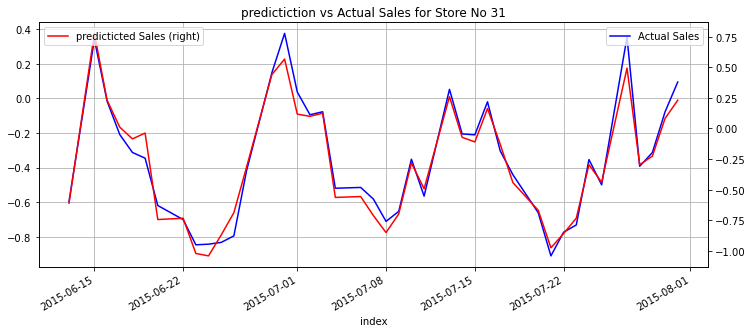

In [298]:
# Plot shows the actual sales and predicticted sales for Store No 31.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 31")
plt.show()

In [299]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.075407
Mean Squared Error(MSE) : 0.024881
Root Mean Square Error(RMSE) : 0.157739
Mean Absolute Percentage Error(MAPE) : -64.440000
Mean Absolute Error(MAE): 0.128809


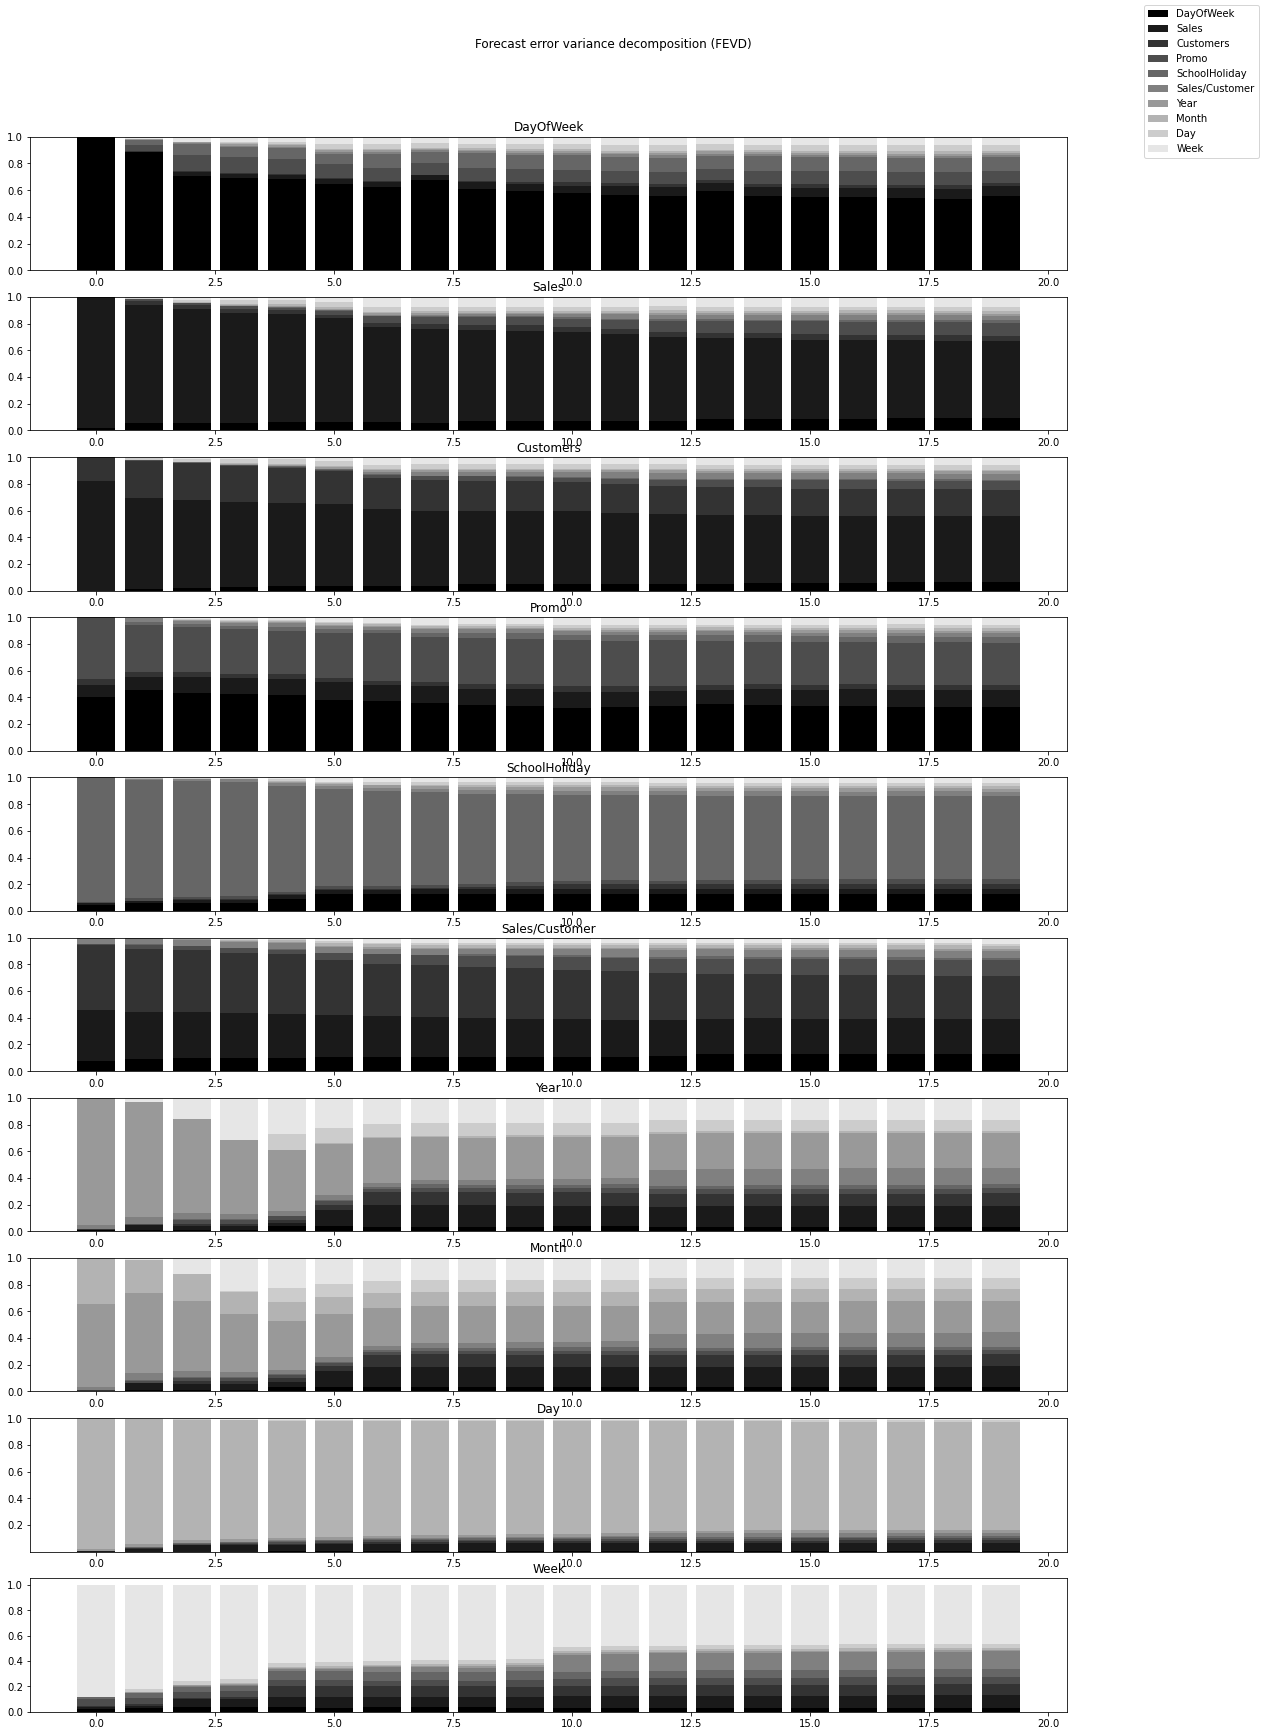

In [300]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [301]:
# Use the adfuller_test function on data.

for name, column in Store31.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.3404
 No. Lags Chosen      = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.8654
 No. Lags Chosen      = 12
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


In [302]:
# look for the columns which have same value in all its rows.

Store31.nunique()

DayOfWeek           6
Sales             702
Customers         288
Promo               2
SchoolHoliday       2
Sales/Customer    784
Year                3
Month              12
Day                31
Week               52
dtype: int64

In [303]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store31 = Store31[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month"]]

In [304]:
# examine data.

Store31.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.590695  -0.487902      0              1   
2013-01-03          4 -0.429263  -0.460482      0              1   
2013-01-04          5 -0.262676  -0.323381      0              1   
2013-01-05          6 -0.434419  -0.345815      0              0   
2013-01-07          1  0.290573  -0.049178      1              0   

            Sales/Customer  Year  Month  
index                                    
2013-01-02        9.033510  2013      1  
2013-01-03        9.728374  2013      1  
2013-01-04        9.699842  2013      1  
2013-01-05        8.985577  2013      1  
2013-01-07       10.574697  2013      1

In [305]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store31[0:-nobs], Store31[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(742, 8)
(42, 8)


In [306]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0  0.161432   0.027420    0.0            0.0   
2013-01-04        1.0  0.166587   0.137101    0.0            0.0   
2013-01-05        1.0 -0.171743  -0.022435    0.0           -1.0   
2013-01-07       -5.0  0.724992   0.296637    1.0            0.0   
2013-01-08        1.0 -0.443695  -0.326550    0.0            0.0   

            Sales/Customer  Year  Month  
index                                    
2013-01-03        0.694864   0.0    0.0  
2013-01-04       -0.028532   0.0    0.0  
2013-01-05       -0.714265   0.0    0.0  
2013-01-07        1.589120   0.0    0.0  
2013-01-08        0.013538   0.0    0.0

In [307]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -11.2639
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -9.4237
 No. Lags Chosen      = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [308]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -24.749741593898708
BIC :  -24.30152698118753
FPE :  1.7837252680706898e-11
HQIC:  -24.57692665959845 

Lag Order = 2
AIC :  -25.208950199586447
BIC :  -24.361425819005994
FPE :  1.1269904587968202e-11
HQIC:  -24.882155618379258 

Lag Order = 3
AIC :  -25.792458860167017
BIC :  -24.544777606887756
FPE :  6.28879653594887e-12
HQIC:  -25.311338524257614 

Lag Order = 4
AIC :  -26.42611797854792
BIC :  -24.777429778360695
FPE :  3.3380356206914437e-12
HQIC:  -25.79032453826862 

Lag Order = 5
AIC :  -28.11779933527895
BIC :  -26.067251130193252
FPE :  6.151712905391093e-13
HQIC:  -27.326984192997777 

Lag Order = 6
AIC :  -28.539971768142205
BIC :  -26.086707501895358
FPE :  4.035857986226989e-13
HQIC:  -27.593785072133148 

Lag Order = 7
AIC :  -28.718644600347716
BIC :  -25.861805203824257
FPE :  3.3786234236525343e-13
HQIC:  -27.616735238622795 

Lag Order = 8
AIC :  -28.754752299773546
BIC :  -25.493475676334175
FPE :  3.2628157873669754e-13
HQIC:  -27.49676789387

In [309]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [310]:
# Fit the lowest metrics' lag which is 12.

res = mod.fit(12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:35
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -24.1280
Nobs:                     729.000    HQIC:                  -27.1299
Log likelihood:           3076.99    FPE:                2.53592e-13
AIC:                     -29.0157    Det(Omega_mle):     9.33503e-14
--------------------------------------------------------------------
Results for equation DayOfWeek
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.009873         0.035414            0.279           0.780
L1.DayOfWeek              -0.867719         0.051475          -16.857           0.000
L1.Sales                   1.300362 

In [311]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store31.index[-42:], columns = Store31.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   0.490901 -0.013527   0.019038  0.045991       0.043563   
2015-06-15  -4.153715  0.405103   0.102167  0.817243       0.001284   
2015-06-16   0.668160 -0.190349  -0.147963  0.058165       0.005178   
2015-06-17   1.165414 -0.064500   0.022367 -0.040218      -0.017547   
2015-06-18   0.609906  0.034284   0.068861  0.032834       0.015270   
2015-06-19   1.092046  0.072481   0.040195 -0.162454      -0.016614   
2015-06-20   0.490098 -0.439724  -0.178630 -0.729335      -0.069950   
2015-06-22  -3.797543  0.080361   0.025581  0.103853       0.044651   
2015-06-23   0.411029 -0.111634  -0.098654  0.062616       0.032461   
2015-06-24   1.328997 -0.059755  -0.030294 -0.027034       0.027638   
2015-06-25   0.862129  0.163485   0.113546  0.004426      -0.103030   
2015-06-26   0.666911  0.214259   0.140612 -0.017202      -0.013320   
2015-06-27  -0.222022 -0.069810  -0.069763  0.001434       0.021325   
2015-06-29  -3.060343  0.224569   0.049106  0.558529       0.074086   
2015-06-30   0.799350 -0.107273  -0.076019  0.036794       0.004510   
2015-07-01   1.088614 -0.102910  -0.025220 -0.029870      -0.002119   
2015-07-02   0.678098  0.090626   0.078585  0.060050      -0.053252   
2015-07-03   0.594873  0.059243   0.052754 -0.157977      -0.032931   
2015-07-04  -0.361230 -0.270299  -0.133896 -0.435419      -0.026976   
2015-07-06  -2.643093 -0.005015  -0.018023  0.132102       0.074987   
2015-07-07   0.756280 -0.090299  -0.068226 -0.001390       0.032645   
2015-07-08   1.202264 -0.008627   0.009776 -0.084184       0.000268   
2015-07-09   0.565444  0.077540   0.073579 -0.043556      -0.051824   
2015-07-10   0.281922  0.133045   0.081384 -0.038321      -0.013001   
2015-07-11  -0.548893 -0.038550  -0.051925  0.029377      -0.005044   
2015-07-13  -2.142385  0.155437   0.032584  0.416539       0.063098   
2015-07-14   0.823746 -0.069269  -0.054354  0.059485       0.008272   
2015-07-15   1.070624 -0.025618   0.015350 -0.023407       0.001828   
2015-07-16   0.459505  0.078315   0.065679  0.047204      -0.035532   
2015-07-17   0.228498  0.046508   0.034219 -0.122025      -0.046971   
2015-07-18  -0.604061 -0.196004  -0.102494 -0.269233      -0.008915   
2015-07-20  -1.845765 -0.018925  -0.024736  0.123241       0.070135   
2015-07-21   0.829270 -0.073369  -0.050749 -0.017635       0.008910   
2015-07-22   1.086761 -0.014633   0.014175 -0.106004      -0.011809   
2015-07-23   0.338699  0.060568   0.057355 -0.063079      -0.026350   
2015-07-24   0.018271  0.073959   0.042819 -0.037874      -0.020577   
2015-07-25  -0.676826 -0.025714  -0.041244  0.041377       0.009019   
2015-07-27  -1.457675  0.093590   0.011553  0.303179       0.054593   
2015-07-28   0.848889 -0.042052  -0.029952  0.044918      -0.000021   
2015-07-29   0.937245  0.000443   0.024431 -0.018310      -0.004891   
2015-07-30   0.237154  0.079723   0.058230  0.033917      -0.023979   
2015-07-31  -0.002378  0.016550   0.012165 -0.092629      -0.034694   

            Sales/Customer      Year     Month  
index                                           
2015-06-13       -0.204465 -0.002228  0.035630  
2015-06-15        1.202327  0.016981 -0.185251  
2015-06-16        0.190532 -0.003909  0.087183  
2015-06-17       -0.435985  0.002232  0.038283  
2015-06-18       -0.351823 -0.003735  0.041320  
2015-06-19        0.152201 -0.010832  0.198358  
2015-06-20       -1.081660  0.017144 -0.189433  
2015-06-22        0.152763  0.016241 -0.082928  
2015-06-23        0.050843 -0.008895  0.121401  
2015-06-24       -0.103061  0.005978 -0.038873  
2015-06-25        0.132534  0.021270 -0.222393  
2015-06-26        0.224251  0.000934  0.057173  
2015-06-27        0.089968 -0.011178  0.210214  
2015-06-29        0.753719  0.019083 -0.136557  
2015-06-30        0.044999  0.014977 -0.130423  
2015-07-01       -0.347019 -0.008398  0.117630  
2015-

In [312]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   6.490901 -0.610344  -0.571067  0.045991       0.043563   
2015-06-15  -2.662814  0.732738  -0.077538  1.863234       0.044848   
2015-06-16  -0.994655  0.185371  -0.447356  1.921399       0.050026   
2015-06-17   1.170759 -0.072460  -0.532177  1.881181       0.032478   
2015-06-18   2.780665 -0.141931  -0.445867  1.914014       0.047748   
2015-06-19   4.872711 -0.102638  -0.420628  1.751561       0.031135   
2015-06-20   6.362809 -0.815925  -0.659084  0.022225      -0.038815   
2015-06-22  -2.434733 -0.817086  -0.763126  0.126079       0.005836   
2015-06-23  -1.023704 -1.074362  -0.956504  0.188695       0.038297   
2015-06-24   1.305292 -1.130573  -0.869639  0.161661       0.065935   
2015-06-25   3.167421 -0.956777  -0.820905  0.166087      -0.037095   
2015-06-26   4.834332 -0.704818  -0.560641  0.148885      -0.050415   
2015-0

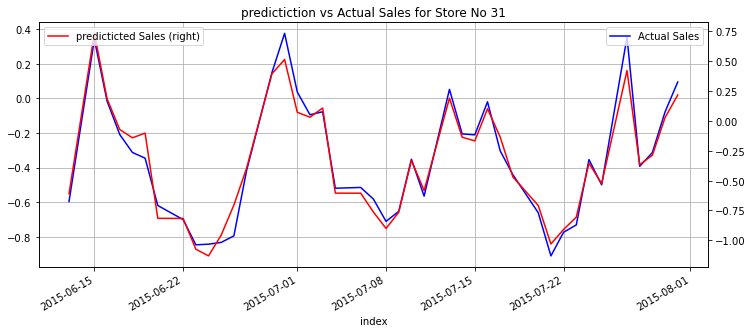

In [313]:
# Plot shows the actual sales and predicticted sales for Store No 31.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 31")
plt.show()

In [314]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.019597
Mean Squared Error(MSE) : 0.020988
Root Mean Square Error(RMSE) : 0.144874
Mean Absolute Percentage Error(MAPE) : -52.050000
Mean Absolute Error(MAE): 0.118135


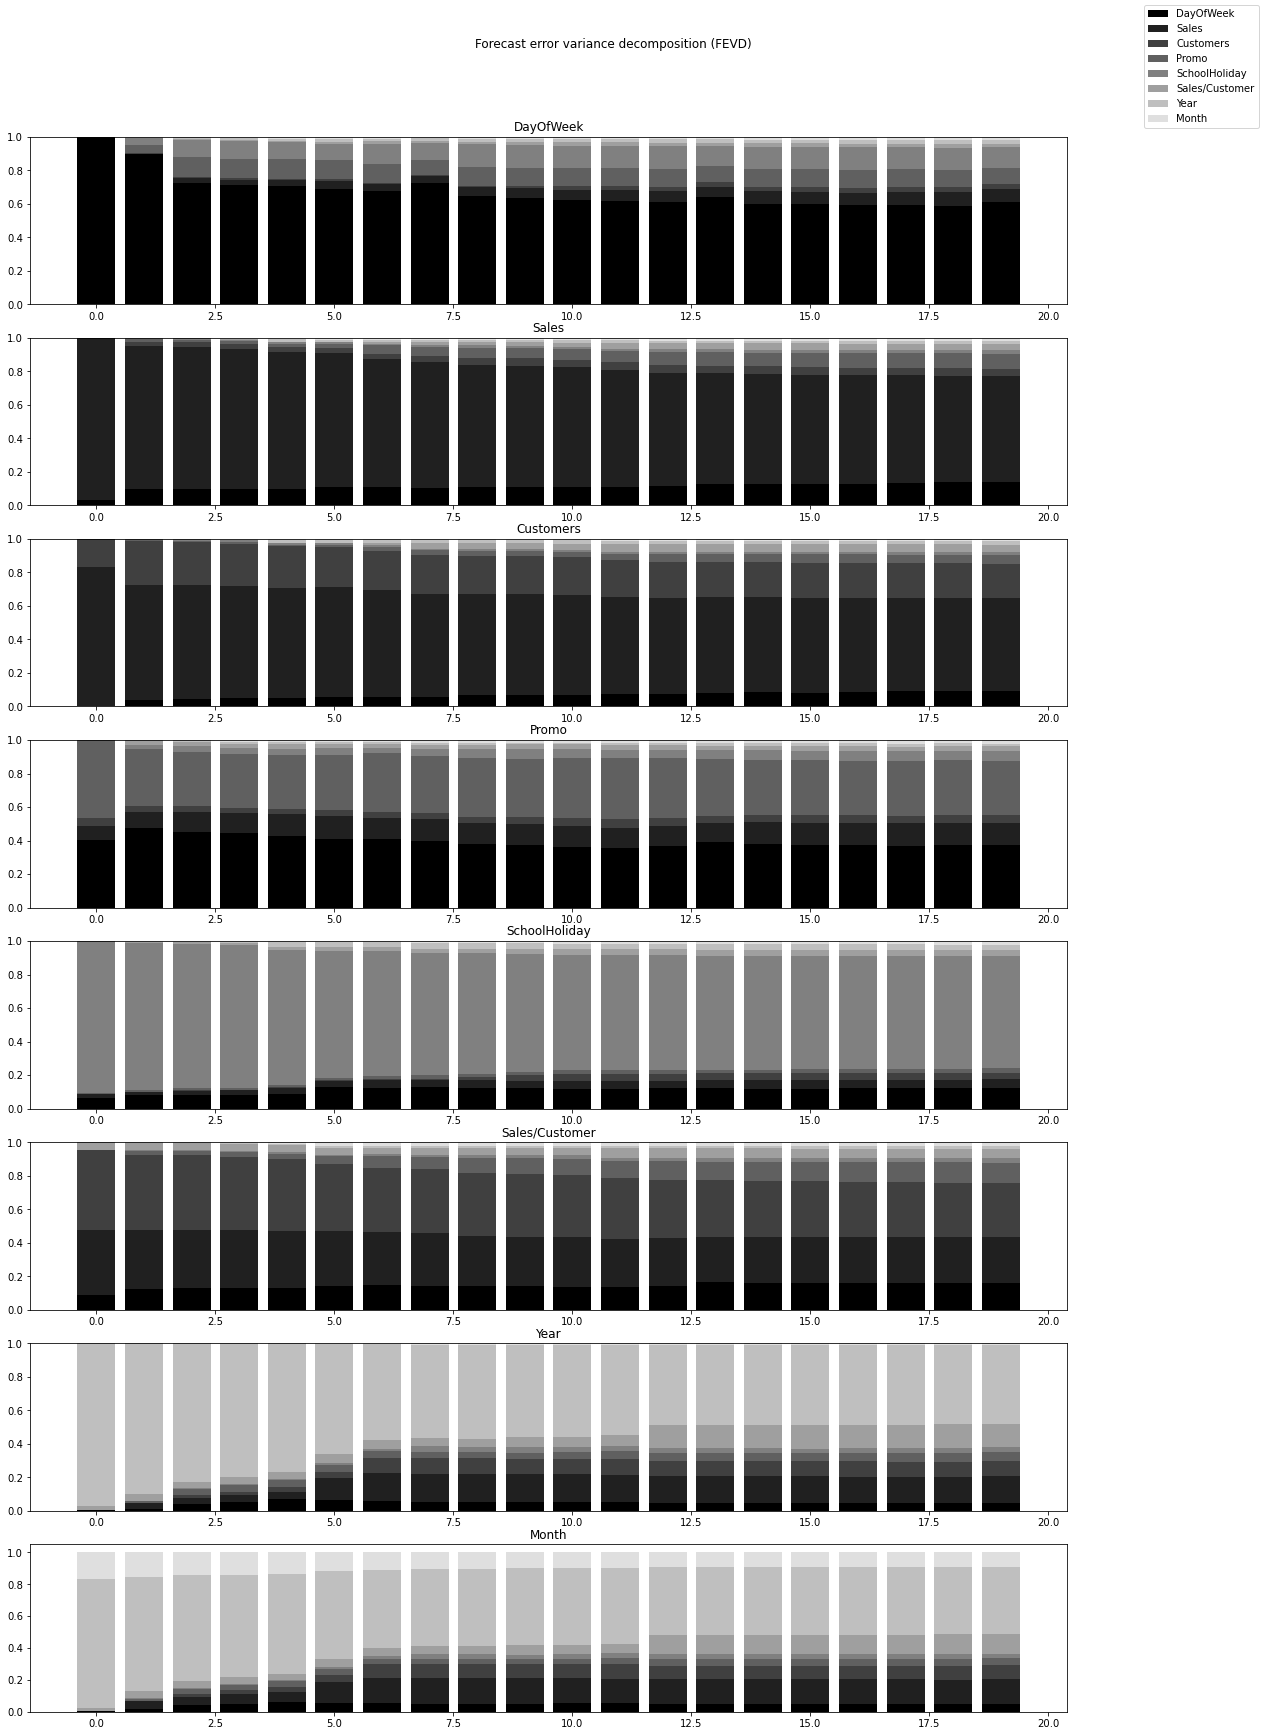

In [315]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### 6.9. Model for Store No. 46.

### Model 1.

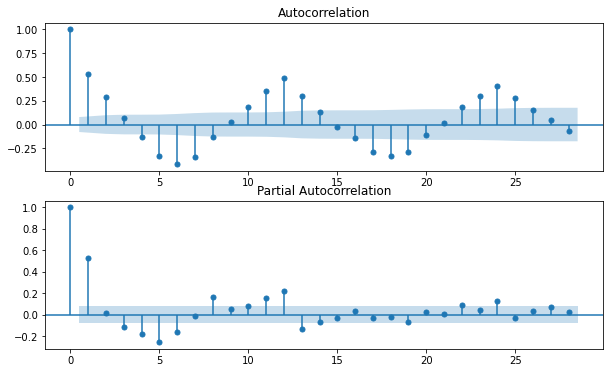

In [316]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store46.Sales, ax = ax[0])
ax[1] = plot_pacf(Store46.Sales, ax = ax[1])

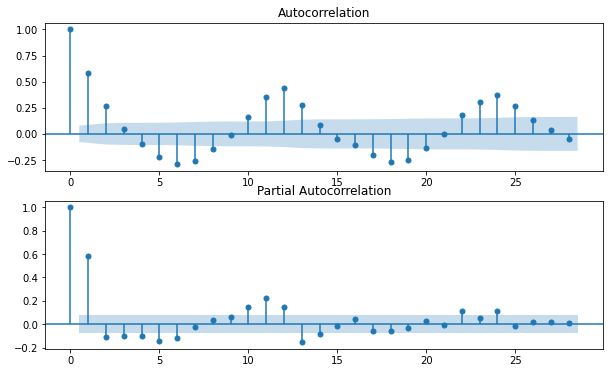

In [317]:
# Testing for autocorrelation using acf and pacf.

fig, ax = plt.subplots(2, figsize = (10, 6))
ax[0] = plot_acf(Store46.Customers, ax = ax[0])
ax[1] = plot_pacf(Store46.Customers, ax = ax[1])

In [318]:
# Use the adfuller_test function on data.

for name, column in Store46.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "Store" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = nan
 No. Lags Chosen      = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series in Non-Stationary.


   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.4141
 No. Lags Chosen      = 15
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance le


1. Some of the features are stationary but some are not stationary.
2. Some features only contain single value in its rows. so we will remove it since they are not affecting to our model.

In [319]:
# look for the columns which have same value in all its rows.

Store46.nunique()

Store                          1
DayOfWeek                      6
Sales                        581
Customers                    317
Promo                          2
StateHoliday                   1
SchoolHoliday                  2
Sales/Customer               622
Year                           3
Month                         12
Day                           31
Week                          52
StoreType                      1
Assortment                     1
CompetitionDistance            1
CompetitionOpenSinceMonth      1
CompetitionOpenSinceYear       1
Promo2                         1
Promo2SinceWeek                1
Promo2SinceYear                1
Competition_Open              25
PromoOpen                    106
dtype: int64

In [320]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store46 = Store46[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Sales/Customer", "Year", "Month", "Day",
                        "Week"]]

In [321]:
# examine data.

Store46.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-02          3 -0.947069  -0.450511      0              1   
2013-01-03          4 -0.895191  -0.522800      0              1   
2013-01-04          5 -0.911947  -0.482916      0              1   
2013-01-05          6 -0.678983  -0.278511      0              0   
2013-01-07          1  0.268340   0.155227      1              0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-02        6.900344  2013      1    2     1  
2013-01-03        7.553345  2013      1    3     1  
2013-01-04        7.249561  2013      1    4     1  
2013-01-05        7.447005  2013      1    5     1  
2013-01-07        9.440000  2013      1    7     2

In [322]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store46[0:-nobs], Store46[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(580, 10)
(42, 10)


In [323]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  \
index                                                              
2013-01-03        1.0  0.051877  -0.072290    0.0            0.0   
2013-01-04        1.0 -0.016755   0.039884    0.0            0.0   
2013-01-05        1.0  0.232964   0.204405    0.0           -1.0   
2013-01-07       -5.0  0.947323   0.433738    1.0            0.0   
2013-01-08        1.0 -0.642826  -0.396347    0.0            0.0   

            Sales/Customer  Year  Month  Day  Week  
index                                               
2013-01-03        0.653002   0.0    0.0  1.0   0.0  
2013-01-04       -0.303785   0.0    0.0  1.0   0.0  
2013-01-05        0.197444   0.0    0.0  1.0   0.0  
2013-01-07        1.992995   0.0    0.0  2.0   1.0  
2013-01-08       -0.741802   0.0    0.0  1.0   0.0

In [324]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.8836
 No. Lags Chosen      = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1304
 No. Lags Chosen      = 11
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [325]:
# Building the VAR model.

mod = smt.VAR(transform_data)
res = mod.fit(maxlags = 15, ic = "aic")
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:41
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -22.0846
Nobs:                     570.000    HQIC:                  -26.3155
Log likelihood:           1093.42    FPE:                2.55689e-13
AIC:                     -29.0224    Det(Omega_mle):     5.81361e-14
--------------------------------------------------------------------
Results for equation DayOfWeek
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.017847         0.035484            0.503           0.615
L1.DayOfWeek             -0.920932         0.062239          -14.797           0.000
L1.Sales                  1.253376      

In [326]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store46.index[-42:], columns = Store46.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   0.200180  0.432267   0.261507 -0.005621      -0.305356   
2015-06-15  -4.607214  0.669783   0.256810  0.766262       0.393178   
2015-06-16   1.370487 -0.638843  -0.317582 -0.150998       0.077367   
2015-06-17   1.068194 -0.103672  -0.059056  0.024319       0.094853   
2015-06-18   1.183620  0.127065   0.151868  0.039011      -0.003658   
2015-06-19   1.162583 -0.040891   0.025546 -0.309303      -0.259948   
2015-06-20  -1.245065 -0.172802  -0.114800 -0.369906       0.006604   
2015-06-22  -2.842228 -0.007314  -0.093286  0.193087       0.146577   
2015-06-23   0.869316 -0.137856  -0.110961  0.034940       0.029505   
2015-06-24   0.981850  0.062993   0.039050  0.062923       0.045116   
2015-06-25   1.374896 -0.038046   0.018663 -0.099165      -0.147536   
2015-06-26   0.205626  0.173856   0.150945 -0.051924      -0.077786   
2015-06-27  -1.289673  0.173531   0.080535  0.107938       0.023374   
2015-06-29  -1.898414  0.121902  -0.002496  0.317302       0.108303   
2015-06-30   0.944230 -0.216324  -0.121110 -0.012962       0.059460   
2015-07-01   1.190684 -0.073123  -0.010959 -0.045748      -0.044734   
2015-07-02   0.717086  0.085513   0.084690 -0.047620      -0.093353   
2015-07-03  -0.053239 -0.001004   0.020860 -0.160994      -0.047694   
2015-07-04  -1.122270 -0.100501  -0.079838 -0.155788       0.059750   
2015-07-06  -1.387966 -0.052593  -0.084821  0.122452       0.112827   
2015-07-07   0.939416 -0.102061  -0.063615  0.010282       0.004855   
2015-07-08   0.980797  0.035676   0.042353 -0.020957      -0.066135   
2015-07-09   0.480742  0.078381   0.076931 -0.038314      -0.064613   
2015-07-10  -0.220249  0.105774   0.073171 -0.009651      -0.023494   
2015-07-11  -1.019368  0.099753   0.027250  0.102050       0.061608   
2015-07-13  -0.865356  0.024566  -0.027052  0.199639       0.080635   
2015-07-14   0.932518 -0.138139  -0.065886 -0.025058      -0.022098   
2015-07-15   0.713405 -0.002352   0.024324 -0.034298      -0.054940   
2015-07-16   0.273091  0.036953   0.045931 -0.061140      -0.049914   
2015-07-17  -0.287983 -0.027160  -0.012446 -0.111778       0.001550   
2015-07-18  -0.784309 -0.066677  -0.062442 -0.061175       0.064761   
2015-07-20  -0.535043 -0.044460  -0.054273  0.068706       0.054967   
2015-07-21   0.751261 -0.055160  -0.026585 -0.014408      -0.027482   
2015-07-22   0.554364  0.044940   0.043318 -0.016765      -0.051701   
2015-07-23   0.150216  0.069866   0.057687 -0.013932      -0.034615   
2015-07-24  -0.333968  0.072631   0.039986  0.022010       0.013225   
2015-07-25  -0.627567  0.045001   0.003373  0.085152       0.049723   
2015-07-27  -0.280587 -0.002828  -0.020068  0.108308       0.033922   
2015-07-28   0.656446 -0.071235  -0.027330 -0.020987      -0.028568   
2015-07-29   0.399191  0.004924   0.020689 -0.034048      -0.042397   
2015-07-30   0.037842  0.011563   0.018285 -0.054080      -0.019995   
2015-07-31  -0.300290 -0.033109  -0.022396 -0.069746       0.019306   

            Sales/Customer      Year     Month       Day      Week  
index                                                               
2015-06-13        0.662930 -0.005682  0.037596  1.059279  0.122820  
2015-06-15        1.449680  0.004978  0.092130 -1.467724  1.072463  
2015-06-16       -0.987394  0.075836 -0.382073 -1.859408 -3.504235  
2015-06-17       -0.142543  0.001773  0.024769  0.685438 -0.577967  
2015-06-18       -0.142941  0.025209 -0.237132 -1.863224  0.604381  
2015-06-19       -0.222524  0.009659 -0.059805 -0.087333  1.011350  
2015-06-20       -0.311714 -0.015909  0.174090  0.746676  0.579045  
2015-06-22        0.247648 -0.020537  0.272353  0.959327  0.847155  
2015-06-23       -0.071032  0.002139  0.011398  0.379565  0.018769  
2015-06-24        0.124873 -0.003598  0.080891 -0.026872 -0.580882  
2015-06-25       -0.146004 -0.001015  0.014728  0.864289 -0

In [327]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   6.200180 -0.251549  -0.243844 -0.005621      -0.305356   
2015-06-15  -3.407034  1.515711   0.681023  1.760641       0.087822   
2015-06-16  -1.036547  0.365506   0.001992  1.609644       0.165189   
2015-06-17   1.031646  0.165491  -0.081991  1.633963       0.260042   
2015-06-18   3.215267  0.110180   0.049935  1.672974       0.256384   
2015-06-19   5.377850  0.290331   0.187656  1.363671      -0.003564   
2015-06-20   5.132785 -0.417676  -0.039318 -0.006235       0.003040   
2015-06-22  -2.709443 -0.753654  -0.474110  0.186851       0.149617   
2015-06-23  -0.840126 -0.772933  -0.565128  0.221791       0.179122   
2015-06-24   1.141724 -0.932594  -0.588397  0.284714       0.224238   
2015-06-25   3.516620 -0.696754  -0.559763  0.185549       0.076702   
2015-06-26   4.722246 -0.426554  -0.251775  0.133624      -0.001083   
2015-0

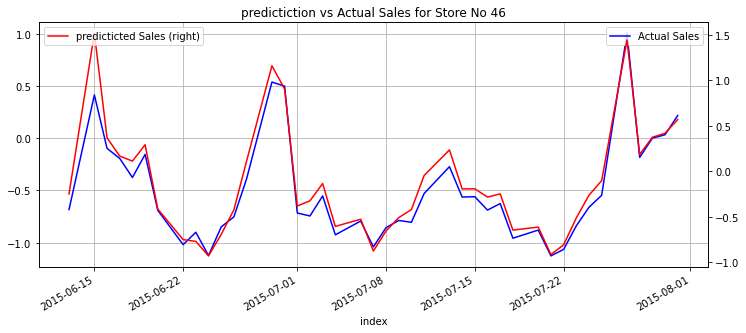

In [328]:
# Plot shows the actual sales and predicticted sales for Store No 46.

plt.figure(figsize = ( 12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 46")
plt.show()

In [329]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.369711
Mean Squared Error(MSE) : 0.160770
Root Mean Square Error(RMSE) : 0.400961
Mean Absolute Percentage Error(MAPE) : -13070.330000
Mean Absolute Error(MAE): 0.369711


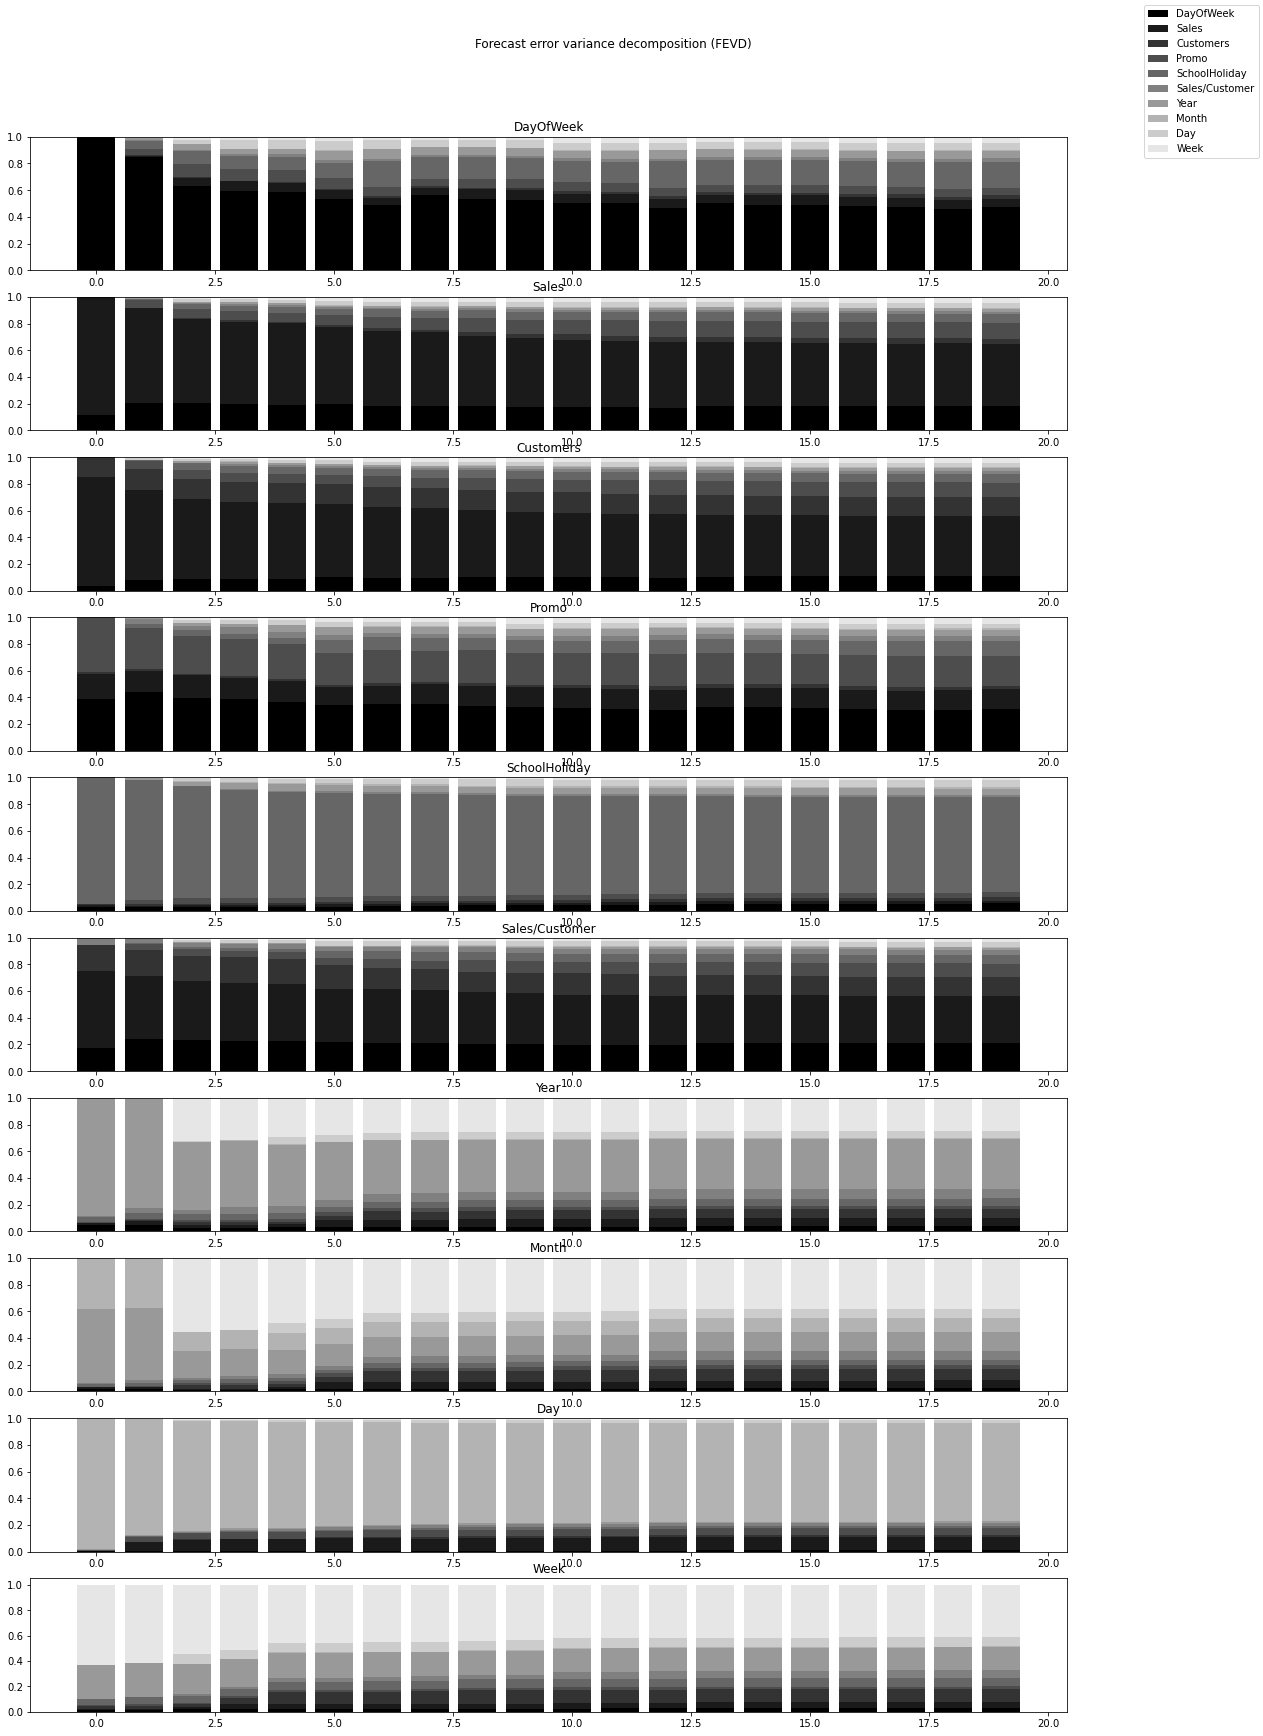

In [330]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

### Model 2. (With change in features and Lag order selection.)

In [331]:
# Use the adfuller_test function on data.

for name, column in Store46.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -7.4141
 No. Lags Chosen      = 15
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -5.2754
 No. Lags Chosen      = 12
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


In [332]:
# look for the columns which have same value in all its rows.

Store46.nunique()

DayOfWeek           6
Sales             581
Customers         317
Promo               2
SchoolHoliday       2
Sales/Customer    622
Year                3
Month              12
Day                31
Week               52
dtype: int64

In [333]:
# We are only consider those variables which have more than single value in its rows. 
# Because the column which have single value in its rows does not affect the model.

Store46 = Store46[["DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "Year", "Month", "Week"]]

In [334]:
# examine data.

Store46.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  Year  Month  \
index                                                                           
2013-01-02          3 -0.947069  -0.450511      0              1  2013      1   
2013-01-03          4 -0.895191  -0.522800      0              1  2013      1   
2013-01-04          5 -0.911947  -0.482916      0              1  2013      1   
2013-01-05          6 -0.678983  -0.278511      0              0  2013      1   
2013-01-07          1  0.268340   0.155227      1              0  2013      1   

            Week  
index             
2013-01-02     1  
2013-01-03     1  
2013-01-04     1  
2013-01-05     1  
2013-01-07     2

In [335]:
# Assigning the last 42 observations to the variable 'X_test' Because we have to predictict the sales for next 6 weeks. 
# While the rest will be assigned to the variable 'X_train'

nobs = 42
X_train, X_test = Store46[0:-nobs], Store46[-nobs:]
    
# look shape of data.

print(X_train.shape)
print(X_test.shape)

(580, 8)
(42, 8)


In [336]:
# Drop null values if any in data after differencing.

transform_data = X_train.diff().dropna()
transform_data.head()

DayOfWeek     Sales  Customers  Promo  SchoolHoliday  Year  Month  \
index                                                                           
2013-01-03        1.0  0.051877  -0.072290    0.0            0.0   0.0    0.0   
2013-01-04        1.0 -0.016755   0.039884    0.0            0.0   0.0    0.0   
2013-01-05        1.0  0.232964   0.204405    0.0           -1.0   0.0    0.0   
2013-01-07       -5.0  0.947323   0.433738    1.0            0.0   0.0    0.0   
2013-01-08        1.0 -0.642826  -0.396347    0.0            0.0   0.0    0.0   

            Week  
index             
2013-01-03   0.0  
2013-01-04   0.0  
2013-01-05   0.0  
2013-01-07   1.0  
2013-01-08   0.0

In [337]:
# After differencing again look for stationarity using ADF test.

for name, column in transform_data.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

   Augmented Dickey-Fuller Test on "DayOfWeek" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -10.8836
 No. Lags Chosen      = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Sales" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -13.1304
 No. Lags Chosen      = 11
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


   Augmented Dickey-Fuller Test on "Customers" 
   -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance level   = 0.05


1. Now all features are stationary. lets build the model.

In [338]:
# Building the VAR model.

mod = VAR(transform_data)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    result = mod.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -18.059908483931242
BIC :  -17.516847379183123
FPE :  1.4344656313683508e-08
HQIC:  -17.84815340130325 

Lag Order = 2
AIC :  -19.85954756053039
BIC :  -18.832395830469554
FPE :  2.3722876640067928e-09
HQIC:  -19.459000900987366 

Lag Order = 3
AIC :  -20.291557626555942
BIC :  -18.779020244369867
FPE :  1.540558124084147e-09
HQIC:  -19.701685274495876 

Lag Order = 4
AIC :  -21.225009969547443
BIC :  -19.225786159511788
FPE :  6.060856550378794e-10
HQIC:  -20.44527538970576 

Lag Order = 5
AIC :  -22.425890663031183
BIC :  -19.938673865134287
FPE :  1.825602141524702e-10
HQIC:  -21.455754885478658 

Lag Order = 6
AIC :  -22.68478463467088
BIC :  -19.708262468960275
FPE :  1.4111658621433517e-10
HQIC:  -21.52370623969362 

Lag Order = 7
AIC :  -22.689786553297832
BIC :  -19.222640783946105
FPE :  1.406878795545381e-10
HQIC:  -21.337221656158192 

Lag Order = 8
AIC :  -22.7418811928835
BIC :  -18.782787691970846
FPE :  1.3389675942499392e-10
HQIC:  -21.1972834284608

In [339]:
# Select the lowest AIC lag.

x = mod.select_order(maxlags = 15)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [340]:
# Fit the lowest metrics' lag which is 8.

res = mod.fit(8)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     11:50:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -18.7828
Nobs:                     571.000    HQIC:                  -21.1973
Log likelihood:           531.096    FPE:                1.33897e-10
AIC:                     -22.7419    Det(Omega_mle):     5.65200e-11
--------------------------------------------------------------------
Results for equation DayOfWeek
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.018701         0.034367            0.544           0.586
L1.DayOfWeek            -0.939200         0.058744          -15.988           0.000
L1.Sales                -0.395488         0.

In [341]:
# After model building, lets forecast the values for next 6 weeks using test data.

predict = res.forecast(transform_data.values[:], 42)
predict_data = pd.DataFrame(predict, index = Store46.index[-42:], columns = Store46.columns)
predict_data

DayOfWeek     Sales  Customers     Promo  SchoolHoliday      Year  \
index                                                                           
2015-06-13  -0.018282  0.425790   0.251303  0.087041      -0.217938 -0.014927   
2015-06-15  -4.050565  0.649730   0.278414  0.761578       0.261222  0.006044   
2015-06-16   1.498306 -0.449986  -0.252000 -0.097280       0.051837  0.057730   
2015-06-17   0.919670 -0.200136  -0.084724 -0.051064       0.006114 -0.014792   
2015-06-18   0.469824  0.153534   0.124200  0.085590       0.007625  0.000770   
2015-06-19   1.123101 -0.150315  -0.030519 -0.345639      -0.142390  0.000040   
2015-06-20  -0.808458 -0.280045  -0.158111 -0.471870       0.000352 -0.010509   
2015-06-22  -2.567398 -0.045607  -0.105583  0.116172       0.156045  0.008853   
2015-06-23   1.069666 -0.187859  -0.132469 -0.060296       0.021360  0.006230   
2015-06-24   0.784430  0.103327   0.056541  0.025546      -0.037017 -0.003836   
2015-06-25   0.511928  0.134086   0.110680  0.086857      -0.048805  0.001817   
2015-06-26   0.883299  0.132957   0.116169 -0.009420      -0.128800 -0.000148   
2015-06-27  -1.321860  0.329096   0.165794  0.213999       0.055096  0.007040   
2015-06-29  -1.732249  0.136198   0.016343  0.375762       0.109391  0.019410   
2015-06-30   1.140317 -0.253069  -0.130395 -0.054086      -0.001997  0.009651   
2015-07-01   0.585733 -0.046161  -0.003612 -0.023759      -0.006214  0.001489   
2015-07-02   0.504888 -0.017126   0.021874 -0.072830      -0.061187 -0.002487   
2015-07-03   0.486452 -0.154134  -0.059690 -0.319305      -0.064217 -0.003408   
2015-07-04  -1.159971 -0.105324  -0.081598 -0.197531       0.070119  0.002089   
2015-07-06  -1.177438 -0.063064  -0.087132  0.074134       0.076802  0.004881   
2015-07-07   0.889538 -0.080893  -0.052501 -0.032263      -0.005466  0.000046   
2015-07-08   0.525266  0.105930   0.070240  0.039815      -0.019669  0.001841   
2015-07-09   0.465854  0.114230   0.091801  0.061239      -0.066284  0.001985   
2015-07-10   0.124182  0.156183   0.102902  0.056167      -0.037879  0.002987   
2015-07-11  -1.060545  0.179186   0.077283  0.175683       0.058385  0.010702   
2015-07-13  -0.740999  0.004573  -0.027164  0.194370       0.052303  0.012363   
2015-07-14   0.805828 -0.146498  -0.070903 -0.034571      -0.004433  0.004601   
2015-07-15   0.470982 -0.033030   0.001497 -0.048602      -0.022715  0.001249   
2015-07-16   0.345145 -0.057828  -0.009303 -0.125807      -0.049217 -0.000745   
2015-07-17  -0.025447 -0.106022  -0.051894 -0.214335      -0.013067 -0.000855   
2015-07-18  -0.873223 -0.060394  -0.058251 -0.087427       0.054941  0.003140   
2015-07-20  -0.487185 -0.038452  -0.052519  0.050300       0.039918  0.003710   
2015-07-21   0.667240 -0.024526  -0.013336 -0.009546      -0.008945  0.001167   
2015-07-22   0.411921  0.090492   0.064207  0.039189      -0.029187  0.002225   
2015-07-23   0.226409  0.112881   0.080972  0.061586      -0.041814  0.002919   
2015-07-24  -0.172226  0.118736   0.069119  0.069419      -0.005627  0.005098   
2015-07-25  -0.729011  0.083982   0.028657  0.126644       0.044643  0.009443   
2015-07-27  -0.253948 -0.031932  -0.032307  0.100733       0.028767  0.008417   
2015-07-28   0.598438 -0.093856  -0.041141 -0.039077      -0.010311  0.003214   
2015-07-29   0.341302 -0.035476  -0.003370 -0.067941      -0.024911  0.001077   
2015-07-30   0.144487 -0.057926  -0.018803 -0.120316      -0.028164  0.000154   
2015-07-31  -0.211319 -0.069569  -0.041281 -0.133946       0.005436  0.000912   

               Month      Week  
index                           
2015-06-13  0.050641  0.371247  
2015-06-15  0.029919  1.843509  
2015-06-16 -0.300111 -1.664360  
2015-06-17  0.270844 -0.294368  
2015-06-18  0.008381  0.776023  
2015-06-19  0.026836 -0.414417  
2015-06-20  0.137833  0.176344  
2015-06-22 -0.043500  0.500466  
2015-06-23 -0.021268 -0.192952  
2015-06-24  0.013769  0.212115  
2015-06-25 -0.023251 -0.254965  
2015-06-26  0.0638

In [342]:
# Reversing the difference and assigning to variable 'predict_inverse'

predict_inverse = predict_data.cumsum() 

# Inverse the difference values and assigning to variable 'f'

f = predict_inverse + X_test
print(f)

            DayOfWeek     Sales  Customers     Promo  SchoolHoliday  \
index                                                                 
2015-06-13   5.981718 -0.258026  -0.254048  0.087041      -0.217938   
2015-06-15  -3.068848  1.489181   0.692423  1.848619       0.043284   
2015-06-16  -0.570542  0.527833   0.078975  1.751339       0.095121   
2015-06-17   1.349128  0.231354  -0.030677  1.700276       0.101235   
2015-06-18   2.818952  0.202512   0.073581  1.785866       0.108859   
2015-06-19   4.942053  0.273239   0.155235  1.440227      -0.033531   
2015-06-20   5.133595 -0.542011  -0.115049 -0.031643      -0.033179   
2015-06-22  -2.433803 -0.916281  -0.562139  0.084529       0.122866   
2015-06-23  -0.364137 -0.985563  -0.674666  0.024233       0.144226   
2015-06-24   1.420293 -1.104889  -0.680443  0.049779       0.107209   
2015-06-25   2.932222 -0.696917  -0.559793  0.136636       0.058404   
2015-06-26   4.815521 -0.467617  -0.286581  0.127216      -0.070396   
2015-0

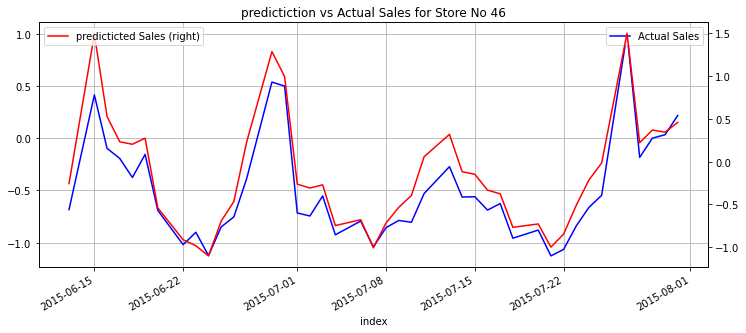

In [343]:
# Plot shows the actual sales and predicticted sales for Store No 46.

plt.figure(figsize = (12, 5))
plt.xlabel("Date")

axis1 = X_test.Sales.plot(color = "blue", grid = True, label = "Actual Sales")
axis2 = f.Sales.plot(color = "red", grid = True, secondary_y = True, label = "predicticted Sales")

axis1.legend(loc = 1)
axis2.legend(loc = 2)
plt.title("predictiction vs Actual Sales for Store No 46")
plt.show()

In [344]:
# Evaluate the model.

forecast_errors = [X_test.Sales[i]-f.Sales[i] for i in range(len(X_test.Sales))]
bias = sum(forecast_errors) * 1.0/len(X_test.Sales)
print("Bias : %f" % bias)

mse = mean_squared_error(X_test.Sales, f.Sales)
print("Mean Squared Error(MSE) : %f" % mse)

rmse = sqrt(mse)
print("Root Mean Square Error(RMSE) : %f" % rmse)

abs_error = np.abs(X_test.Sales - f.Sales)
actual = X_test.Sales
mape = np.round(np.mean(abs_error/actual)*100, 2)
print("Mean Absolute Percentage Error(MAPE) : %f" % mape)

mae = mean_absolute_error(X_test.Sales, f.Sales)
print("Mean Absolute Error(MAE): %f" % mae)

Bias : -0.351572
Mean Squared Error(MSE) : 0.171048
Root Mean Square Error(RMSE) : 0.413580
Mean Absolute Percentage Error(MAPE) : -12969.360000
Mean Absolute Error(MAE): 0.355614


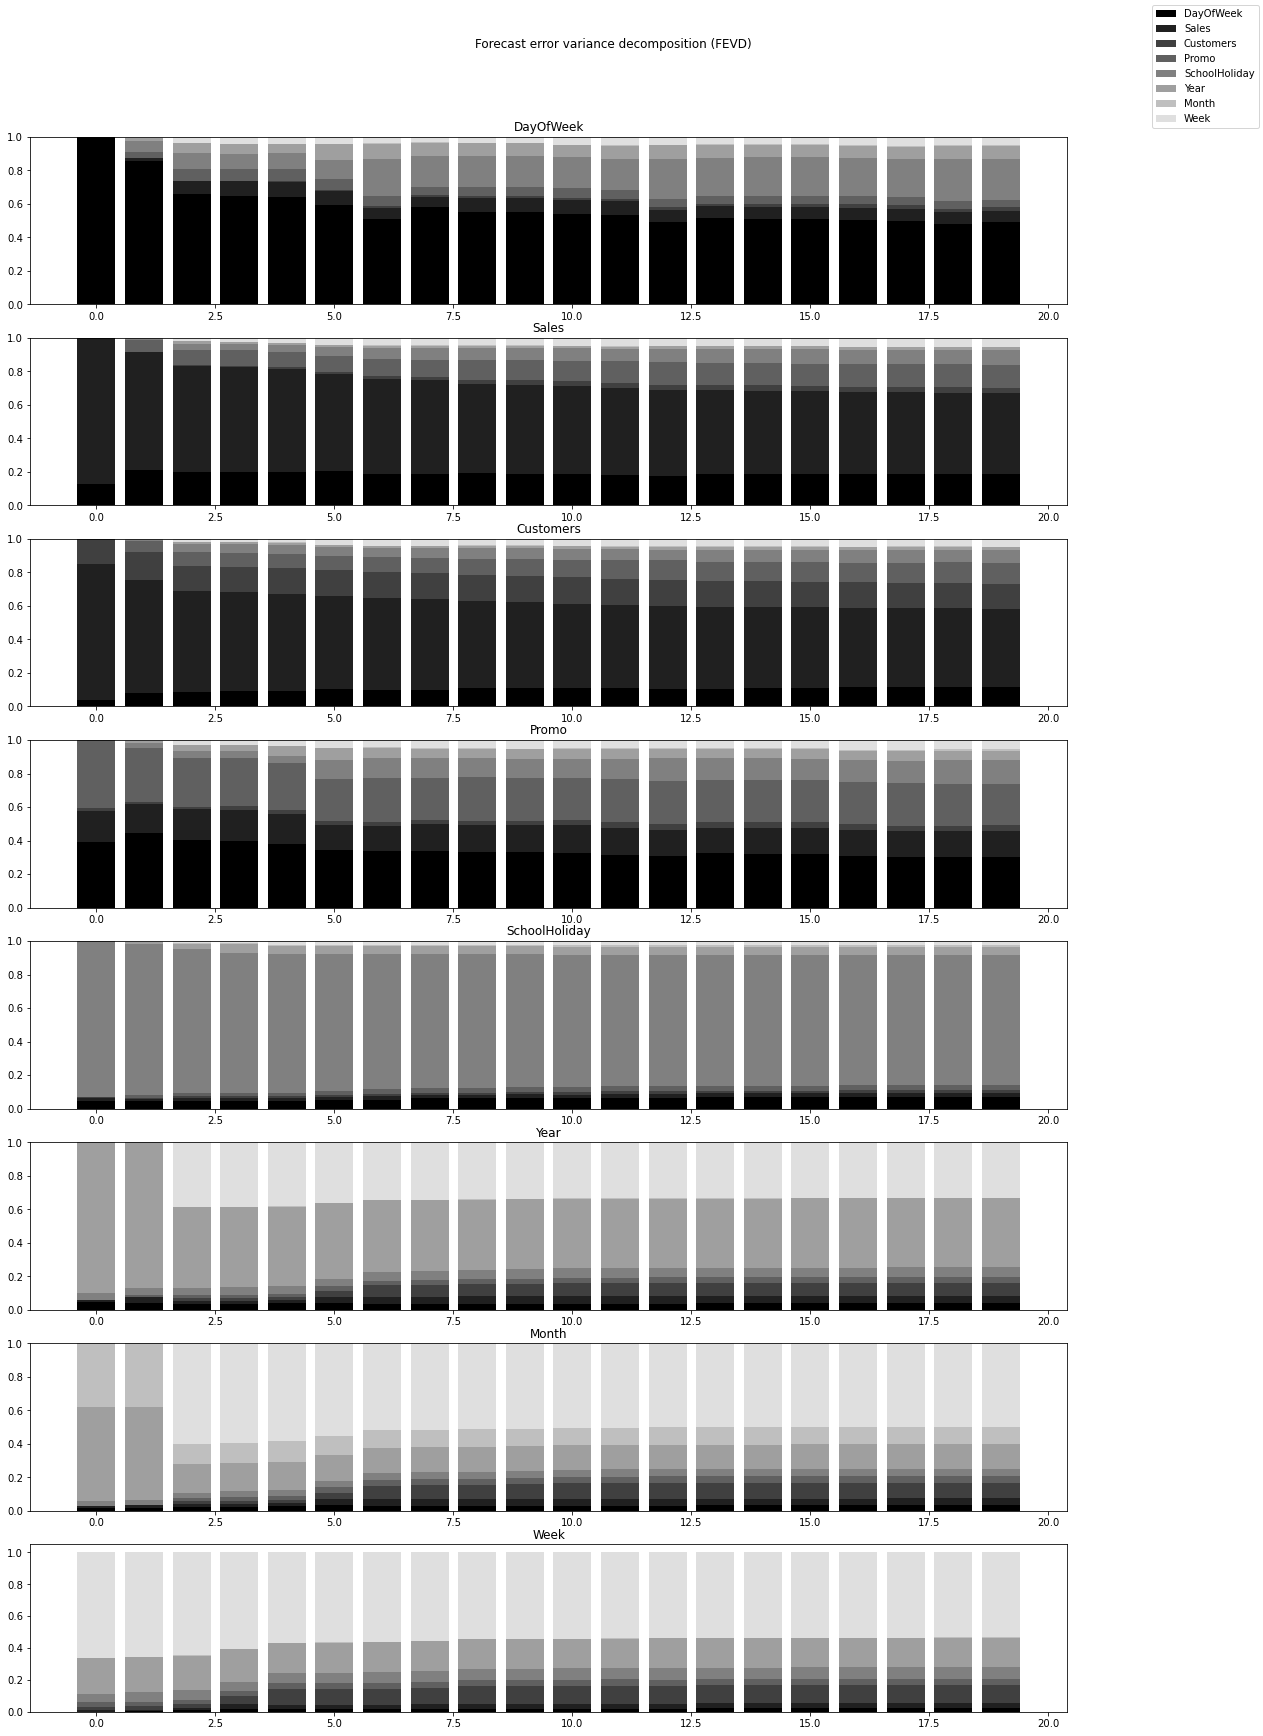

In [345]:
# Forecast Error Variance Decomposition (FEVD). 
# Forecast errors of component j on k in an i-step ahead forecast can be decomposed using the orthogonalized impulse responses.

fevd = res.fevd(20).plot(figsize = (18, 25))

## Step 7 : Conclusion.

-  The analysis provides insights on some of the factors that affect the sales performance, stores that shows 
   Increases in yearly sales' performances, store that has highest sales/customer ratio and etc.
-  Capture the store with highest sales/customer ratio is not the ones with the highes sales.
-  Stationarity, trend and    sesonality of Nine different stores were analysed.
- There are 2 or 3 models have been tried out for each store 1,3,8,9,13,25,29,31,46 using different hyperparameters. 
-  The ACF and PACF plot were also derived from the data to further understand their behaviour.
-  Compared the fitted values plots from VAR models using different lag values.
-  The MAPE, MAE and RMSE scores from these models also compared. Their performance is pretty comparable.
